<div class="alert alert-block alert-success">
<a class="anchor" id="chapter0"></a>
<font color = '#006400'> 
    
# 0. Identificação do Objectivo de Negócio
</a>
    
</div>

• O estudo centra-se na análise de um programa de descontos para produtos próximos da data de validade (etiquetas cor-de-rosa). O objetivo é compreender o impacto das reduções de preço e o momento em que foram aplicadas, identificando padrões de consumo e desenvolvendo estratégias para maximizar a eficiência do programa.

• Para isso, foram recolhidos dados de vendas e produtos não vendidos de diversas lojas em Portugal Continental de produtos aos quais foram aplicados a etiqueta de desconto (etiqueta cor-de-rosa) durante o mês de Outubro de 2021. Os dados fornecidos refletem um cenário realista, mas com imperfeições típicas de um ambiente operacional. A análise desses dados permitirá definir abordagens para optimizar as decisões de pricing e minimizar desperdícios associados a produtos que atingem o limite de `shelf life`.

• O estudo está estruturado em várias fases:<br>
    1. Compreensão e Tratamento de Dados<br>
    2. Definição de variáveis críticas para o modelo de previsão<br>
    3. Treino, validação, afinamento de hiperparâmetros e teste do modelo<br>
    4. Apresentação de conclusões e análises futuras que possam enriquecer o modelo de previsão e a estratégia de descontos.<br><br>

__Data_store.xlsx__

| Atributo | Descrição | 
| --- | --- |
| Idstore | Loja de aplicação da etiqueta |
| type | Dimensão da loja |
| selling_square_ft | Área de venda da loja |
| district | Distrito de localização da loja |

__Data_labels.xlsx__

| Atributo | Descrição | 
| --- | --- |
| Idstore | Loja de aplicação da etiqueta |
| Sku| Identificação interna do produto (Stock Keeping Unit)|
| Brand | Marca do Produto |
| Oldpvp | Preço antes da etiquetagem de desconto |
| Newpvp (discount) | Preço aplicado na etiquetagem de desconto (desconto aplicado) |
| Labelqty | Número de etiquetagens aplicadas (sempre 1 no dataset) |
| Weight | Peso de cada SKU |
| Payment_method | Método de pagamento usado na venda |
| Margin (%) | % de margem bruta do artigo |
| Profit (€) | Lucro bruto em euros |
| perc_expiring_sku | Proporção do 'shelf life' restante no momento de aplicação da etiqueta de desconto|
| expiring_date | Data de validade do artigo |
| labelling_date | Data de etiquetagem de desconto do artigo |
| sell_date | Data de venda do artigo |
| Sold | Variável boleano para indicação se o produto foi vendido (=1) ou não (=0) antes do final de validade do artigo |

<div class="alert alert-block alert-success">
<a class="anchor" id="chapter1"></a>
<font color = '#006400'> 
    
# 1. Importação das Bibliotecas e Datasets
</a>
    
</div>

<div class="alert alert-block alert-info">
    
<a id='number_clusters'></a>

### 1.1. Importação das bibliotecas
    
</div>

In [506]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import time
warnings.filterwarnings('ignore')

#################################################################### CHI SQUARE TEST ###################################################################
from scipy.stats import chi2_contingency

################################################################# FEATURE SELECTION IMPORTS ############################################################
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.feature_selection import RFE 
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier

################################################################# KFOLD TRAINING-TESTING ###############################################################
from sklearn.model_selection import StratifiedKFold

################################################################# TRAIN-TEST SPLIT #####################################################################
from sklearn.model_selection import train_test_split

################################################################# PREPROCESSING #################################################################
from sklearn.preprocessing import MinMaxScaler

################################################# MODELS #####################################################################
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

################################################# METRICS ####################################################################
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, precision_recall_curve,roc_curve

################################### MODEL SELECTION & OPTIMIZATION ###########################################################
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

################################### LOG TRANSFORMATION###########################################################################
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

################################### CLUSTERING ###########################################################################
from sklearn.cluster import KMeans
from sklearn.metrics import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

<div class="alert alert-block alert-info">
    
<a id='number_clusters'></a>

### 1.2. Importação dos datasets
    
</div>

In [7]:
df_store = pd.read_excel(r'Data_store.xlsx')
df_store

idstore   type  selling_square_ft        district
0          1  Large             4762.0           Évora
1          2  Large            12358.0        Bragança
2          3  Large            16159.0          Lisboa
3          4  Large            17903.0           Porto
4          5  Large            16179.0         Coimbra
..       ...    ...                ...             ...
337      338  Small             1935.0          Leiria
338      339  Small             2680.0      Portalegre
339      340  Small              866.0         Coimbra
340      341  Small                NaN  Castelo Branco
341      342  Small              403.0            Beja

[342 rows x 4 columns]

In [8]:
df_labels = pd.read_excel(r'Data_labels.xlsx')
df_labels.head(18)

idstore  sku      brand oldpvp new_pvp (discount)  labelqty weight (g)  \
0         1    1   Marca  1   4.22        2.11 (0.50)         1        260   
1         1    1    Marca 1   3.96        1.98 (0.50)         1        260   
2         1    1   Marca  1   4.74        2.37 (0.50)         1        260   
3         1    1    Marca 1    4.2         2.1 (0.50)         1        260   
4         1    1   Marca  1   4.62        2.31 (0.50)         1        260   
5         1    1  Marca   1   4.62        2.31 (0.50)         1        260   
6         1    1     Marca1   3.42        1.71 (0.50)         1        260   
7         1    1   Marca  1   3.62        1.81 (0.50)         1        260   
8         1    1     Marca1   4.62        2.31 (0.50)         1        260   
9         1    1   Marca  1   4.38        2.19 (0.50)         1        260   
10        1    1  Marca   1   5.23                NaN         1        260   
11        1    1   Marca  1   5.89        2.94 (0.50)         1        260   
12        1    1    Marca 1   3.78        1.89 (0.50)         1        260   
13        1    1  Marca   1   4.76        2.38 (0.50)         1        260   
14        2    2   marca  2   3.19        1.59 (0.50)         1        222   
15        2    2    marca 2    NaN        1.59 (0.50)         1        222   
16        2    2     marca2   3.19        1.59 (0.50)         1        222   
17        2    2   marca  2   3.19        1.59 (0.50)         1        222   

   Payment_method  Margin (%)  Profit (€)  perc_expiring_sku expiring_date  \
0            Card          16      0.3376           0.010050    03/10/2021   
1                          16      0.3168           0.005025    02/10/2021   
2            Cash          16      0.3792           0.010050    03/10/2021   
3            Card          16      0.3360           0.010050    03/10/2021   
4            Cash          16      0.3696           0.010050    03/10/2021   
5            Cash          16      0.3696           0.010050    03/10/2021   
6            Cash          16      0.2736           0.005025    02/10/2021   
7            Card          16      0.2896           0.005025    02/10/2021   
8                          16      0.3696           0.005025    02/10/2021   
9            Card          16      0.3504           0.010050    03/10/2021   
10           Card          16      0.4176           0.010050    03/10/2021   
11           Cash          16      0.4704           0.010050    03/10/2021   
12           Cash          16      0.3024           0.010050    03/10/2021   
13                         16      0.3808           0.010050    03/10/2021   
14           Cash          15      0.2385           0.121212    25/10/2021   
15           Cash          15      0.2385           0.121212    25/10/2021   
16           Card          15      0.2385           0.121212    25/10/2021   
17           Cash          15      0.2385           0.121212    25/10/2021   

   labelling_date  sell_date  sold  
0      2021-10-01 2021-10-02   1.0  
1      2021-10-01        NaT   0.0  
2      2021-10-01 2021-10-03   1.0  
3      2021-10-01 2021-10-02   1.0  
4      2021-10-01 2021-10-03   NaN  
5      2021-10-01 2021-10-03   NaN  
6      2021-10-01 2021-10-02   1.0  
7      2021-10-01 2021-10-02   1.0  
8      2021-10-01        NaT   0.0  
9      2021-10-01 2021-10-02   1.0  
10     2021-10-01 2021-10-03   1.0  
11     2021-10-01 2021-10-02   1.0  
12     2021-10-01 2021-10-02   1.0  
13     2021-10-01        NaT   0.0  
14     2021-10-13 2021-10-14   1.0  
15     2021-10-13 2021-10-14   1.0  
16     2021-10-13 2021-10-15   1.0  
17     2021-10-13 2021-10-16   1.0

<div class="alert alert-block alert-info">
    
<a id='number_clusters'></a>

### 1.3. Mesclagem dos datasets
    
</div>

In [10]:
df = df_labels.merge(df_store, on = 'idstore')

<div class="alert alert-block alert-info">
    
<a id='number_clusters'></a>

### 1.4. Verificação de Duplicados
    
</div>

In [12]:
df[df.duplicated()]

idstore  sku      brand oldpvp new_pvp (discount)  labelqty  \
36            7    2     Marca2   3.19        2.39 (0.25)         1   
39            7    2    Marca 2   3.19        2.39 (0.25)         1   
41            7    2    Marca 2   3.19        2.39 (0.25)         1   
42            7    2   Marca  2   3.19        2.39 (0.25)         1   
43            7    2    Marca 2   3.19        2.39 (0.25)         1   
...         ...  ...        ...    ...                ...       ...   
150034      177  318     Marca2   2.49         1,24 (50%)         1   
150036      177  318    Marca 2   2.49         1,24 (50%)         1   
150038      177  318  Marca   2   2.49         1,24 (50%)         1   
150048      193  318   Marca  2   2.49        1.24 (0.50)         1   
150051      203  318     Marca2   2.49        1.24 (0.50)         1   

       weight (g) Payment_method  Margin (%)  Profit (€)  perc_expiring_sku  \
36            222                         15      0.3585           0.111111   
39            222                         15      0.3585           0.111111   
41            222                         15      0.3585           0.111111   
42            222                         15      0.3585           0.111111   
43            222                         15      0.3585           0.111111   
...           ...            ...         ...         ...                ...   
150034         97                         11      0.1364           0.006289   
150036         97                         11      0.1364           0.006289   
150038         97                         11      0.1364           0.006289   
150048         97           Cash          11      0.1364           0.100629   
150051         97           Cash          11      0.1364           0.113208   

       expiring_date labelling_date  sell_date  sold    type  \
36        26/10/2021     2021-10-15        NaT   0.0   Large   
39        26/10/2021     2021-10-15        NaT   0.0   Large   
41        26/10/2021     2021-10-15        NaT   0.0   Large   
42        26/10/2021     2021-10-15        NaT   0.0   Large   
43        26/10/2021     2021-10-15        NaT   0.0   Large   
...              ...            ...        ...   ...     ...   
150034    19-10-2021     2021-10-18        NaT   0.0   Small   
150036    19-10-2021     2021-10-18        NaT   0.0   Small   
150038    19-10-2021     2021-10-18        NaT   0.0   Small   
150048    19-10-2021     2021-10-03 2021-10-09   1.0  Medium   
150051    19-10-2021     2021-10-01 2021-10-02   1.0  Medium   

        selling_square_ft district  
36                13618.0   Guarda  
39                13618.0   Guarda  
41                13618.0   Guarda  
42                13618.0   Guarda  
43                13618.0   Guarda  
...                   ...      ...  
150034              842.0    Porto  
150036              842.0    Porto  
150038              842.0    Porto  
150048             5048.0    Viseu  
150051             9370.0     Faro  

[33740 rows x 18 columns]

Apesar de termos verificado a existência de linhas aparentemente duplicadas, não se procederá à sua eliminação, uma vez que representam unidades diferentes do mesmo SKU e rotulados com a mesma informação.

Mesmo que os dados pareçam idênticos, cada unidade pode estar associada a lotes diferentes ou a vendas separadas, o que é crucial para compreender o desempenho real do produto.
Por isso, eliminar estes registos afectaria a análise, ocultando informações importantes sobre o comportamento de vendas e a gestão de inventário.

<div class="alert alert-block alert-success">
<a id='import'>
<font color = '#006400'> 
    
# 2. Análise Exploratória
</a>
    
</div>

<div class="alert alert-block alert-warning">

<a id='basic'></a>

## 2.1. Exploração Básica
    
</div>

In [16]:
df.shape

(150054, 18)

In [17]:
df.columns

Index(['idstore', 'sku', 'brand', 'oldpvp', 'new_pvp (discount)', 'labelqty',
       'weight (g)', 'Payment_method', 'Margin (%)', 'Profit (€)',
       'perc_expiring_sku', 'expiring_date', 'labelling_date', 'sell_date',
       'sold', 'type', 'selling_square_ft', 'district'],
      dtype='object')

In [18]:
df.head(20)

idstore  sku      brand oldpvp new_pvp (discount)  labelqty weight (g)  \
0         1    1   Marca  1   4.22        2.11 (0.50)         1        260   
1         1    1    Marca 1   3.96        1.98 (0.50)         1        260   
2         1    1   Marca  1   4.74        2.37 (0.50)         1        260   
3         1    1    Marca 1    4.2         2.1 (0.50)         1        260   
4         1    1   Marca  1   4.62        2.31 (0.50)         1        260   
5         1    1  Marca   1   4.62        2.31 (0.50)         1        260   
6         1    1     Marca1   3.42        1.71 (0.50)         1        260   
7         1    1   Marca  1   3.62        1.81 (0.50)         1        260   
8         1    1     Marca1   4.62        2.31 (0.50)         1        260   
9         1    1   Marca  1   4.38        2.19 (0.50)         1        260   
10        1    1  Marca   1   5.23                NaN         1        260   
11        1    1   Marca  1   5.89        2.94 (0.50)         1        260   
12        1    1    Marca 1   3.78        1.89 (0.50)         1        260   
13        1    1  Marca   1   4.76        2.38 (0.50)         1        260   
14        2    2   marca  2   3.19        1.59 (0.50)         1        222   
15        2    2    marca 2    NaN        1.59 (0.50)         1        222   
16        2    2     marca2   3.19        1.59 (0.50)         1        222   
17        2    2   marca  2   3.19        1.59 (0.50)         1        222   
18        2    2    marca 2   3.19        1.59 (0.50)         1        222   
19        2    2    marca 2   3.19        1.59 (0.50)         1        222   

   Payment_method  Margin (%)  Profit (€)  perc_expiring_sku expiring_date  \
0            Card          16      0.3376           0.010050    03/10/2021   
1                          16      0.3168           0.005025    02/10/2021   
2            Cash          16      0.3792           0.010050    03/10/2021   
3            Card          16      0.3360           0.010050    03/10/2021   
4            Cash          16      0.3696           0.010050    03/10/2021   
5            Cash          16      0.3696           0.010050    03/10/2021   
6            Cash          16      0.2736           0.005025    02/10/2021   
7            Card          16      0.2896           0.005025    02/10/2021   
8                          16      0.3696           0.005025    02/10/2021   
9            Card          16      0.3504           0.010050    03/10/2021   
10           Card          16      0.4176           0.010050    03/10/2021   
11           Cash          16      0.4704           0.010050    03/10/2021   
12           Cash          16      0.3024           0.010050    03/10/2021   
13                         16      0.3808           0.010050    03/10/2021   
14           Cash          15      0.2385           0.121212    25/10/2021   
15           Cash          15      0.2385           0.121212    25/10/2021   
16           Card          15      0.2385           0.121212    25/10/2021   
17           Cash          15      0.2385           0.121212    25/10/2021   
18           Cash          15      0.2385           0.121212    25/10/2021   
19           Card          15      0.2385           0.121212    25/10/2021   

   labelling_date  sell_date  sold   type  selling_square_ft  district  
0      2021-10-01 2021-10-02   1.0  Large             4762.0     Évora  
1      2021-10-01        NaT   0.0  Large             4762.0     Évora  
2      2021-10-01 2021-10-03   1.0  Large             4762.0     Évora  
3      2021-10-01 2021-10-02   1.0  Large             4762.0     Évora  
4      2021-10-01 2021-10-03   NaN  Large             4762.0     Évora  
5      2021-10-01 2021-10-03   NaN  Large             4762.0     Évora  
6      2021-10-01 2021-10-02   1.0  Large             4762.0     Évora  
7      2021-10-01 2021-10-02   1.0  Large             4762.0     Évora  
8      2021-10-01        NaT   0.0  Large             4762.0     Évor

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150054 entries, 0 to 150053
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   idstore             150054 non-null  int64         
 1   sku                 150054 non-null  int64         
 2   brand               150054 non-null  object        
 3   oldpvp              150032 non-null  object        
 4   new_pvp (discount)  150026 non-null  object        
 5   labelqty            150054 non-null  int64         
 6   weight (g)          150050 non-null  object        
 7   Payment_method      150054 non-null  object        
 8   Margin (%)          150054 non-null  int64         
 9   Profit (€)          150054 non-null  float64       
 10  perc_expiring_sku   149929 non-null  float64       
 11  expiring_date       150054 non-null  object        
 12  labelling_date      150054 non-null  datetime64[ns]
 13  sell_date           80511 non

<div class="alert alert-block alert-warning">

<a id='basic'></a>

## 2.2. Exploração Estatística
    
</div>

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 2.2.1. Variáveis Numéricas
    
</div>

In [22]:
df.describe()

idstore            sku  labelqty     Margin (%)     Profit (€)  \
count  150054.000000  150054.000000  150054.0  150054.000000  150054.000000   
mean      139.234242     163.699422       1.0      15.824950       0.175131   
min         1.000000       1.000000       1.0      10.000000       0.034000   
25%        59.000000      99.000000       1.0      13.000000       0.124500   
50%       135.000000     160.000000       1.0      17.000000       0.152900   
75%       212.000000     236.000000       1.0      19.000000       0.222400   
max       332.000000     319.000000       1.0      20.000000      99.900000   
std        87.056044      87.247006       0.0       3.303568       0.268439   

       perc_expiring_sku                 labelling_date  \
count      149929.000000                         150054   
mean            0.385245  2021-10-16 16:41:47.577271808   
min             0.000000            2021-10-01 00:00:00   
25%             0.200000            2021-10-10 00:00:00   
50%             0.333333            2021-10-17 00:00:00   
75%             0.666667            2021-10-25 00:00:00   
max             2.000000            2021-10-31 00:00:00   
std             0.223626                            NaN   

                           sell_date           sold  selling_square_ft  
count                          80511  149940.000000      139275.000000  
mean   2021-10-17 18:22:01.846704384       0.536568        5978.197487  
min              2021-10-01 00:00:00       0.000000          10.000000  
25%              2021-10-11 00:00:00       0.000000        1218.000000  
50%              2021-10-18 00:00:00       1.000000        4982.000000  
75%              2021-10-25 00:00:00       1.000000        8671.000000  
max              2021-11-18 00:00:00       1.000000       25258.000000  
std                              NaN       0.498663        5533.809602

Da tabela anterior podemos tirar algumas conclusões, como:
- `count`- O dataset df possui missing values nas variáveis numéricas perc_expiring_sku, sell_date, sold e selling_square_ft;
- `mean`- O dataset encontra-se praticamente balanceado entre artigos vendidos e não vendidos (0.53);
- `min` e `max`- As rotulagens dos artigos em análise foram realizadas durante todo o mês de Outubro de 2021 e a variável perc_expiring_sku possui uma valor máximo de 2, não fazendo sentido no contexto da variável;
- `std`- O desvio-padrão da variável selling_square_ft é bastante considerável face à média, podendo indicar a presença de outliers;
- `quartis`- Verificamos que a variável selling_square_ft possui um 3º quartil bastante superior ao valor médio, indicado uma distribuição com enviesamento à direita, ou seja, parece indicar uma grande quantidade de lojas de área de venda de pequena dimensão e uma menor quantidade de lojas com grande dimensão de área de venda, ou eventualmente outliers;
- As variáveis 'idstore' e 'sku' não deviam estar classificadas como numéricas mas sim com categóricas, não fazendo sentido a sua análise estatística neste passo.

In [24]:
df['sold'].value_counts()

sold
1.0    80453
0.0    69487
Name: count, dtype: int64

In [25]:
num_de_vendas = df['sell_date'].value_counts().sum()
num_de_nao_vendas = df['sell_date'].isna().sum()
print(num_de_vendas)
print(num_de_nao_vendas)

80511
69543


Verifica-se uma diferença entre o nº de observações com a variável 'sold' igual a 1 e o número de observações da variável 'sell_date' não nula. <br>
Esta diferença será analisada e corrigida em passos posteriores de forma a que faça sentido para a análise. 

In [27]:
df.skew(numeric_only=True)

idstore                0.166375
sku                   -0.072151
labelqty               0.000000
Margin (%)            -0.374411
Profit (€)           341.717605
perc_expiring_sku      0.261184
sold                  -0.146666
selling_square_ft      1.091003
dtype: float64

Através da análise do skewness, verifica-se:
- `Skewness Elevado (superior a |1.0|)`: Profit (€) e selling_square_ft
- `Skewness igual a 0:` Variável 'labelqty' constante, pelo que será desconsiderada da análise. 


In [29]:
df.kurt(numeric_only=True)

idstore                  -1.121767
sku                      -1.118777
labelqty                  0.000000
Margin (%)               -1.260135
Profit (€)           126938.236692
perc_expiring_sku        -0.022512
sold                     -1.978515
selling_square_ft         0.693269
dtype: float64

Através da análise anterior, reforça-se a suspeita de presença de outliers na variável 'Profit (€)', devido ao elevado valor da sua kurtosis (superior a 3.0).

Concluindo, é importante verificar a presença de possiveis outliers nas seguintes variáveis:

- 'selling_square_ft'
- 'Profit (€)'

<div class="alert alert-block alert-info">
    
<a id='stats_cat'></a>

### 2.2.2. Variáveis Categóricas
    
</div>

In [32]:
df.describe(include = ['O'])

brand     oldpvp new_pvp (discount)  weight (g) Payment_method  \
count     150054  150032.00             150026      150050         150054   
unique       328     140.00                396         189              3   
top      marca 2       1.19        0.83 (0.30)         121                  
freq       18249   22234.00              18219        9521          69543   

       expiring_date    type district  
count         150054  150054   150054  
unique            84       4       18  
top       28/10/2021  Medium   Lisboa  
freq            4741   62590    14888

Através da análise acima apresentada, podemos concluir:

- Existem missing values nas variáveis `oldpvp`, `new_pvp (discount)` e `weight (g)`;
- A variável `district` possui 18 valores únicos, podendo indicar que todos os distritos de Portugal Continental se encontram representados no dataset, sendo o distrito de Lisboa o mais representado;
- A variável `payment_method` possui 3 valores possíveis, sendo o espaço em branco o mais frequente e na mesma quantidade que o nº de produtos não vendidos. Será de prever que estará associado a uma venda não realizada mas necessita de transformação para ser convertido num valor compreensível;
- A variável `expiring_date` não se encontra classificada como data, podendo indicar algum erro de formatação nos seus valores;
- As variáveis `oldpvp`, `new_pvp (discount)` e `weight (g)` não devem estar classificadas como categóricas mas sim com numéricas;
- Verifica-se que na variável `new_pvp (discount)` existem caracteres especiais que impedem a sua classificação como numérica, sendo que se deverá suceder o mesmo com as restantes;


In [34]:
df['brand'].value_counts().head(20)

brand
 marca 2     18249
 Marca 2     17008
marca  2      9077
marca   2     9068
marca2        9043
marca 2       9037
Marca2        8840
Marca 2       8672
Marca  2      8616
Marca   2     8553
 Marca 7      2739
 marca 7      2426
 Marca 15     2051
 marca 15     1983
Marca7        1447
Marca 7       1385
Marca  7      1333
Marca   7     1319
marca  7      1227
marca 7       1197
Name: count, dtype: int64

Confirma-se a existência de vários nomes repetidos mas com digitações diversas na variável `brand`. Será alvo de transformação em passos posteriores.

In [36]:
df['expiring_date'].value_counts().head(10)

expiring_date
28/10/2021    4741
29/10/2021    4737
22/10/2021    4543
15/10/2021    4481
22-10-2021    4440
21/10/2021    4380
23/10/2021    4196
29-10-2021    4156
07/10/2021    3877
15-10-2021    3831
Name: count, dtype: int64

Confirma-se a existência de datas com formatação diferente na variável `expiring_date`, impedindo a sua classificação automática como variável data.<br> Estes valores são alvo de transformação em passos posteriores.

In [38]:
df['Payment_method'].value_counts().head(20)

Payment_method
        69543
Card    40398
Cash    40113
Name: count, dtype: int64

Confirma-se a existência de uma categoria de valor vazio na variável `Payment_method`, sendo que será de prever que estará associado a uma venda não realizada mas necessita de transformação para ser convertido num valor compreensível. Estes casos serão alvo de tratamento em passos posteriores.

In [40]:
df['type'].value_counts()

type
Medium    62590
Small     60599
Large     26219
0           646
Name: count, dtype: int64

Confirma-se a existência de valores da variável `type` iguais a 0.  Estes missing values serão alvo de transformação em passos posteriores.

In [42]:
df['district'].value_counts()

district
Lisboa              14888
Porto               12018
Coimbra             10694
Braga               10050
Guarda               9699
Viana do Castelo     8943
Aveiro               8650
Viseu                8421
Castelo Branco       7770
Beja                 7664
Bragança             7230
Setúbal              7207
Évora                6975
Portalegre           6857
Vila Real            6820
Faro                 6432
Santarém             5946
Leiria               3790
Name: count, dtype: int64

Confirma-se a existência dos 18 distritos de Portugal Continental no dataset, com maior predominância dos distritos com grandes centros urbanos (Lisboa, Porto, Coimbra e Braga).

In [44]:
df['weight (g)'].head(50)

0     260
1     260
2     260
3     260
4     260
5     260
6     260
7     260
8     260
9     260
10    260
11    260
12    260
13    260
14    222
15    222
16    222
17    222
18    222
19    222
20    222
21    222
22    222
23    222
24    222
25    222
26    222
27    222
28    222
29    222
30    222
31    222
32    222
33    222
34    222
35    222
36    222
37    222
38    222
39    222
40    222
41    222
42    222
43    222
44    222
45    222
46    NaN
47    222
48    222
49    222
Name: weight (g), dtype: object

Verifica-se a existência de valores `NaN` na variável 'weight (g)' do dataset. Uma vez de isto não ser impeditivo de classificação como int64, é de prever a existência de caracteres especiais, como espaços em branco.

In [46]:
df['oldpvp'].tail(10)

150044    2,49
150045    2.49
150046    2.49
150047    2.49
150048    2.49
150049    2.49
150050    2.49
150051    2.49
150052    3.49
150053    3.49
Name: oldpvp, dtype: object

Verifica-se a existência de valores da variável 'oldpvp' com vírgula como separador da parte decimal em vez de ponto, sendo essa a razão para classificação da variável como 'object' ao invés de 'float64'. Estes valores são alvo de transformação em passos posteriores.

In [48]:
df['new_pvp (discount)'].tail(10)

150044     1,24 (50%)
150045    1.24 (0.50)
150046    1.24 (0.50)
150047    1.24 (0.50)
150048    1.24 (0.50)
150049    1.24 (0.50)
150050    1.24 (0.50)
150051    1.24 (0.50)
150052    2.44 (0.30)
150053    2.44 (0.30)
Name: new_pvp (discount), dtype: object

Além dos pontos anteriores, verifica-se a existência de registos com formato decimal e outros com formato percentual na variável 'new_pvp (discount)'.

<div class="alert alert-block alert-success">
<a id='preprocess'>
<font color = '#006400'> 
    
# 3. Pré-Processamento de Dados
</a>
    
</div>

<div class="alert alert-block alert-warning">

<a id='clean'></a>

## 3.1. Limpeza de Dados
    
</div>

<div class="alert alert-block alert-info">

<a id='missing'></a>

### 3.1.1. Missing Values
    
</div>

Na `secção 2`, verificámos que o dataset possui missing values nas variáveis `oldpvp`, `new_pvp (discount)`, `weight (g)`, `perc_expiring_sku`, `sell_date`, `sold` e `selling_square_ft`, sendo que as variáveis `Payment_method` e `type` possuem caracteres ou espaços, sendo também considerados como missing values. No comando seguinte, verificámos a presença de alguns desses valores.

In [54]:
df.isna().sum()

idstore                   0
sku                       0
brand                     0
oldpvp                   22
new_pvp (discount)       28
labelqty                  0
weight (g)                4
Payment_method            0
Margin (%)                0
Profit (€)                0
perc_expiring_sku       125
expiring_date             0
labelling_date            0
sell_date             69543
sold                    114
type                      0
selling_square_ft     10779
district                  0
dtype: int64

#### 3.1.1.1 Alteração de valores da Variável 'sold'

No dataset verifica-se que existem observações com datas na variável `sell_date` mas que o respectivo valor da variável `sold` não é igual a 1. Neste ponto considera-se a variável 'sell_date' como correcta e, dessa forma, substituir-se-á o valor da variável `sold` para 1 quando a variável `sell_date` se encontra preenchida.

In [57]:
df.loc[(df['sold'] != 1) & (df['sell_date'].notna()),'sold']=1

Conforme se verifica, a situação contrária também acontece, com observações que não possuem valor na variável `sell_date` e o `sold` não é 0.<br>
Desta forma, substituir-se-á o valor da variável `sold` para 0 quando a `sell_date` se encontra vazia.

In [59]:
df.loc[(df['sold'].isna()) & (df['sell_date'].isna()),'sold']=0

In [60]:
df['sold'].value_counts()

sold
1.0    80511
0.0    69543
Name: count, dtype: int64

In [61]:
num_de_vendas = df['sell_date'].value_counts().sum()
num_de_nao_vendas = df['sell_date'].isna().sum()
print(num_de_vendas)
print(num_de_nao_vendas)

80511
69543


Verifica-se assim a igualdade de número de artigos vendidos <b>(80511)</b> e de datas de venda <b>(80511)</b>, tal como para os não vendidos e inexistência de dados de data de venda <b>(69543)</b>, validando as transformações realizadas.

#### 3.1.1.2 Divisão da variável 'new_pvp (discount)'

Os constituintes da variável 'new_pvp (discount)' deverão ser tratados e analisados em separado, isto é, o valor do 'new_pvp' e de 'discount'.<br>Dessa forma, irá proceder-se à separação da variável em 2 novas: 'new_pvp' e 'discount'.

In [65]:
df['new_pvp'] = df['new_pvp (discount)'].astype(str).str.split(' ').str[0]
df['discount'] = df['new_pvp (discount)'].astype(str).str.split(' ').str[1]

In [66]:
df[['new_pvp (discount)','new_pvp','discount']].head(11)

new_pvp (discount) new_pvp discount
0         2.11 (0.50)    2.11   (0.50)
1         1.98 (0.50)    1.98   (0.50)
2         2.37 (0.50)    2.37   (0.50)
3          2.1 (0.50)     2.1   (0.50)
4         2.31 (0.50)    2.31   (0.50)
5         2.31 (0.50)    2.31   (0.50)
6         1.71 (0.50)    1.71   (0.50)
7         1.81 (0.50)    1.81   (0.50)
8         2.31 (0.50)    2.31   (0.50)
9         2.19 (0.50)    2.19   (0.50)
10                NaN     nan      NaN

Verifica-se que os valores da nova variável 'discount' necessitam de tratamento adicional para que possa ser convertida em formato float64, através da remoção dos caracteres especiais e a substituição das virgulas por pontos.

In [68]:
df['discount'] = df['discount'].apply(lambda x: str(x).replace('(', '') if pd.notna(x) else x)
df['discount'] = df['discount'].apply(lambda x: str(x).replace(')', '') if pd.notna(x) else x)
df['discount'] = df['discount'].apply(lambda x: str(x).replace('%', '') if pd.notna(x) else x)
df['discount'] = df['discount'].apply(lambda x: str(x).replace(',', '.') if pd.notna(x) else x)

df['discount'] = df['discount'].astype('float')

In [69]:
df['discount'].tail(10)

150044    50.0
150045     0.5
150046     0.5
150047     0.5
150048     0.5
150049     0.5
150050     0.5
150051     0.5
150052     0.3
150053     0.3
Name: discount, dtype: float64

Como verificado anteriormente, existem valores de 'discount' que se encontram em percentagem e que necessitam de ser convertidos em forma decimal.

In [71]:
df.loc[df['discount'] > 1, 'discount'] = df.loc[df['discount'] > 1, 'discount'] / 100

In [72]:
df['discount'].describe()

count    150026.000000
mean          0.302269
std           0.036940
min           0.010000
25%           0.300000
50%           0.300000
75%           0.300000
max           0.990000
Name: discount, dtype: float64

Verifica-se que os valores da variável se encontram no intervalo esperado [0-1].<br>
De seguida, procede-se à correção dos separadores decimais na variável 'new_pvp' e à eliminação da variável 'new_pvp (discount)':

In [74]:
df['new_pvp'] = df['new_pvp'].apply(lambda x: str(x).replace(',', '.') if pd.notna(x) else x)
df['new_pvp'] = df['new_pvp'].astype('float')

In [75]:
df.drop('new_pvp (discount)', axis=1, inplace=True)

#### 3.1.1.3 Imputação de valores da variável 'new_pvp'

Através dos valores das variáveis 'Profit (€)' e 'Margin (%)', é possível obter os valores em falta da variável 'new_pvp':

In [78]:
df.loc[df['new_pvp'].isna() & df['Margin (%)'].notna() & df['Profit (€)'].notna(), 'new_pvp'] = df['Profit (€)'] / df['Margin (%)'] *100

#### 3.1.1.4 Imputação de valores da variável 'oldpvp'

De igual forma, também se pode obter valores em falta da variável 'oldpvp' através das variáveis 'new_pvp' e 'discount'. Para tal, é necessário efetuar a correção do separador decimal e mudança do tipo de formato da variável.

In [81]:
df['oldpvp'] = df['oldpvp'].apply(lambda x: str(x).replace(',', '.') if pd.notna(x) else x)
df['oldpvp'] = df['oldpvp'].astype('float')

In [82]:
df.loc[df['oldpvp'].isna() & df['new_pvp'].notna() & df['discount'].notna(), 'oldpvp'] = df['new_pvp'] / (1 - df['discount'])

#### 3.1.1.5 Imputação de valores da variável 'discount'

Por fim, os valores em falta da variável 'discount' podem ser obtidos através das variáveis 'new_pvp' e 'oldpvp':

In [85]:
df.loc[df['discount'].isna() & df['oldpvp'].notna() & df['new_pvp'].notna(), 'discount'] = df['new_pvp'] / df['oldpvp']

#### 3.1.1.6 Imputação de valores da variável 'weight (g)'

A variável 'weight (g)' possui espaços em branco que têm que ser substituidos por `NaN` antes de tratamento:

In [88]:
df['weight (g)'].replace(r'^\s*$', np.nan, regex=True, inplace=True)

Através da análise do dataset, verifica-se que os missing values pertencem aos sku's 2 e 4. Os restantes registos destes sku's possuem a variável 'weight (g)' preenchida com valor igual. Dessa forma, vamos assumir esse valor para preencher os valores de 'weight (g)' quando o sku é 2 ou 4:

In [90]:
df[df['sku'] == 2]['weight (g)'].value_counts()

weight (g)
222.0    101
Name: count, dtype: int64

In [91]:
df[df['sku'] == 4]['weight (g)'].value_counts()

weight (g)
134.0    453
Name: count, dtype: int64

In [92]:
peso_sku_2 = df.loc[df['sku'] == 2, 'weight (g)'].iloc[0]
df.loc[(df['sku'] == 2) & (df['weight (g)'].isna()), 'weight (g)'] = peso_sku_2

In [93]:
peso_sku_4 = df.loc[df['sku'] == 4, 'weight (g)'].iloc[0]
df.loc[(df['sku'] == 4) & (df['weight (g)'].isna()), 'weight (g)'] = peso_sku_4

Os restantes registos vazios da variável 'weight (g)' serão eliminados, não sendo de prever impacto devido à sua dimensão reduzida:

In [95]:
df['weight (g)'].isna().sum()

424

In [96]:
df = df.dropna(subset=['weight (g)'])

#### 3.1.1.7 Imputação de valores da variável 'perc_expiring_sku'

Como verificamos anteriormente, existem valores em branco da variável 'perc_expiring_sku'.<br>
Alguns desses valores podem ser preenchidos por 0 quando o valor da variável 'expiring_date' e 'labelling_date' são iguais.

In [99]:
df.loc[df['expiring_date'] == df['labelling_date'], 'perc_expiring_sku'] = 0

Os restantes registos vazios da variável 'perc_expiring_sku' serão eliminados, não sendo de prever impacto devido à sua dimensão reduzida:

In [101]:
df['perc_expiring_sku'].isna().sum()

80

Os restantes valores da variável 'perc_expiring_sku' serão eliminados:

In [103]:
df = df.dropna(subset=['perc_expiring_sku'])

#### 3.1.1.8 Imputação de valores da variável 'Payment_method'

Através de análises anteriores, verifica-se que a variável 'Payment_method' foi preenchida com um espaço vazio quando o produto não foi vendido.<br> Para facilitar análise, irá atribuir-se o valor 'No_Payment' para esta variável quando o valor de 'sold' for igual a 0:

In [106]:
df.loc[df['sold']== 0,'Payment_method'] = 'No_Payment'

#### 3.1.1.9 Preenchimento de valores da variável 'type'

O valor de 'type' é 0 apenas quando o 'selling_square_ft' apresenta valores nulos. <br>
Assim, para efetuar o preenchimento da variável 'type' com valores iguais a 0, verificou-se o 'type' mais frequente quando o 'selling_square_ft' é nulo:

In [109]:
df[df['selling_square_ft'].isna()].groupby('type').size()

type
0          646
Medium    2028
Small     8078
dtype: int64

Considerando a moda deste subset de 'selling_square_ft' nulos, atribuir-se-á 'Small' ao valores de 'type' iguais a 0.

In [111]:
df.loc[df['type'] == 0, 'type'] = 'Small'

#### 3.1.1.10 Preenchimento de valores da variável 'selling_square_ft'

Os missing values da variável 'selling_square_ft' serão preenchidos com a média dos valores restantes para o mesmo tipo de loja e distrito pois, como podemos verificar, a dimensão da loja dentro da mesma tipologia varia de distrito para distrito.

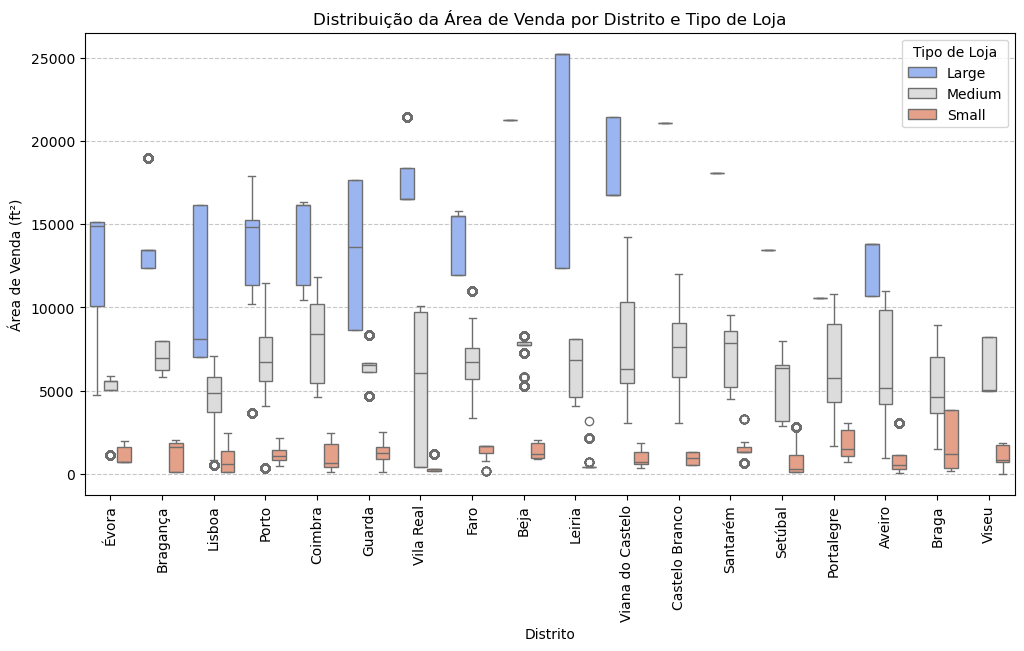

In [114]:
if {"district", "selling_square_ft", "type"}.issubset(df.columns):
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df["district"], y=df["selling_square_ft"], hue=df["type"], palette="coolwarm")
    plt.xticks(rotation=90)
    plt.title("Distribuição da Área de Venda por Distrito e Tipo de Loja")
    plt.xlabel("Distrito")
    plt.ylabel("Área de Venda (ft²)")
    plt.legend(title="Tipo de Loja")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
else:
    print(":x_vermelho: Erro: O DataFrame não contém todas as colunas necessárias (district, selling_square_ft, type).")

In [115]:
df["selling_square_ft"] = df.groupby(["district", "type"])["selling_square_ft"].transform(lambda x: x.fillna(x.mean())).round(0)

<div class="alert alert-block alert-info">

<a id='outliers'></a>

### 3.1.2. Correção de Formatações
    
</div>

#### 3.1.2.1 Correção da formatação da variável 'expiring_date'

Neste passo procede-se à substituição dos caracteres que impedem a classificação da variável 'expiring_date' como variável do tipo datetime:

In [119]:
df['expiring_date'] = df['expiring_date'].str.replace('-', '/', regex=False)

In [120]:
df['expiring_date']=pd.to_datetime(df['expiring_date'], format="%d/%m/%Y")

<div class="alert alert-block alert-info">

<a id='missing'></a>

### 3.1.3. Arredondamento de Valores
    
</div>

Nesta secção proceder-se-á ao arredondamento das variáveis `Perc_expiring_sku`, `Profit (€)`, `oldpvp` e `discount`:

In [123]:
df['perc_expiring_sku']=round(df['perc_expiring_sku'],4)

In [124]:
df['Profit (€)']=round(df['Profit (€)'],4)

In [125]:
df['oldpvp']=round(df['oldpvp'],2)

In [126]:
df['discount']=round(df['discount'],3)

<div class="alert alert-block alert-warning">

<a id='transform'></a>

## 3.2. Transformação de Dados
    
</div>

<div class="alert alert-block alert-info">

<a id='new'></a>

### 3.2.1. Correção de Classificações
    
</div>

Conforme verificado anteriormente, a variável 'brand' possui diversos nomes repetidos mas com digitações diversas. Será normalizada neste momento:

In [130]:
df['brand'] = df['brand'].replace(r'\s+', '', regex=True).str.upper()

De seguida, também se converte as variáveis 'idstore' e 'sku' em variáveis do tipo 'object', e 'sold' do tipo int64:

In [132]:
df[['idstore', 'sku']] = df[['idstore', 'sku']].astype('object')
df['sold'] = df['sold'].astype('int64')

<div class="alert alert-block alert-info">

<a id='inco'></a>

### 3.2.2. Correção de Incoerências
</div>

#### 3.2.2.1 Correção de valores da variável 'sell_date'

Do ponto de vista do negócio, não fará sentido existirem datas de venda posteriores à data de rotulagem ('labelling_date') ou à data de validade ('expiring_date'), sendo verificado neste passo:

In [136]:
df[(df['sell_date'] < df['labelling_date']) | (df['expiring_date'] < df['labelling_date'])]

idstore  sku   brand  oldpvp  labelqty  weight (g) Payment_method  \
1143       17    8  MARCA2    1.19         1       174.0           Card   
1144       17    8  MARCA2    1.19         1       174.0           Card   
1145       17    8  MARCA2    1.19         1       174.0           Cash   
1146       17    8  MARCA2    1.19         1       174.0           Card   
39214      17  102  MARCA2    0.99         1       188.0           Card   
39215      17  102  MARCA2    0.99         1       188.0           Cash   

       Margin (%)  Profit (€)  perc_expiring_sku expiring_date labelling_date  \
1143           15      0.1245                0.2    2021-10-22     2021-10-21   
1144           15      0.1245                0.2    2021-10-22     2021-10-21   
1145           15      0.1245                0.2    2021-10-22     2021-10-21   
1146           15      0.1245                0.2    2021-10-22     2021-10-21   
39214          12      0.0828                0.5    2021-10-22     2021-10-21   
39215          12      0.0828                0.5    2021-10-22     2021-10-21   

       sell_date  sold   type  selling_square_ft          district  new_pvp  \
1143  2021-10-20     1  Large            16732.0  Viana do Castelo     0.83   
1144  2021-10-20     1  Large            16732.0  Viana do Castelo     0.83   
1145  2021-10-20     1  Large            16732.0  Viana do Castelo     0.83   
1146  2021-10-20     1  Large            16732.0  Viana do Castelo     0.83   
39214 2021-10-20     1  Large            16732.0  Viana do Castelo     0.69   
39215 2021-10-20     1  Large            16732.0  Viana do Castelo     0.69   

       discount  
1143        0.3  
1144        0.3  
1145        0.3  
1146        0.3  
39214       0.3  
39215       0.3

Verificou-se que tal situação ocorre, sendo que, através de análise da estratégia de rotulagem da loja 'ID17', irá considerar-se que a data de venda realizou-se 1 dia depois, isto é, no mesmo dia da rotulagem.

In [138]:
df.loc[(df['sell_date'] < df['labelling_date']) | (df['expiring_date'] < df['labelling_date']), 'sell_date'] = '2021-10-21'

#### 3.2.2.2 Correção dos valores da variável 'perc_expiring_sku'

Considerando que a variável 'perc_expiring_sku' apenas deverá assumir valores entre 0 e 1, não fará sentido existirem valores iguais a 1.8 e 2, como se verifica. <br>  Após análise dos sku's, os valores iguais a 2 serão substituidos por 1 e o registo único de 1.8 será eliminado.

In [141]:
df.loc[df['perc_expiring_sku']==2,'perc_expiring_sku'] = 1

In [142]:
df.drop(df[df["perc_expiring_sku"] == 1.8].index, inplace=True)

#### 3.2.2.3 Remoção de valores das variáveis 'oldpvp' e 'new_pvp'

No dataset existem 2 observações com valores inconsistentes de 'oldpvp' (500 e 999) e, por serem apenas 2 registos, proceder-se-á à sua eliminação.

In [145]:
df[(df["oldpvp"] == 999) | (df["oldpvp"] == 500)]

idstore  sku    brand  oldpvp  labelqty  weight (g) Payment_method  \
452        64    4   MARCA3   500.0         1       134.0           Card   
50171     289  108  MARCA20   999.0         1       227.0     No_Payment   

       Margin (%)  Profit (€)  perc_expiring_sku expiring_date labelling_date  \
452            17      0.3315             0.2500    2021-10-30     2021-10-29   
50171          20     99.9000             0.1013    2021-10-10     2021-10-02   

       sell_date  sold    type  selling_square_ft          district  new_pvp  \
452   2021-10-29     1  Medium             7879.0          Santarém    250.0   
50171        NaT     0   Small              342.0  Viana do Castelo    499.5   

       discount  
452         0.5  
50171       0.5

In [146]:
df.drop(df[(df["oldpvp"] == 999) | (df["oldpvp"] == 500)].index, inplace=True)

#### 3.2.2.4 Alteração de valores inconsistentes nas variáveis 'discount'

Verifica-se uma inconsistência do 'discount' para uma observação do sku 4. Através da consulta das outras observações do mesmo sku, é possível considerar o valor da variável oldpvp como correcto. Os valores de 'new_pvp' e 'discount' serão corrigidos:

In [149]:
df[(df.index == 550)]

idstore sku   brand  oldpvp  labelqty  weight (g) Payment_method  \
550      83   4  MARCA3    2.79         1       134.0     No_Payment   

     Margin (%)  Profit (€)  perc_expiring_sku expiring_date labelling_date  \
550          17      0.3315                0.5    2021-10-09     2021-10-07   

    sell_date  sold    type  selling_square_ft district  new_pvp  discount  
550       NaT     0  Medium             4330.0    Braga   0.0279      0.99

In [150]:
df.loc[(df["discount"] == 0.99) & (df["sku"] == 4), "discount"] = 0.3
df.loc[(df["new_pvp"] == 0.0279) & (df["sku"] == 4), "new_pvp"] = 1.95

<div class="alert alert-block alert-info">

<a id='new'></a>

### 3.2.3. Criação de Novas Variáveis
    
</div>

#### 3.2.3.1 Conversão das variáveis do tipo datetime

A análise realizada em PowerBI necessita que se efetue a criação das seguintes variáveis:

- `labelling_days_until_exp` que representa a diferença de dias entre a rotulagem e a data de validade;
- `labelling_days_until_sales` que representa a diferença de dias entre a rotulagem e a venda (se ocorrer);
- `sales_days_until_exp` que representa a diferença de dias entre a data de venda e data de validade.

Para as duas últimas variáveis, quando não ocorre venda, o valor é definido como 999 para melhor distinção face às vendas. É importante notar que a atribuição do valor "999" não terá qualquer impacto nos modelos, uma vez que estas variáveis, por estarem diretamente associadas ao evento de "venda", não serão consideradas no modelo.


In [154]:
df['labelling_date'] = pd.to_datetime(df['labelling_date'])

In [155]:
df['sell_date'] = df['sell_date'].astype(str).str.replace('-', '/', regex=False)

In [156]:
df['sell_date'] = pd.to_datetime(df['sell_date'], infer_datetime_format=True, errors='coerce')

In [157]:
df['labelling_days_until_exp'] = (df['expiring_date'] - df['labelling_date']).dt.days

In [158]:
df['labelling_days_until_sales'] = np.where(
    pd.notna(df['sell_date']),
    (df['sell_date'] - df['labelling_date']).dt.days,
    999
)

In [159]:
df['sales_days_until_exp'] = np.where(
    pd.notna(df['sell_date']),
    (df['expiring_date'] - df['sell_date']).dt.days,
    999
)

In [160]:
df[['sales_days_until_exp', 'labelling_days_until_sales']] = df[['sales_days_until_exp', 'labelling_days_until_sales']].astype('int64')

#### 3.2.3.3 Criação da variável 'region'

De forma a reduzir a complexidade do modelo e melhorar a generalização, os distritos de Portugal Continental serão agrupados em regiões, mantendo os padrões geográficos e económicos de forma mais eficaz:

In [163]:
mapeamento_regioes = {
    'Aveiro': 'Centro',
    'Beja': 'Sul',
    'Braga': 'Norte',
    'Bragança': 'Norte',
    'Castelo Branco': 'Centro',
    'Coimbra': 'Centro',
    'Évora': 'Sul',
    'Faro': 'Sul',
    'Guarda': 'Centro',
    'Leiria': 'Centro',
    'Lisboa': 'Sul',
    'Portalegre': 'Sul',
    'Porto': 'Norte',
    'Santarém': 'Centro',
    'Setúbal': 'Sul',
    'Viana do Castelo': 'Norte',
    'Vila Real': 'Norte',
    'Viseu': 'Centro'
}

df['region'] = df['district'].map(mapeamento_regioes)

#### 3.2.3.4 Criação da variável flag 'marca_2'

O nosso dataset possui um grande desequilibrio na variável 'brand', onde cerca de 70% dos dados pertencem à MARCA2. <br> De forma a investigar que se a forte presença da MARCA2 tem influência na nossa previsão, irá ser criada uma variável flag associada à marca ser MARCA2 ou não, eliminando a variável 'brand':

In [166]:
marca2 = df[df['brand'] == 'MARCA2'].shape[0]
not_marca2 = df[df['brand'] != 'MARCA2'].shape[0]
total = df.shape[0]

percent_marca2 = (marca2 / total) * 100
percent_not_marca2 = (not_marca2 / total) * 100

print(f"Número de linhas com 'MARCA2': {marca2} ({percent_marca2:.2f}%)")
print(f"Número de linhas sem 'MARCA2': {not_marca2} ({percent_not_marca2:.2f}%)")

Número de linhas com 'MARCA2': 106129 (70.97%)
Número de linhas sem 'MARCA2': 43418 (29.03%)


In [167]:
df['marca_2'] = df['brand'].apply(lambda x: 'yes' if x == 'MARCA2' else 'no')

#### 3.2.3.5 Criação da variável 'skus_per_ft','skus_per_store','labelling_day_of_week','unique_skus_brand','skus_per_brand','product_cost'

Para efeitos de capacitação do modelo, serão criadas várias variáveis:

In [170]:
df['skus_per_ft'] = df.groupby('idstore')['sku'].transform('count') / df.groupby('idstore')['selling_square_ft'].transform('first')
df['skus_per_ft'] = df['skus_per_ft'].round(4)

In [171]:
df['skus_per_store'] = df.groupby('idstore')['sku'].transform('count')

In [172]:
df['labelling_day_of_week'] = df['labelling_date'].dt.dayofweek
df['labelling_day_of_week'] = df['labelling_day_of_week'].astype('category')

In [173]:
df['unique_skus_brand'] = df.groupby('brand')['sku'].transform('nunique')

In [174]:
df['product_cost'] = df['new_pvp'] * (1 - df['Margin (%)'] / 100)

<div class="alert alert-block alert-info">

<a id='new'></a>

### 3.2.4. Eliminação de variáveis
    
</div>

As seguintes variáveis serão eliminadas:
- `labelqty` - devido a ser constante, não acrescentando valor ao modelo;
- `brand` e `district`- foram substituidas por outras;
- `Payment_method`, `sell_date`,`labelling_date`, `expiring_date`, `labelling_days_until_sales` e `sales_days_until_exp` são variáveis associadas à variável target;
- `idstore` e `sku` - são identificadores únicos e podem levar o modelo a memorizar ao invés de generalizar.

In [177]:
df.drop('labelqty', axis=1, inplace=True)

In [178]:
df.drop('district', axis=1, inplace=True)

In [179]:
df.drop('Payment_method', axis=1, inplace=True)

In [180]:
df.drop('sell_date', axis=1, inplace=True)

In [181]:
df.drop('labelling_date', axis=1, inplace=True)

In [182]:
df.drop('expiring_date', axis=1, inplace=True)

In [183]:
df.drop('labelling_days_until_sales', axis=1, inplace=True)

In [184]:
df.drop('sales_days_until_exp', axis=1, inplace=True)

In [185]:
df.drop('idstore', axis=1, inplace=True)

In [186]:
df.drop('sku', axis=1, inplace=True)

In [187]:
df.drop('brand', axis=1, inplace=True)

<div class="alert alert-block alert-info">

<a id='new'></a>

### 3.2.5. Exploração Visual
    
</div>

#### 3.2.5.1 Variáveis Numéricas

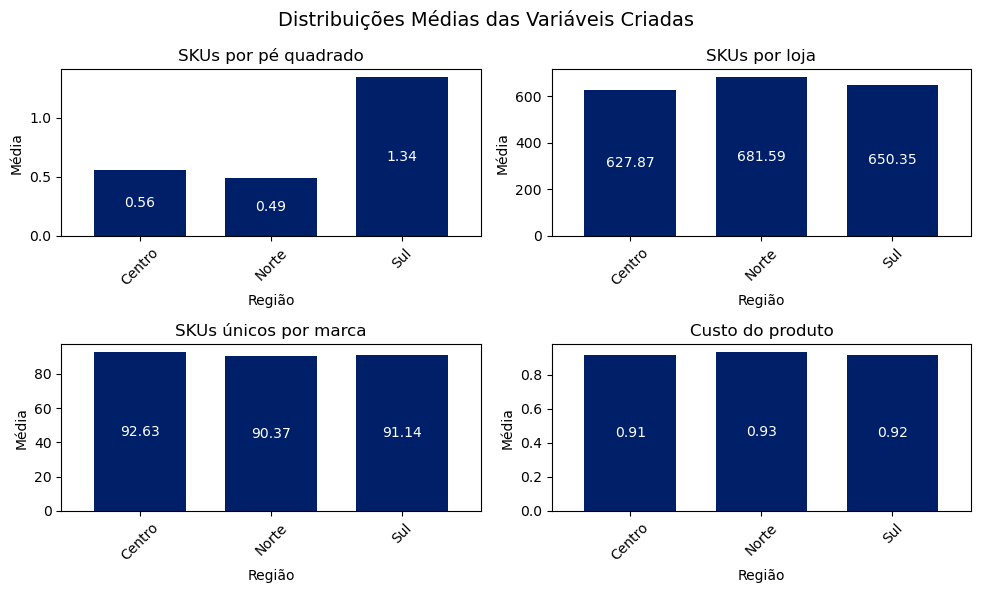

In [462]:
cols = ['skus_per_ft', 'skus_per_store', 'unique_skus_brand', 'product_cost']

mean_values = df.groupby('region')[cols].mean()

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

metric_titles = ['SKUs por pé quadrado', 'SKUs por loja', 'SKUs únicos por marca', 'Custo do produto']

for i, (ax, col, title) in enumerate(zip(axes.flatten(), cols, metric_titles)):
    bars = mean_values[col].plot(kind='bar', ax=ax, color='#001F69', width=0.7)
    ax.set_title(title)
    ax.set_xlabel('Região')
    ax.set_ylabel('Média')
    ax.set_xticklabels(mean_values.index, rotation=45)
    for j, value in enumerate(mean_values[col]):
        ax.text(j, value / 2, str(round(value, 2)), ha='center', va='center', color='white')

plt.suptitle('Distribuições Médias das Variáveis Criadas', fontsize=14, color='black')
plt.tight_layout()
plt.show()

Através da análise do gráfico anterior, conclui-se:

- A região Sul tem uma média de 'SKUs per Feet' significativamente maior (1.34), mais do dobro das médias do Centro (0.56) e do Norte (0.49);
- Em SKUs por loja, o Norte lidera com 681.59, seguido pelo Sul com 650.35 e o Centro com 627.87;
- A diferença entre o Norte e o Centro em SKUs por loja é de cerca de 8.5%, indicando maior quantidade por loja de produtos com o desconto aplicado no Norte;
- A média de SKUs únicos por marca é muito próxima entre as regiões, com o Centro a liderar ligeiramente (92.63), seguido pelo Sul (91.14) e depois o Norte (90.37);
- As diferenças nos SKUs únicos por marca são pouco significativas, sugerindo uma oferta de marcas relativamente uniforme.
- O custo médio do produto é ligeiramente mais alto no Norte (0.93), seguido pelo Sul (0.92) e o Centro (0.91).

#### 3.2.5.2 Variáveis Categóricas

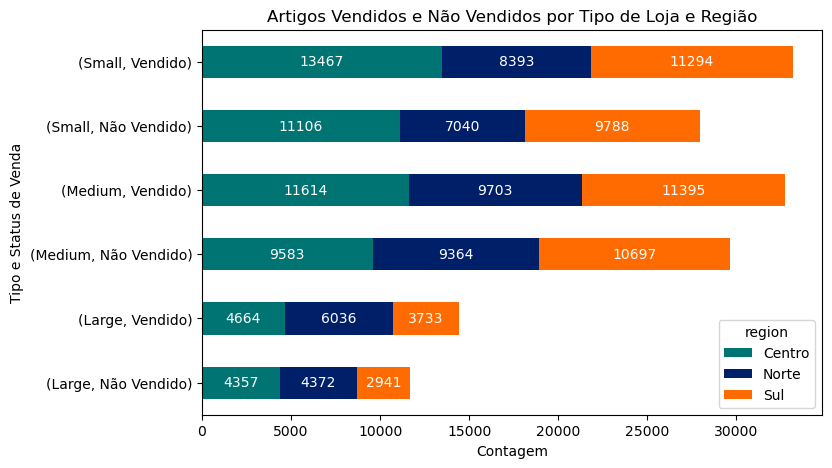

In [463]:
count_data = df.groupby(['type', df['sold'].replace({0: "Não Vendido", 1: "Vendido"}), 'region']).size().unstack(fill_value=0)

ax = count_data.plot(kind='barh', stacked=True, color=['#007473', '#001F69', '#FF6B00'], figsize=(8, 5))

for container in ax.containers:
    for bar in container:
        width = bar.get_width()
        if width > 0:
            x_pos = bar.get_x() + width / 2
            y_pos = bar.get_y() + bar.get_height() / 2
            ax.text(x_pos, y_pos, f'{int(width)}', ha='center', va='center', color='white', fontsize=10)

plt.xlabel("Contagem")
plt.ylabel("Tipo e Status de Venda")
plt.title("Artigos Vendidos e Não Vendidos por Tipo de Loja e Região")
plt.show()

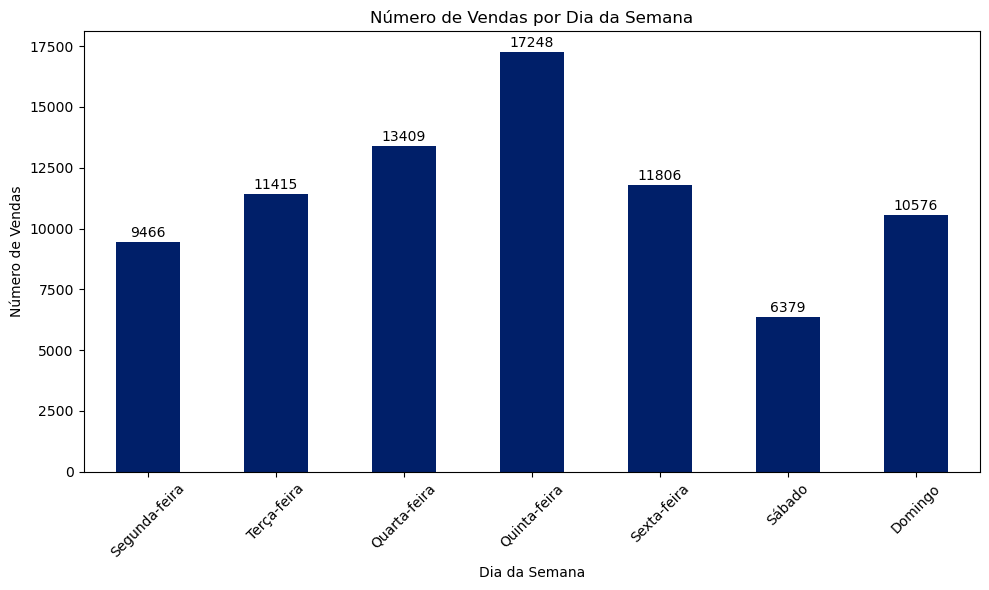

In [194]:
day_mapping = {0: 'Segunda-feira', 1: 'Terça-feira', 2: 'Quarta-feira', 3: 'Quinta-feira',
               4: 'Sexta-feira', 5: 'Sábado', 6: 'Domingo'}

sales_by_day = df.groupby('labelling_day_of_week')['sold'].sum()

sales_by_day.index = sales_by_day.index.map(day_mapping)

plt.figure(figsize=(10, 6))
sales_by_day.plot(kind='bar', color='#001F69')

plt.title('Número de Vendas por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Número de Vendas')

for i, value in enumerate(sales_by_day):
    plt.text(i, value + 200, str(value), ha='center')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Nos gráficos de barras anteriores podemos verificar que:
- A quantidade de produtos em final de validade e onde foi aplicado desconto é superior nas lojas de tipo __Medium__ e __Small__ menos representado no dataset é 'Large';
- Existe maior domínio destes produtos na região Centro;
- O dia da semana com mais produto rotulado com desconto é a __Quinta-Feira__.

<div class="alert alert-block alert-info">

<a id='new'></a>

### 3.2.6. Outliers
    
</div>

Na secção 2, concluímos a existência de outliers para as variáveis `Profit (€)` e `selling_square_ft`, sendo que diversas variáveis numéricas não foram analisadas nesse momento por não estarem categorizadas como tal ou ainda não terem sido criadas:

#### 3.2.6.1 Análise de skewness e kurtosis

In [199]:
df.skew(numeric_only=True)

oldpvp                      5.145517
weight (g)                  0.524855
Margin (%)                 -0.371813
Profit (€)                  1.197624
perc_expiring_sku           0.207792
sold                       -0.148200
selling_square_ft           1.176166
new_pvp                     1.381423
discount                    3.376210
labelling_days_until_exp    6.855502
skus_per_ft                 6.398776
skus_per_store              2.182509
unique_skus_brand          -0.954862
product_cost                1.401147
dtype: float64

Ao realizar novamente a análise de skewness, verificamos que:
- `Skewness Elevado (superior a |1.0|)`: oldpvp, Profit (€), selling_square_ft, new_pvp , discount, labelling_days_until_exp, skus_per_ft,skus_per_store e product_cost
- `Skewness Moderado (entre |0.5| e |1.0|)`: weight (g), unique_skus_brand e product_cost

In [201]:
df.kurtosis(numeric_only=True)

oldpvp                      260.938506
weight (g)                    2.307579
Margin (%)                   -1.262098
Profit (€)                    3.816302
perc_expiring_sku            -0.420163
sold                         -1.978063
selling_square_ft             0.905701
new_pvp                       9.464847
discount                     24.742544
labelling_days_until_exp     71.062888
skus_per_ft                  41.785595
skus_per_store                6.518503
unique_skus_brand            -1.045601
product_cost                 10.355974
dtype: float64

Relativamente à kurtosis, reforça-se a suspeita de presença de outliers nas variáveis: oldpvp, Profit (€), new_pvp, discount, labelling_days_until_exp, skus_per_ft, skus_per_store e product_cost devido ao elevado valor (superior a 3.0).

#### 3.2.6.2 Análise Visual de Outliers

In [204]:
def hist_boxplot_display(df, columns):
    for coluna in columns:
        fig, axes = plt.subplots(1, 3, figsize=(15, 3))  

        sns.histplot(df[coluna].dropna(), bins=30, kde=True, ax=axes[0])
        axes[0].set_title(f"Histograma - {coluna}")

        sns.boxplot(x=df[coluna].dropna(), ax=axes[1])
        axes[1].set_title(f"Boxplot - {coluna}")

        sns.kdeplot(df[coluna].dropna(), ax=axes[2], fill=True)
        axes[2].set_title(f"KDE - {coluna}")

        plt.tight_layout()
        plt.show()

In [205]:
columns = ['oldpvp', 'Profit (€)', 'selling_square_ft',
           'new_pvp' , 'discount', 'labelling_days_until_exp',
           'skus_per_ft','skus_per_store','weight (g)', 'unique_skus_brand','product_cost']

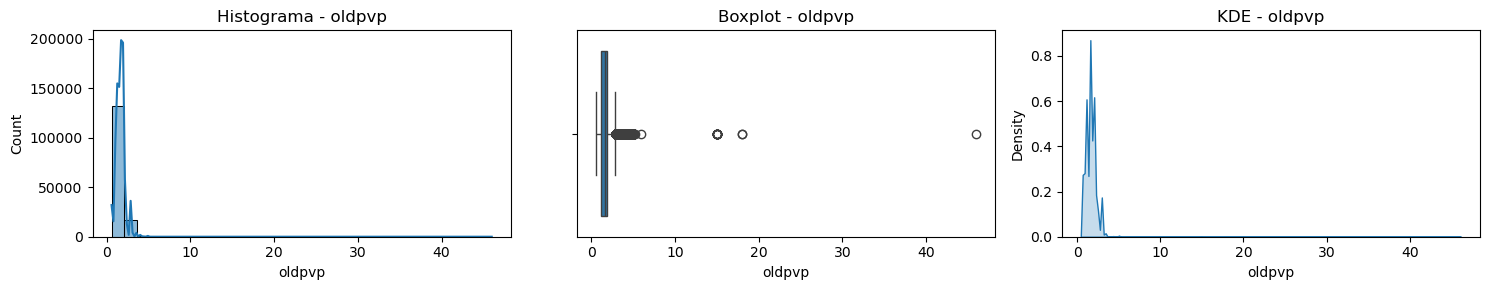

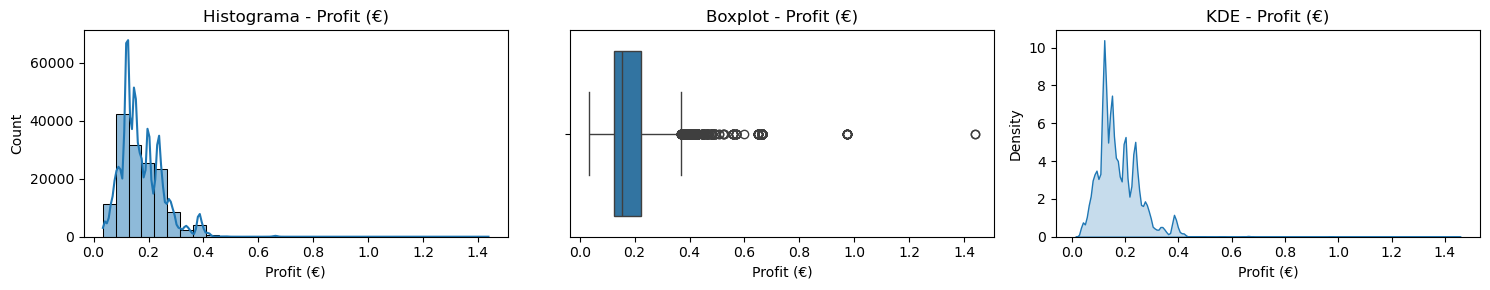

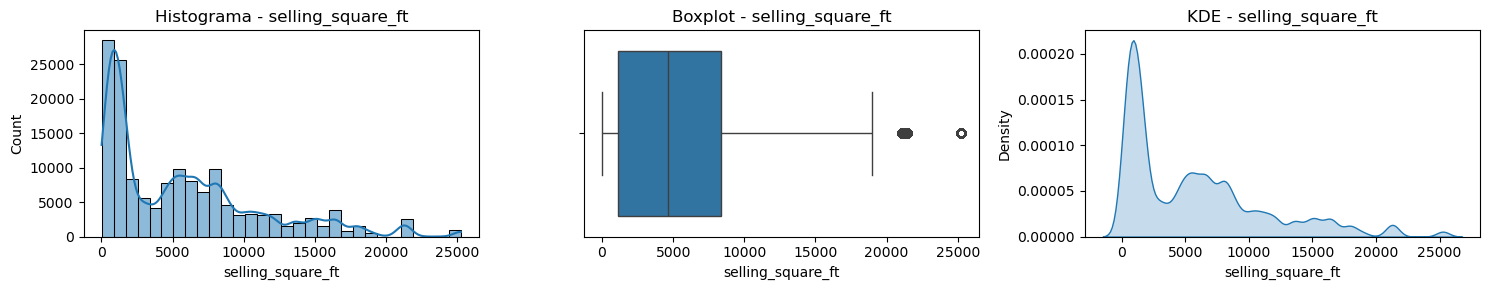

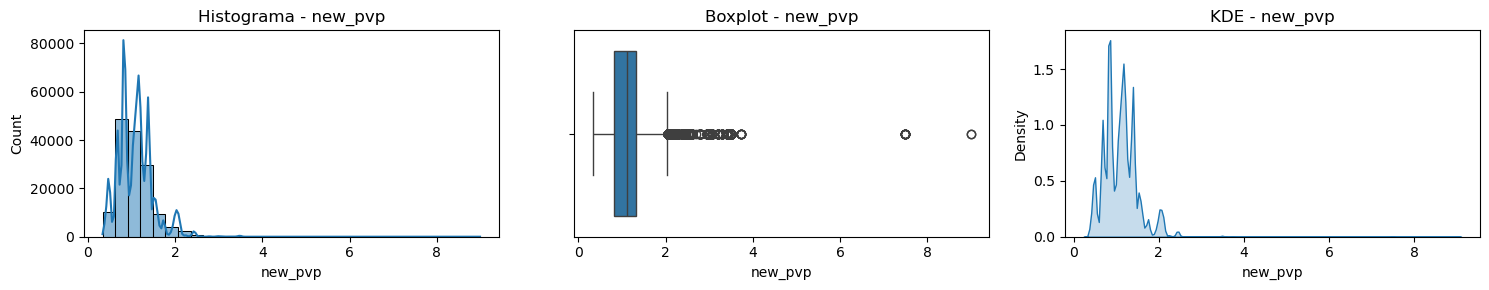

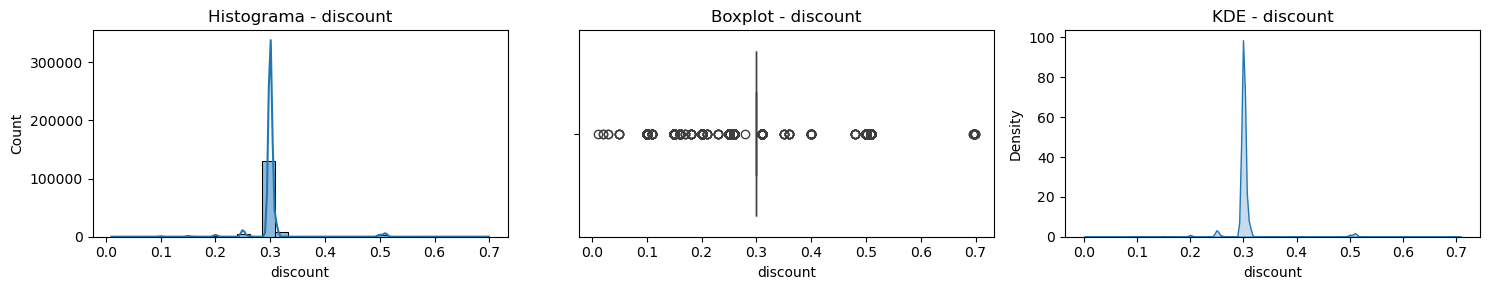

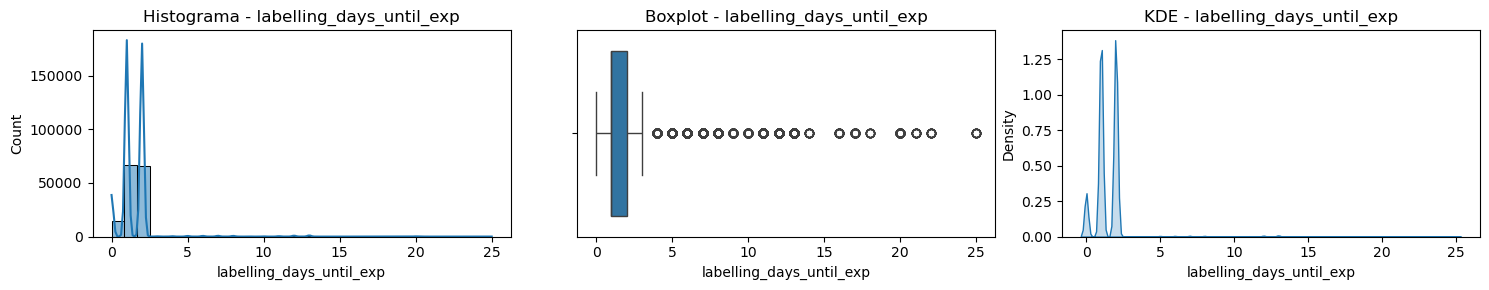

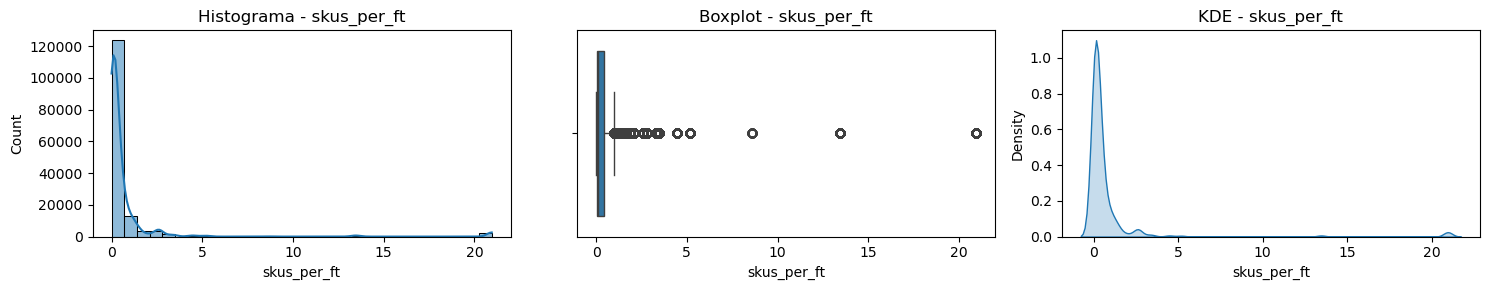

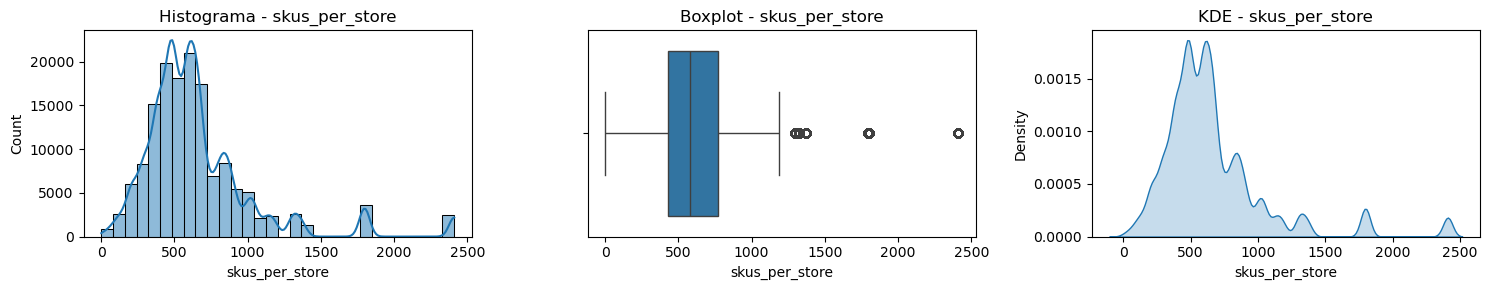

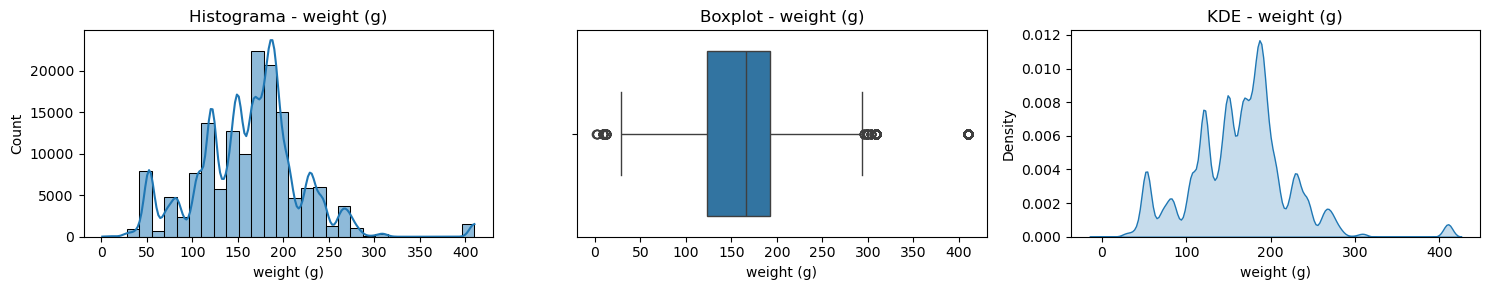

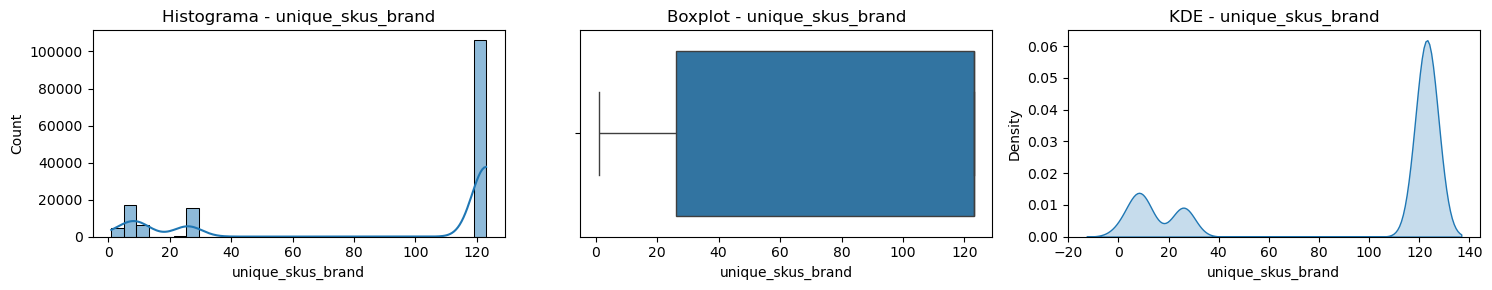

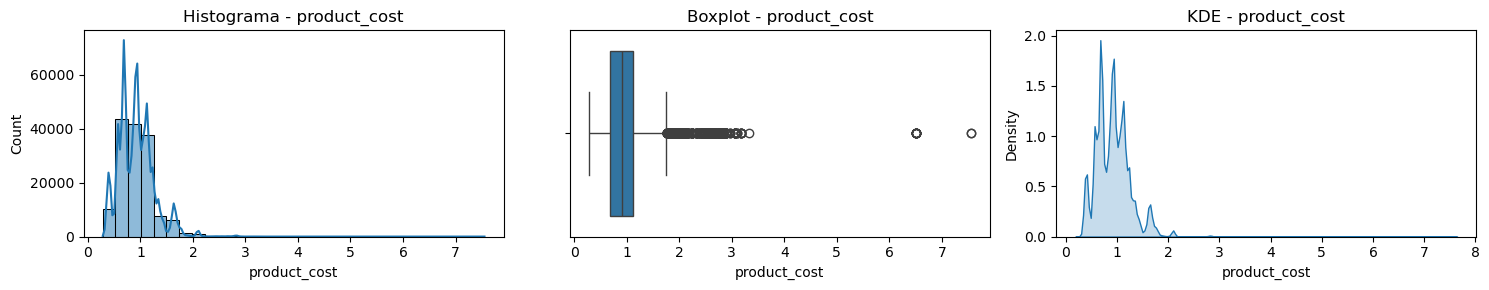

In [206]:
hist_boxplot_display(df, columns)

Verifica-se a presença de outliers apenas na variável 'oldpvp' acima de 10 e que serão eliminados. <br>
Devido à grande densidade de pontos nos quartis do boxplot, a mediana e os quartis ajustam-se a essa concentração, fazendo com que valores legítimos, mas mais afastados, pareçam outliers sem realmente serem.


In [208]:
df_no_outliers = df.drop(df[df["oldpvp"] > 10].index)

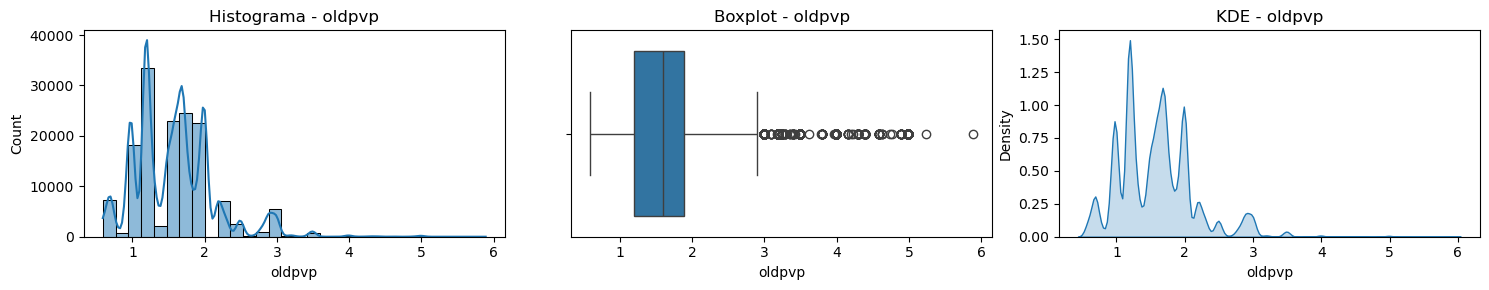

In [209]:
hist_boxplot_display(df_no_outliers,['oldpvp'])

<div class="alert alert-block alert-info">

<a id='new'></a>

### 3.2.7. Scalling
    
</div>

Uma vez que os dados não apresentam uma distribuição uniforme, não seria boa prática identificar outliers, visto que determinados registos poderiam parecer anormais simplesmente devido à grande concentração de outros dados. Por essa razão, antes de analisar o que são ou não outliers, proceder-se-á ao escalonamento dos dados, para só depois identificar os outliers.

In [212]:
def scale_data_log(df, columns):
    df_scaled = df.copy()

    for column in columns:
        df_scaled[f"{column}_log_scaled"] = np.log1p(df_scaled[column])
    
    return df_scaled

In [213]:
def apply_log_scaling(df, columns, epsilon=0.000001):
    df1 = df.copy()
    for col in columns:
        if col in df1.columns:
            df1[col] =(df1[col] + epsilon)
    return df1

In [214]:
numerical_columns = df.select_dtypes(include='number').columns.tolist()

In [215]:
df_no_outliers=apply_log_scaling(df_no_outliers,['labelling_days_until_exp'])

In [216]:
columns = df_no_outliers.select_dtypes(include='number').columns.tolist()
df_scaled = scale_data_log(df_no_outliers, columns)

In [217]:
columns = df_scaled.select_dtypes(include='number').columns.tolist()

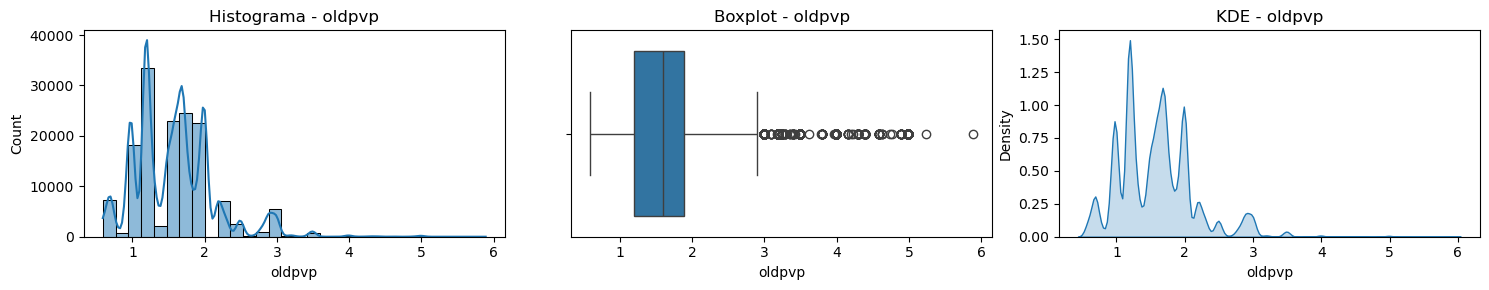

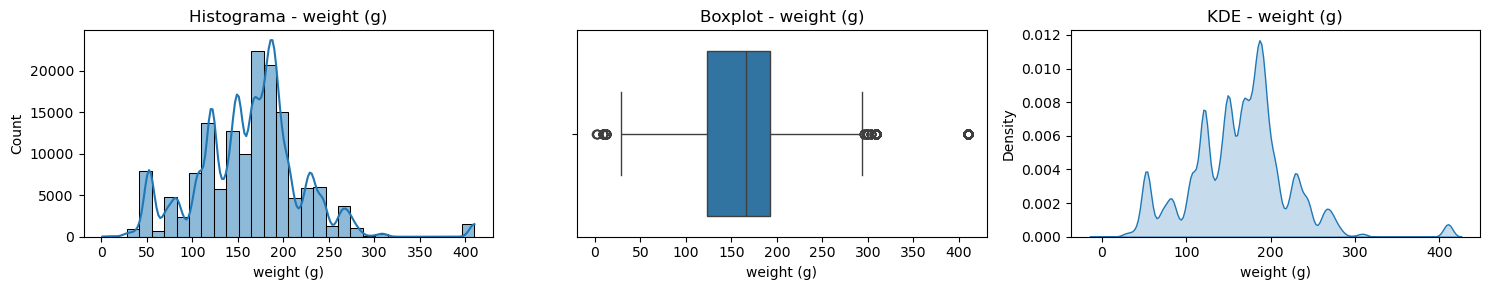

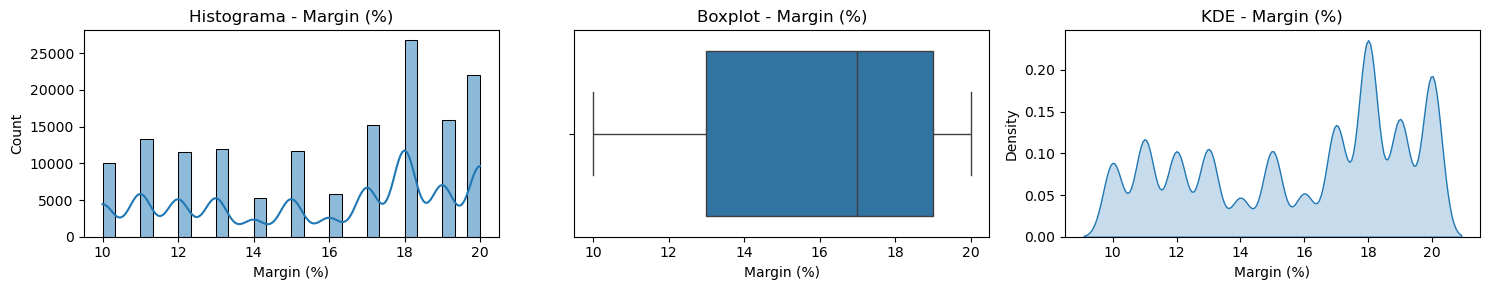

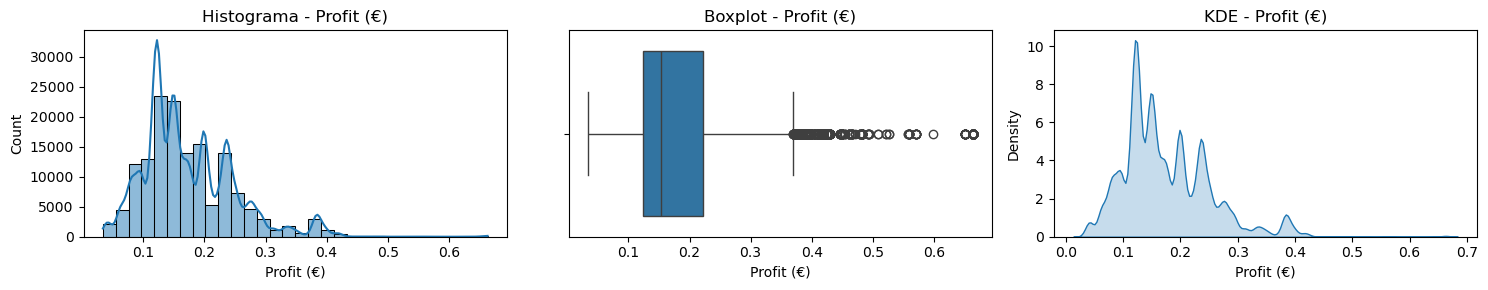

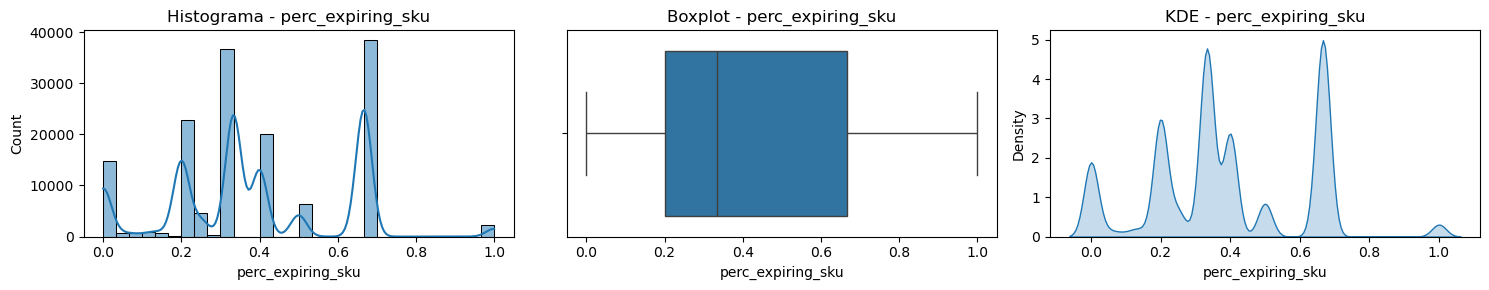

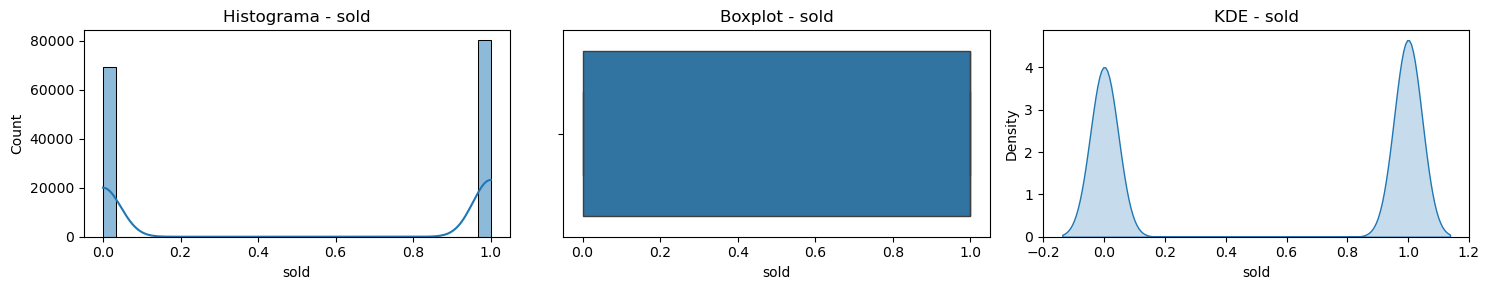

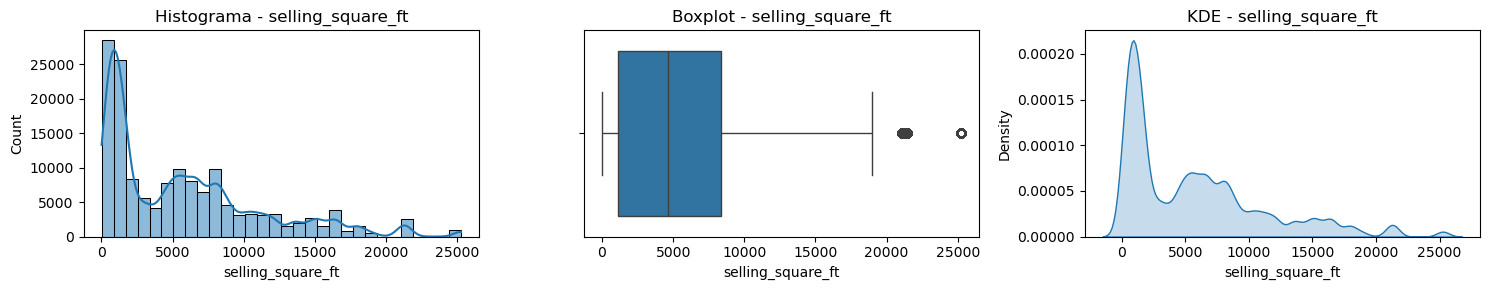

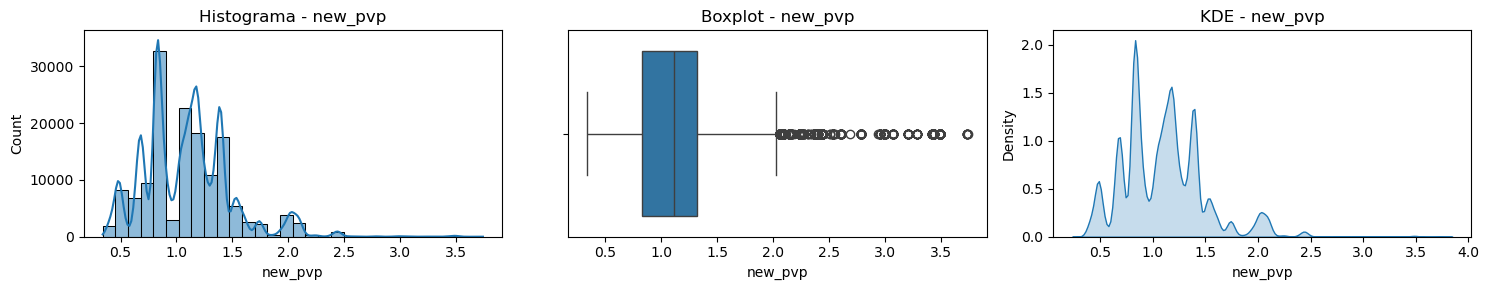

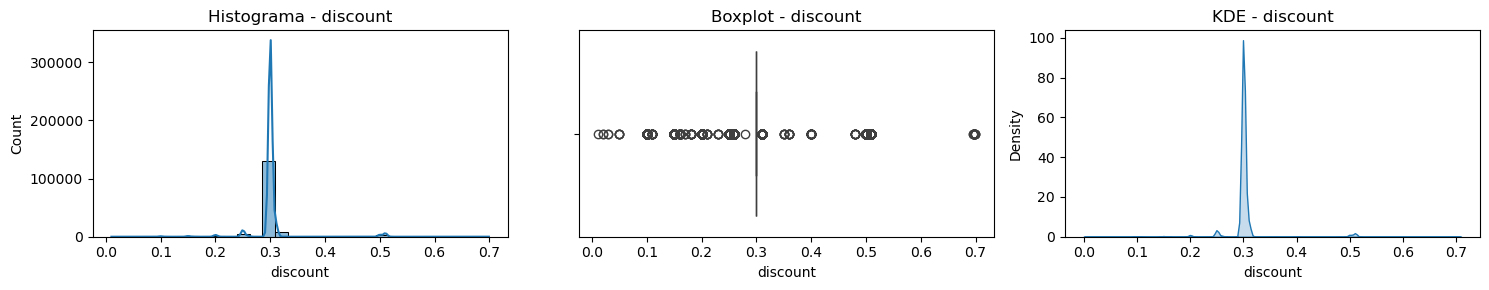

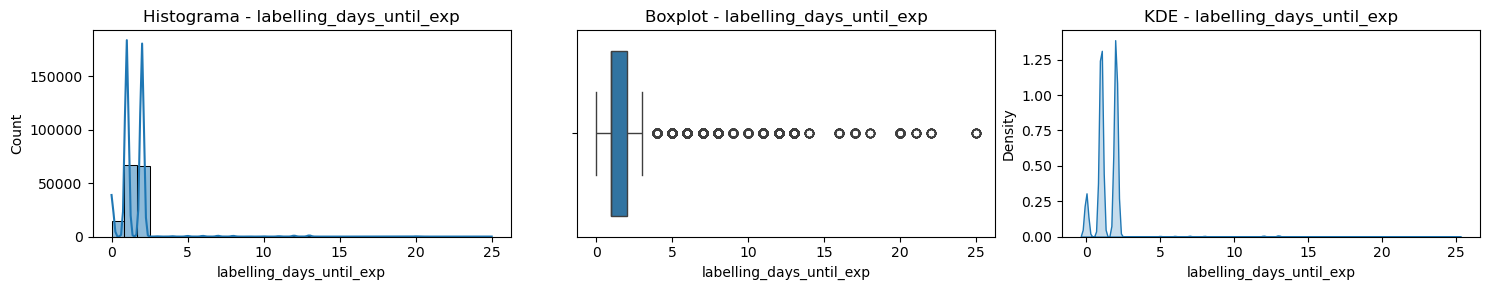

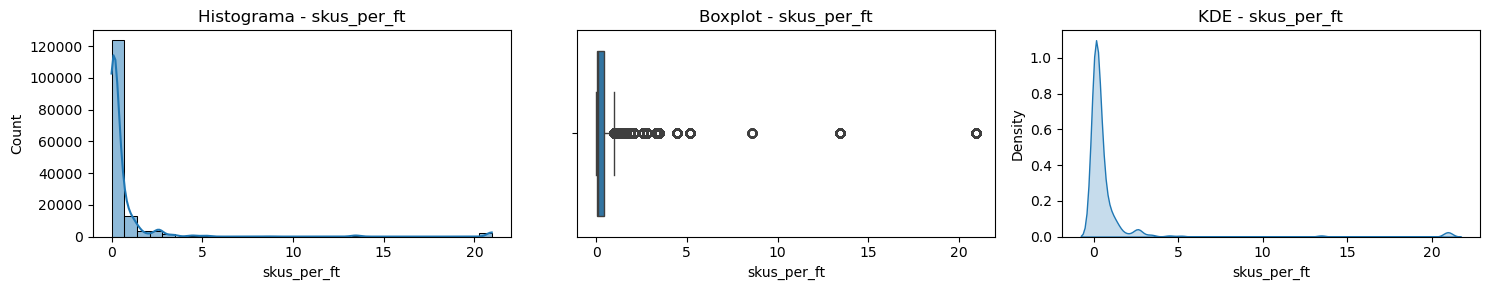

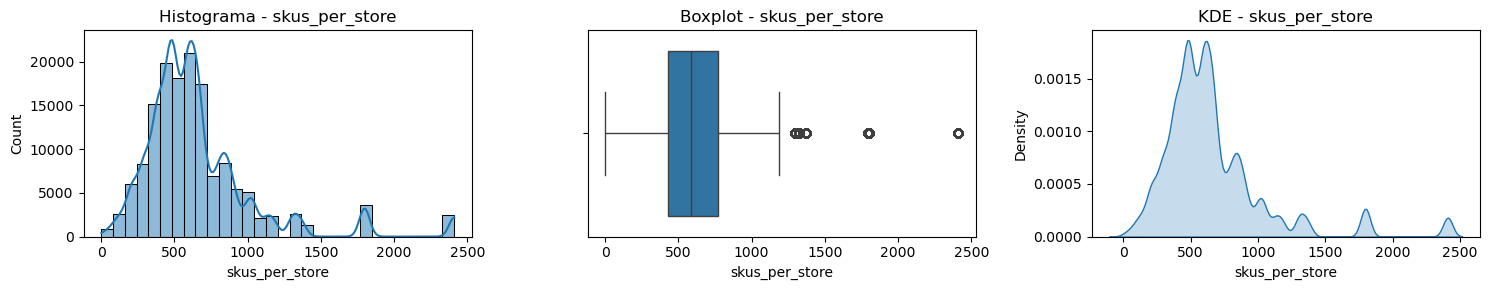

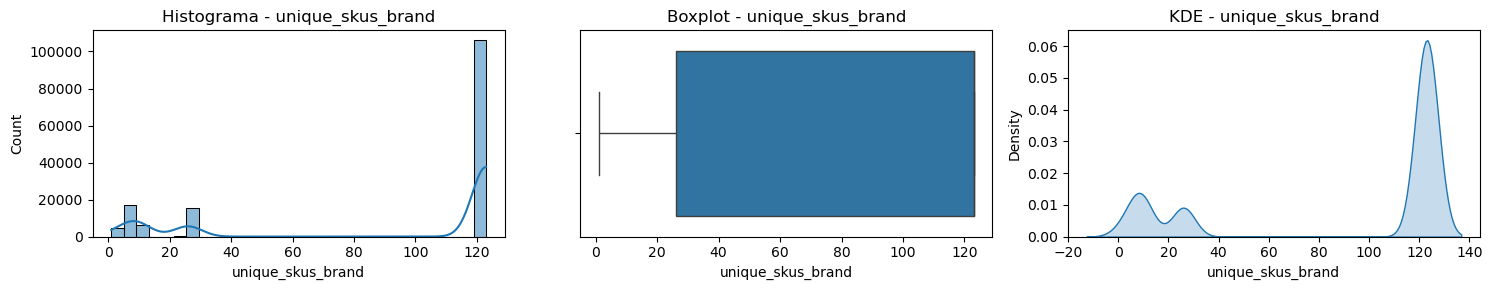

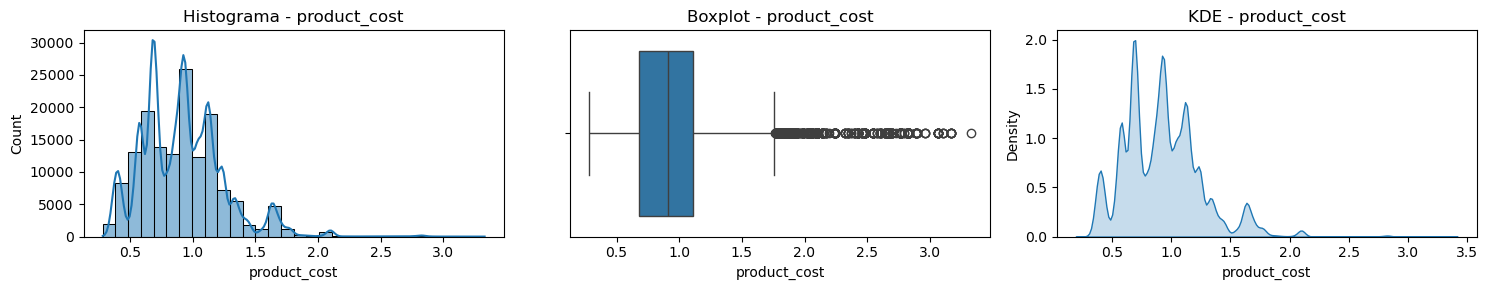

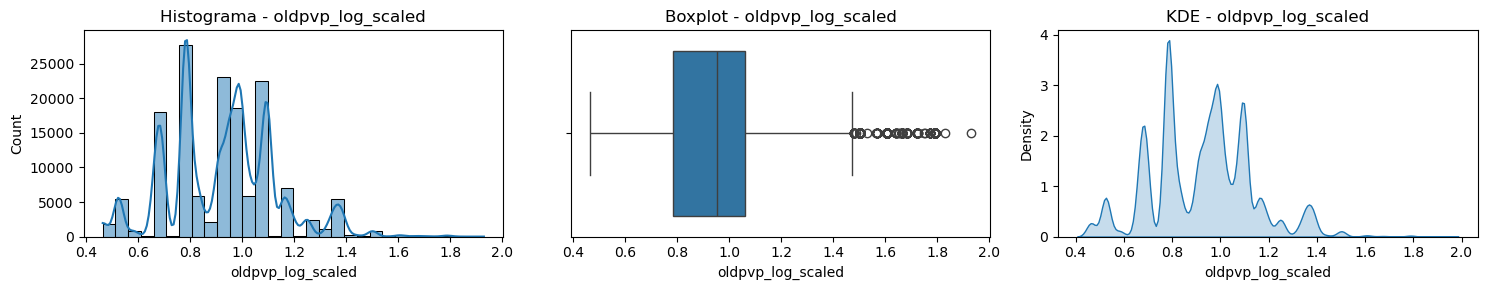

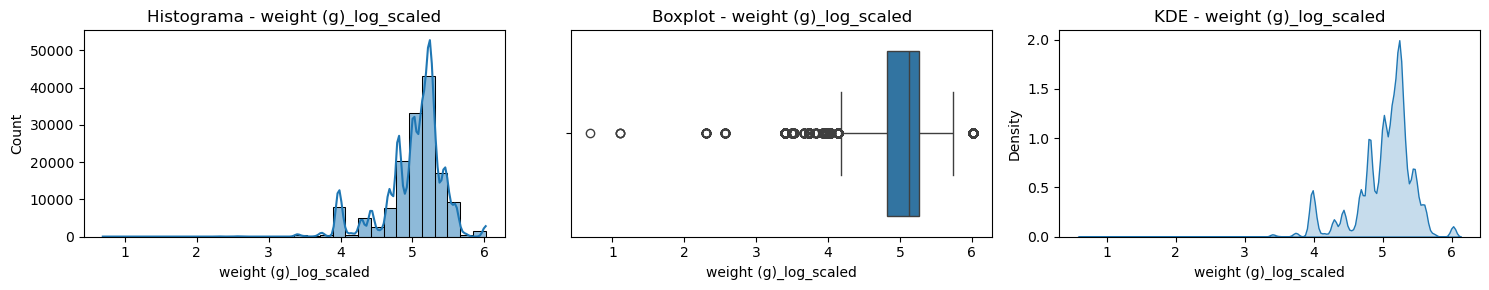

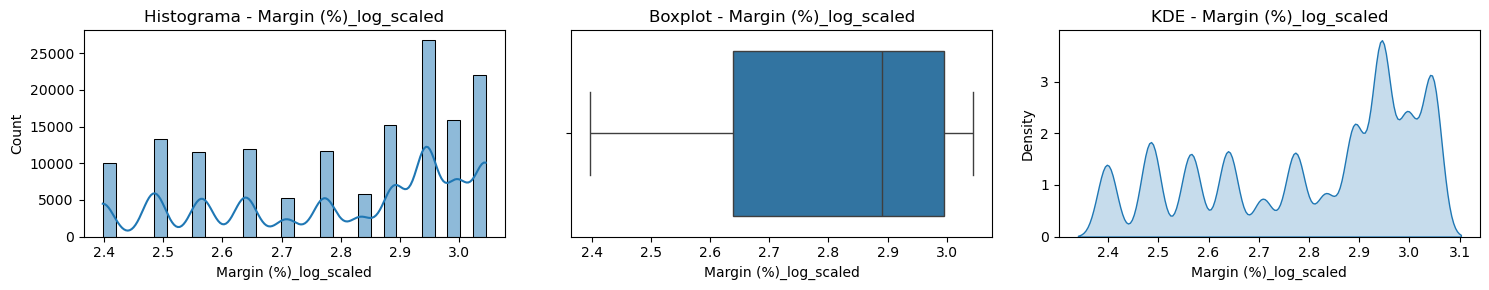

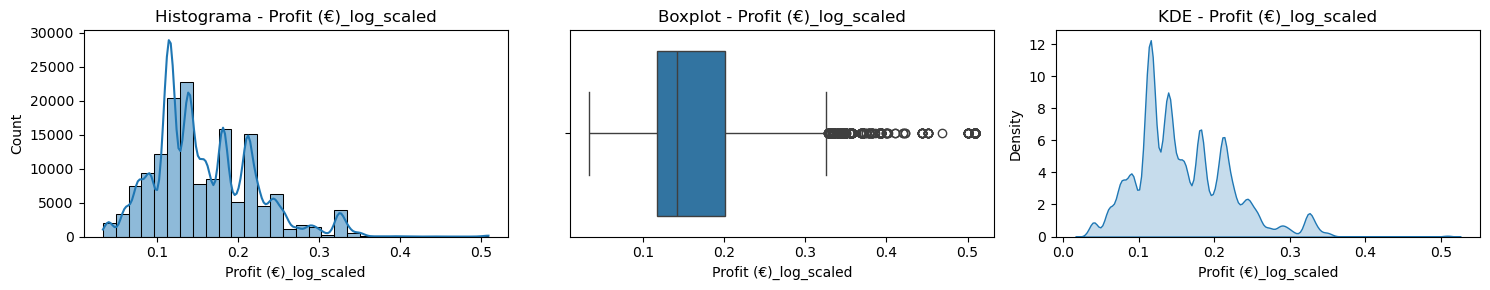

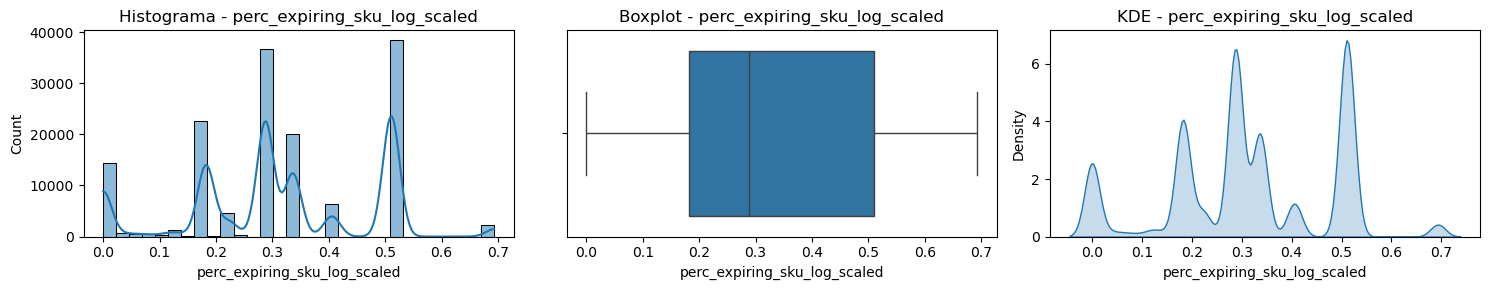

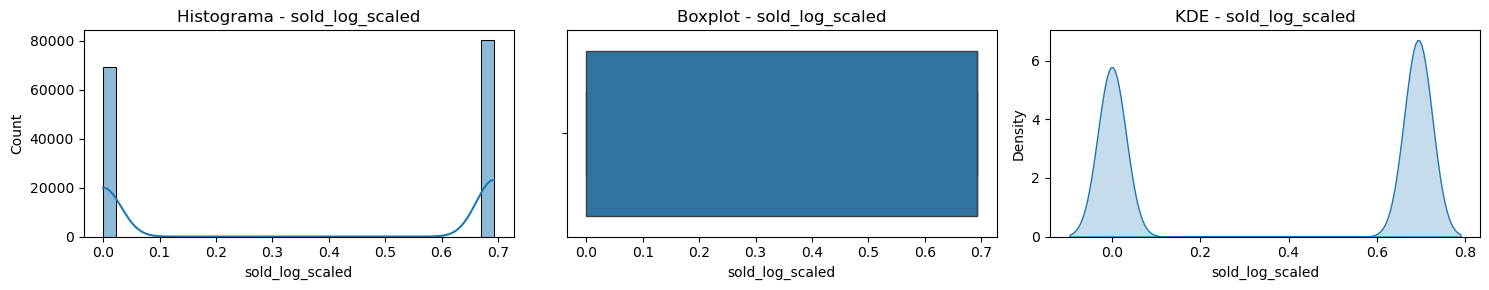

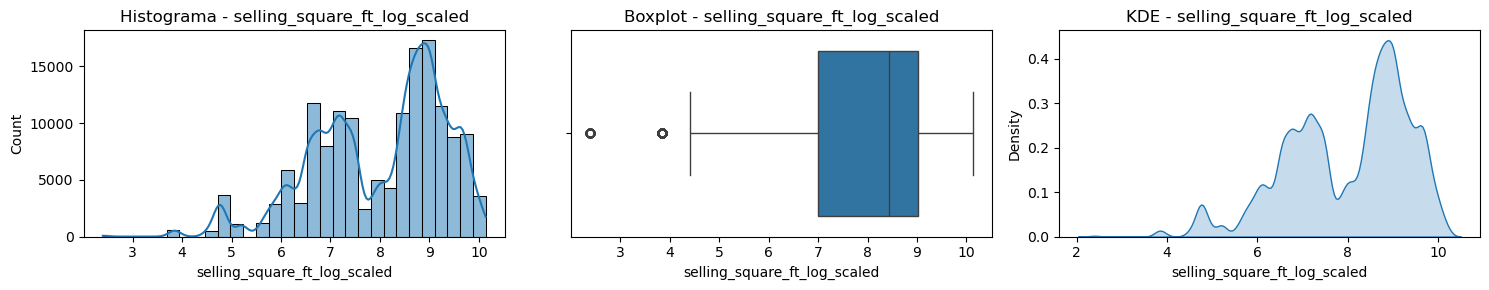

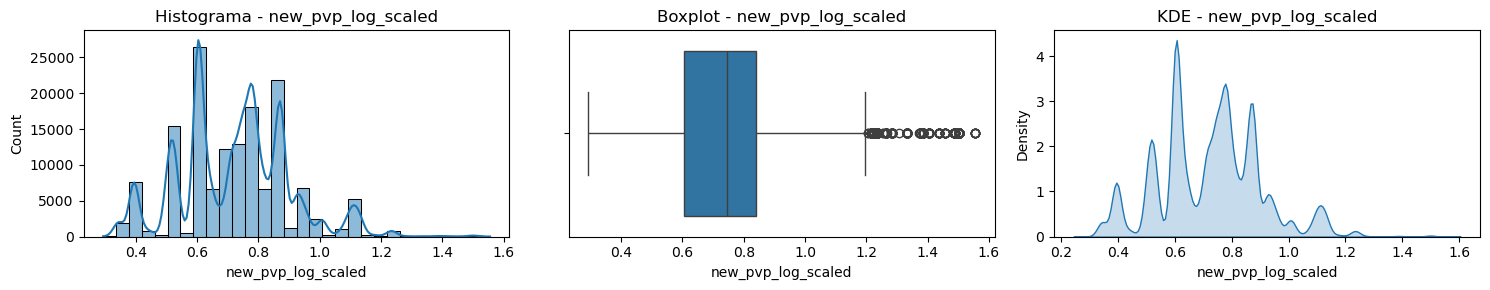

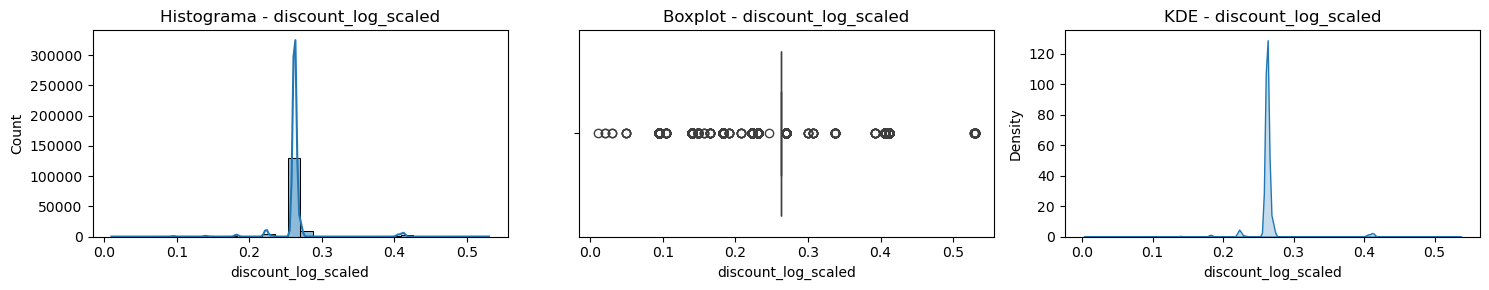

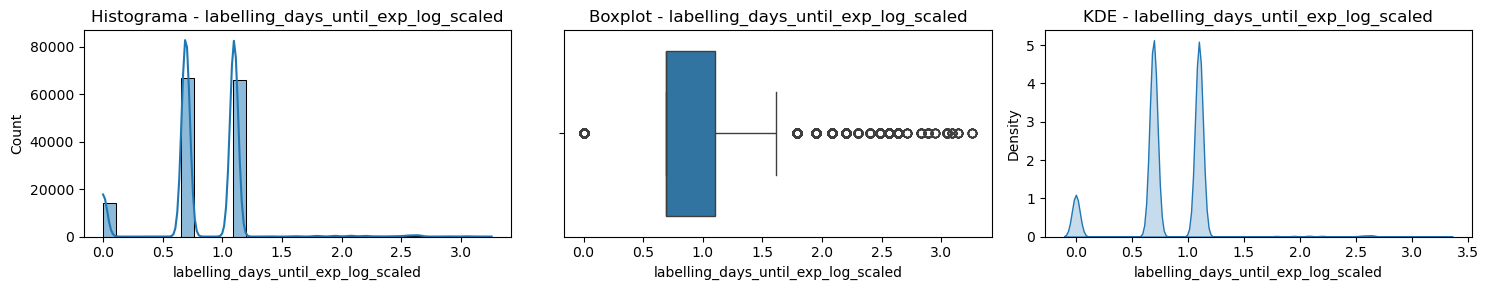

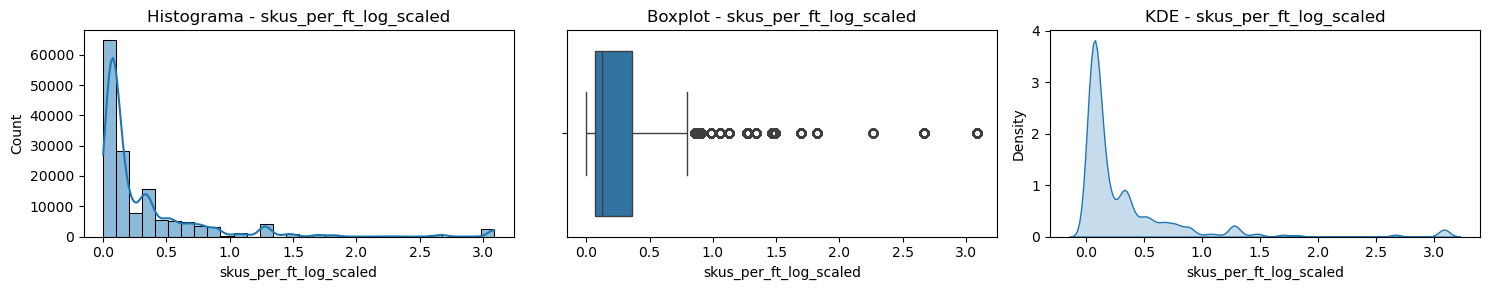

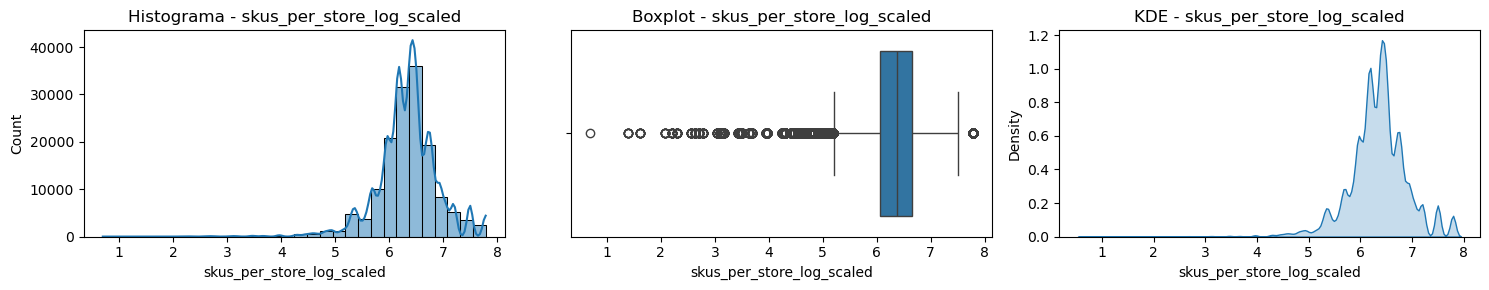

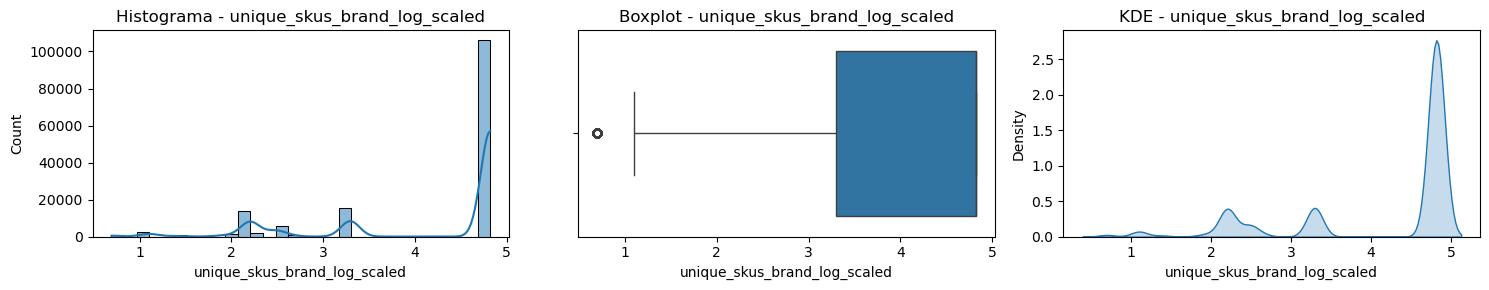

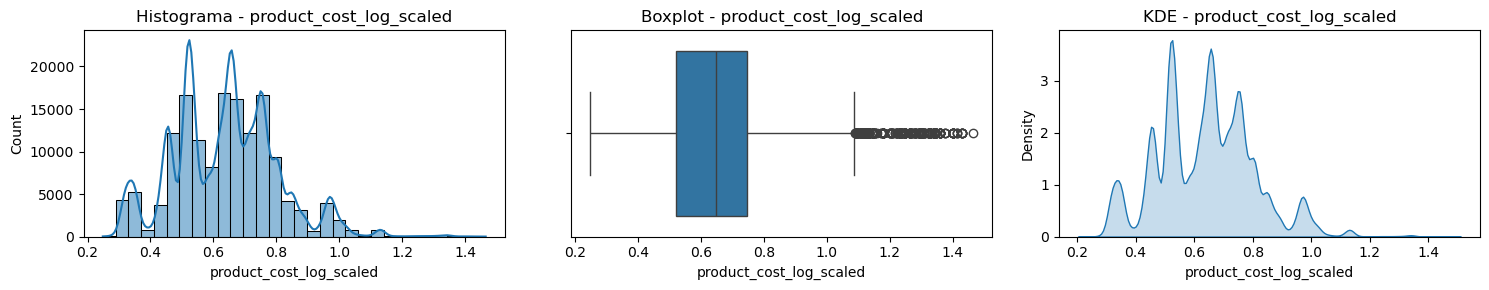

In [218]:
hist_boxplot_display(df_scaled, columns)

<div class="alert alert-block alert-success">
<a id='preprocess'>
<font color = '#006400'> 
    
# 4. Seleção de Variáveis (Feature Selection)
</a>
    
</div>

Nesta secção, após finalizados os passos de preparação do dataset, é necessário efetuar a seleção das variáveis que possuem poder preditivo da variável target, isto é, se o produto vai ser vendido ou não.

In [221]:
df_most_recent= df_no_outliers.copy()

<div class="alert alert-block alert-warning">

<a id='visual'></a>

## 4.1. Preparação de Dados: Separação Treino - Teste 
    
</div> 

Antes da selecção de variáveis para o modelo de previsão, é necessário efetuar a separação dos dados de treino e teste. O modo de separação pode ser efetuado através de vários métodos, sendo que no caso de estudo será utilizado o `K-Fold Cross-Validation`, especificamente o de tipologia 'Stratified', garantindo que a distribuição das classes seja aproximadamente a mesma em cada "fold" (divisão).

Os hiperparâmetros de inicialização usados para o modelo de `K-Fold Cross-Validation` são os seguintes:
- `Nº de separações` (n_splits) = 7
- `Repetibilidade` (random_state = 99)
- `Dados baralhados` (shuffle = True)

In [225]:
skf = StratifiedKFold(n_splits = 7, random_state = 99, shuffle = True)

De seguida efetua-se a separação de variáveis independentes (x) e target (y) em 2 dataframes separados:

In [227]:
X = df_most_recent.drop('sold', axis = 1)
y = df_most_recent['sold'].copy()

Por fim, efetua-se a separação de __dados de treino__ (90%) e __teste__ (10%):

In [229]:
X, X_test, y, y_test = train_test_split(X, y,
                                        train_size = 0.9,
                                        random_state = 99,
                                        stratify = y)

Para os passos seguintes, os dados vão ser tratados como dois conjuntos independentes: o conjunto de __treino__ e o conjunto de __teste__.




<div class="alert alert-block alert-warning">

<a id='visual'></a>

## 4.2. Selecção de Variáveis (Feature Selection)
    
</div> 

A seleção de variáveis para o modelo será feita através dos seguintes métodos:

- __Chi-Square (Filter Method)__ -- *Variáveis Categóricas*
- __Variance (Filter Method)__ -- *Variáveis Contínuas, Ordinais e Binárias*
- __Spearman Correlation (Filter Method)__ -- *Variáveis Contínuas e Ordinais*
- __Recursive Feature Elimination (RFE) (Wrapper Method)__ -- *Variáveis Contínuas, Ordinais e Binárias*
- __Lasso Regression (Embedded Method)__ -- *Variáveis Contínuas e Ordinais*
- __Decision Trees (Embedded Method)__ -- *Variáveis Contínuas, Ordinais e Binárias*
  

Serão aplicadas as técnicas de seleção de características na seguinte ordem: <br> 

(1) __Variância__ - Para detectar a existência de variáveis constantes; <br> 
(2) __Correlação de Spearman__ - Para detectar a existência de variáveis correlacionadas;<br> 
(3) __Árvores de Decisão__ - Para manter apenas uma variável de um grupo de variáveis correlacionadas;<br> 
(4) __RFE__ - Para selecionar iterativamente as características, considerando subconjuntos delas;<br> 
(5) __Lasso__ - Para identificar e selecionar as características importantes em um conjunto de dados;<br>

A aplicação de selecção do `Feature Selection` obriga à identificação e aplicação de técnicas específicas para cada tipo de cada variável. <br>
Segue-se uma lista das variáveis em análise:

|# |Predictor                              | Data Type   |
|--|---------------------------------------|-------------|
|0 |oldpvp                                 | Numerical   |
|1 |weight (g)                             | Numerical   |
|2 |Margin (%)                             | Numerical   |
|3 |Profit (€)                             | Numerical   |
|4 |perc_expiring_sku                      | Numerical   |
|5 |sold ----> __VÁRIAVEL TARGET__         | Binary      |
|6 |type                                   | Categorical |
|7 |selling_square_ft                      | Numerical   |
|8 |new_pvp                                | Numerical   |
|9 |discount                               | Numerical   |
|10|labelling_days_until_exp               | Numerical   |
|11|region                                 | Categorical |
|12|marca_2                                | Categorical |
|13|skus_per_ft                            | Numerical   |
|14|skus_per_store                         | Numerical   |
|15|labelling_day_of_week                  | Categorical |
|16|unique_skus_brand                      | Numerical   |
|17|product_cost                           | Numerical   |

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 4.2.1. Variáveis Categóricas -  Chi-Square (Filter Method)

</div>

De forma a validar a utilização das variáveis categóricas, proceder-se-á ao teste `Chi-Square` para entender quais se devem manter:

In [237]:
def apply_chisquare(X,y,var,alpha=0.05):
    dfObserved = pd.crosstab(y,X)
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} é IMPORTANTE para a Previsão".format(var)
    else:
        result="{0} não é IMPORTANTE para a Previsão. (Descartar {0} do modelo)".format(var)
    print(result)

In [238]:
def select_best_cat_features(X,y):
    count = 1
    ############################################## APPLY SKF ######################################################
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        #################################### SELECT FEATURES WITH CHI-SQUARE #######################################
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')
        
        X_train_cat = X_train[['type','region','labelling_day_of_week','marca_2']].copy()
        for var in X_train_cat:
            apply_chisquare(X_train_cat[var],y_train, var)
        count+=1

In [239]:
select_best_cat_features(X,y)

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________
type é IMPORTANTE para a Previsão
region é IMPORTANTE para a Previsão
labelling_day_of_week é IMPORTANTE para a Previsão
marca_2 é IMPORTANTE para a Previsão
_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________
type é IMPORTANTE para a Previsão
region é IMPORTANTE para a Previsão
labelling_day_of_week é IMPORTANTE para a Previsão
marca_2 é IMPORTANTE para a Previsão
_________________________________________________________________________________________________

                             

__O que se pode concluir?__

| Variável | Chi-Square | Estratégia?|
| --- | --- | --- |
| type | 10 SIM | Manter |
| region | 10 SIM | Manter |
| labelling_day_of_week | 10 SIM | Manter |
| marca_2 | 10 SIM | Manter |

Verifica-se que se deve manter todas as variáveis categóricas em análise.

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 4.2.2. Variáveis Numéricas -  Variance (Filter Method)

</div>

A variância das variáveis será estudada nesta fase para entender quais são constantes ou quase constantes, não servindo assim ao modelo de previsão:<br>

In [243]:
def apply_variance(X_train):
    variances = X_train.var(numeric_only=True)

    print("Variância por variável (formato 5 casas decimais):")
    print(variances.apply(lambda x: f"{x:.5f}"))

    return variances

In [244]:
def select_features_variance(X, y):
    results = []
    count = 1
    for train_index, val_index in skf.split(X, y):
        X_train = X.iloc[train_index]

        print('_________________________________________________________________________________________________\n')
        print(f'                                     SPLIT {count}                                    ')
        print('_________________________________________________________________________________________________')

        variances = apply_variance(X_train)
        results.append(variances)
        count += 1
    summary_df = pd.DataFrame(results).mean().reset_index()
    summary_df.columns = ["Variável", "Média da Variância"]
    summary_df["Média da Variância"] = summary_df["Média da Variância"].apply(lambda x: f"{x:.5f}")

    return summary_df


In [245]:
summary = select_features_variance(X, y)
print(summary)

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________
Variância por variável (formato 5 casas decimais):
oldpvp                             0.30534
weight (g)                      3326.56073
Margin (%)                        10.92776
Profit (€)                         0.00571
perc_expiring_sku                  0.04949
selling_square_ft           29712828.17834
new_pvp                            0.15054
discount                           0.00140
labelling_days_until_exp           1.75210
skus_per_ft                        7.88335
skus_per_store                148370.84467
unique_skus_brand               2460.79425
product_cost                       0.10560
dtype: object
_________________________________________________________________________________________________


__O que se pode concluir?__

- **Desconsiderar as variáveis com baixa variância (abaixo do limiar 0.01):** as variáveis `discount` e `Profit (€)`.

- **As variáveis com alta dispersão**, como `weight (g)`, `selling_square_ft`,`skus_per_store` e `unique_skus_brand` serão mantidas e analisadas em passos futuros para detectar a existência de uma forte correlação com a variável target e determinar se se mantêm. No caso de permanecerem, serão também normalizadas.


In [247]:
X = X.drop(['Profit (€)', 'discount'], axis = 1)

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 4.2.3. Análise de Correlações - Spearman (Filter Method)

</div>

A redundância de variáveis numéricas será analisada através da correlação de Spearman:

In [250]:
def cor_heatmap(cor):
    plt.figure(figsize=(9,6))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

In [251]:
def apply_correlation(X_train):
    correlation_data = X_train.copy()
    matrix = correlation_data.corr(method = 'spearman', numeric_only=True)
    cor_heatmap(matrix)

In [252]:
def redundant_features(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        ######################################### SELECT FEATURES #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')
        apply_correlation(X_train)
        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________


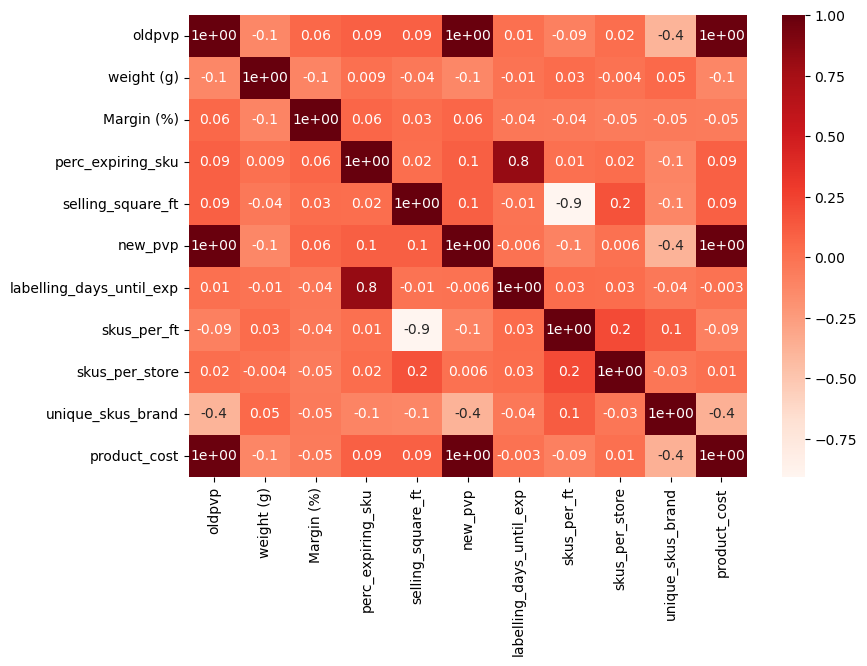

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________


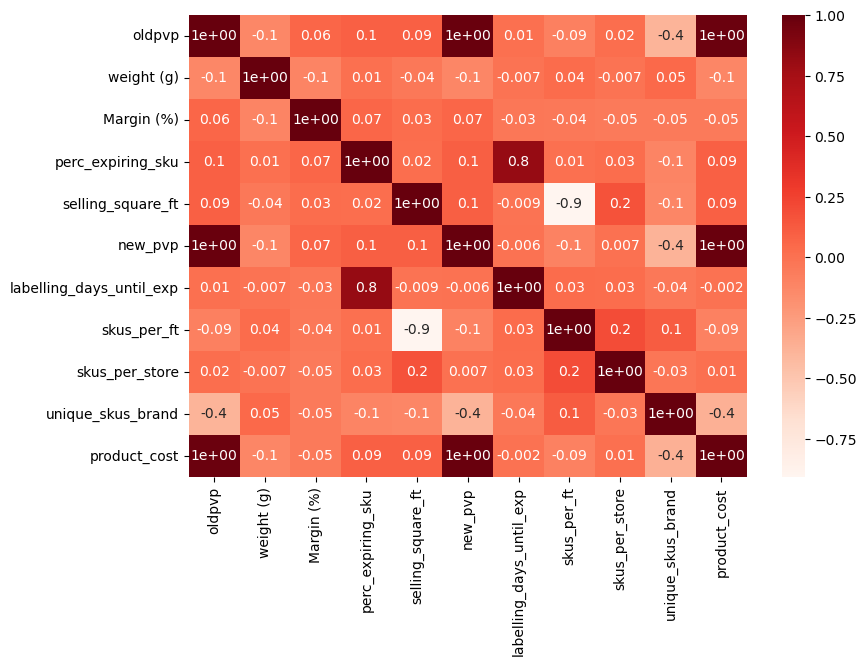

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________


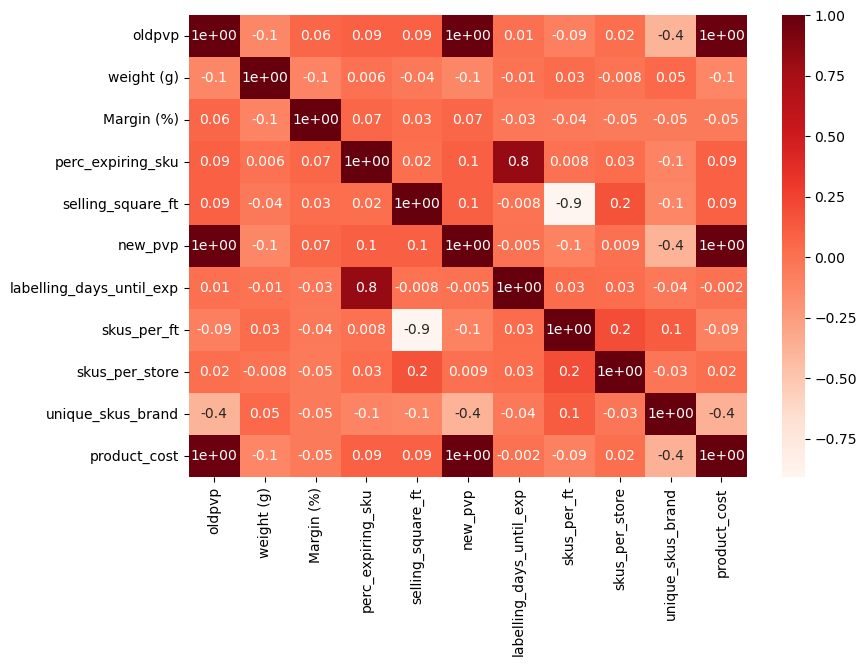

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________


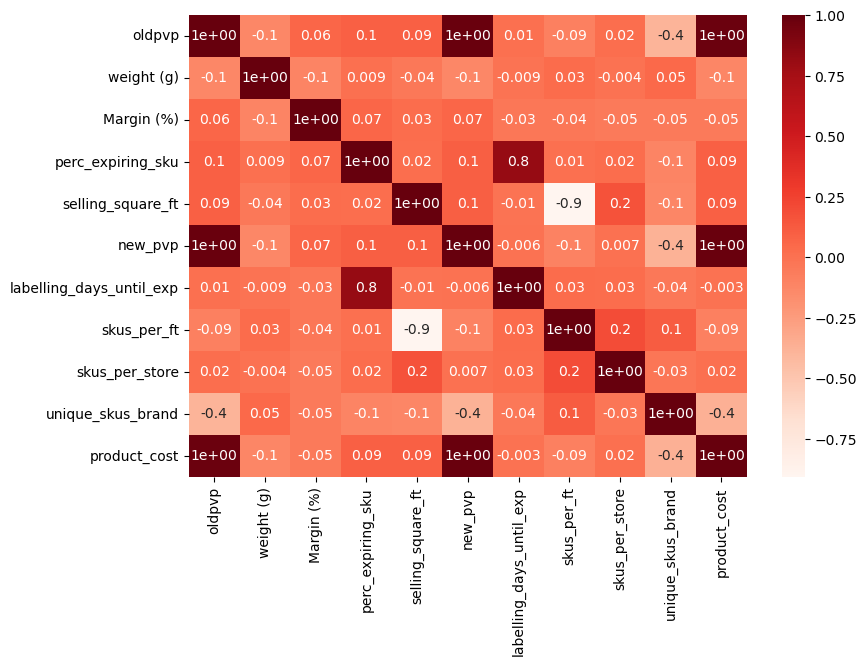

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________


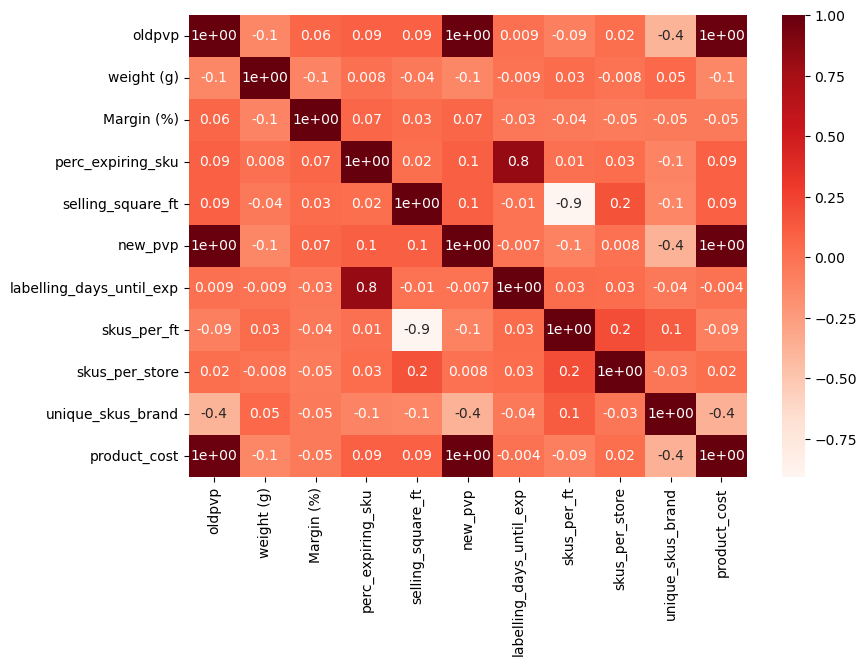

_________________________________________________________________________________________________

                                     SPLIT 6                                    
_________________________________________________________________________________________________


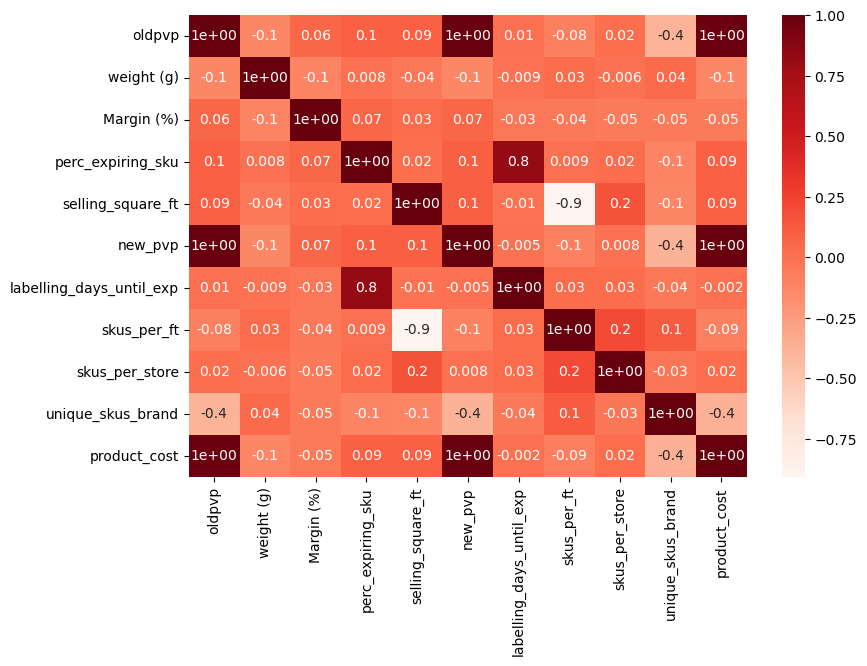

_________________________________________________________________________________________________

                                     SPLIT 7                                    
_________________________________________________________________________________________________


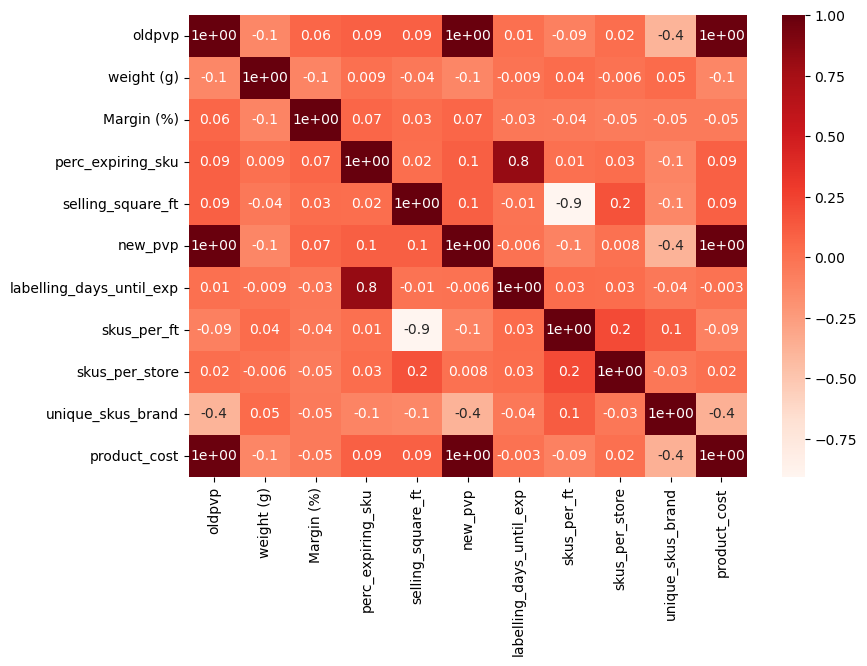

In [253]:
redundant_features(X, y)

__Variáveis Redundantes - Correlação de Spearman (Correlação superior a |0.8|)__ 

| Combinação                               | Split 1 | Split 2 | Split 3 | Split 4 | Split 5 | Split 6 | Split 7 | Split 8 | Split 9 | Split 10 |
| ------------------------------------------ | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | -------- |
| `oldpvp` vs `new_pvp` vs `product_cost`   | __1.0__ | __1.0__ | __1.0__ | __1.0__ | __1.0__ | __1.0__ | __1.0__ | __1.0__ | __1.0__ | __1.0__  |
| `selling_square_ft` vs `skus_per_ft`| -0.9     | -0.9     | -0.9     | -0.9     | -0.9     | -0.9     | -0.9     | -0.9     | -0.9     | -0.9  |
| `perc_expiring_sku` vs `labelling_days_until_exp` | 0.8     | 0.8     | 0.8     | 0.8     | 0.8     | 0.8     | 0.8     | 0.8     | 0.8     | 0.8  |



Neste caso, podemos verificar uma alta correlação entre as variáveis:
- `oldpvp` ,`new_pvp` e `product_cost`
- `selling_square_ft` e `skus_per_ft`
- `perc_expiring_sku`e `labelling_days_until_exp`

Neste momento será importante, dentro de cada conjunto, concluir quais manter e quais eliminar, uma vez que manter variáveis altamente correlacionadas pode trazer consequências aquando da modelação:

- **Multicolinearidade**: Instabilidade nos coeficientes do modelo e dificuldade na interpretação dos efeitos individuais;
- **Sobreajuste (Overfitting)**: O modelo pode ter baixa capacidade de generalização;
- **Redundância**: Variáveis semelhantes adicionam complexidade sem melhorar o desempenho do modelo.
- **Dificuldade na estimação dos coeficientes**: Pequenas variações nos dados podem levar a grandes mudanças nos coeficientes.

Por esta razão, proceder-se-á a uma análise de `Feature Importance` para determinar de entre as variáveis que estão altamente correlacionadas, quais são as que têm maior/menor importância, recorrendo a uma __Árvore de Decisão (Decision Tree).__

Com base nos resultados obtidos, proceder-se-á à eliminação das variáveis menos relevantes.

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 4.2.4. Selecção de Variáveis Correlacionadas- Decision Trees (Embedded Method)

</div>

In [258]:
def plot_importance(variables, name):
    imp_features = variables.sort_values()
    plt.figure(figsize=(3,3))
    ax = imp_features.plot(kind="barh")
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.title("Feature importance using " + name + " Model")
    ax.bar_label(ax.containers[0], fmt='%.2f', padding=0, fontsize=9, color='black')
       
    plt.show()

In [259]:
def apply_dt(X_train, y_train):
    dt = DecisionTreeClassifier(random_state = 99).fit(X_train, y_train)
    feature_importances = pd.Series(dt.feature_importances_, index = X_train.columns) 
    plot_importance(feature_importances, 'DT')

In [260]:
def select_best_features_dt(X, y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        ######################################### SELECT FEATURES #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        X_train = X_train.drop(['type','region','labelling_day_of_week','marca_2'], axis = 1)
        apply_dt(X_train, y_train)
        
        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________


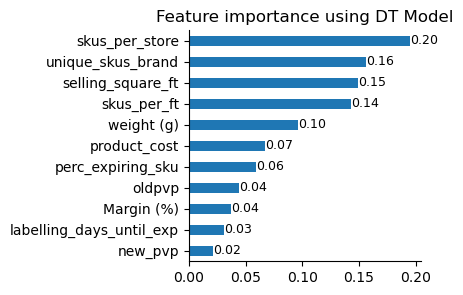

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________


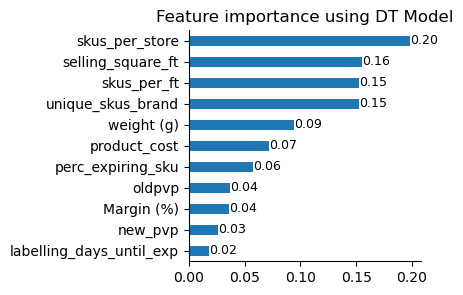

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________


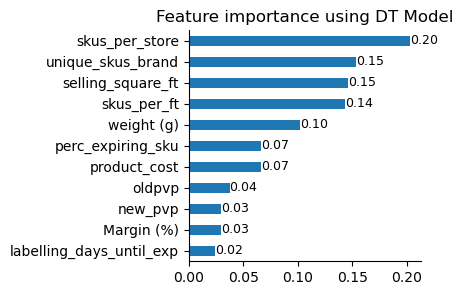

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________


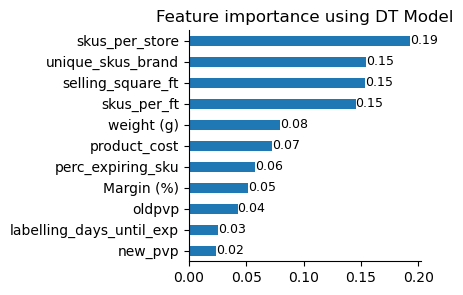

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________


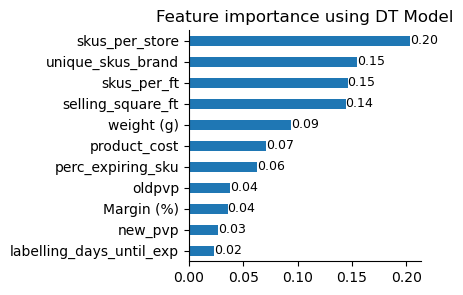

_________________________________________________________________________________________________

                                     SPLIT 6                                    
_________________________________________________________________________________________________


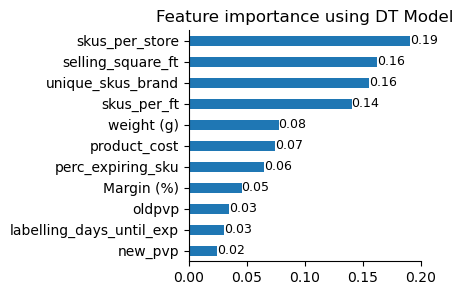

_________________________________________________________________________________________________

                                     SPLIT 7                                    
_________________________________________________________________________________________________


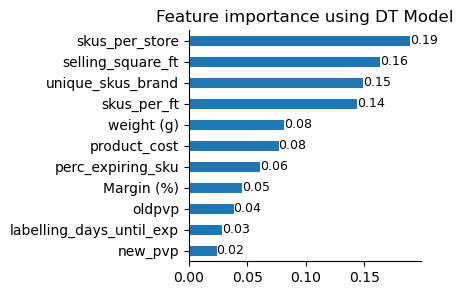

In [261]:
select_best_features_dt(X, y)

Tal como verificado anteriormente, o seguinte grupo de variáveis possui uma forte correlação entre si: 

- `oldpvp` ,`new_pvp` e `product_cost`
- `selling_square_ft` e `skus_per_ft`
- `perc_expiring_sku` e `labelling_days_unitl_exp`

A presença de uma correlação significativa entre essas variáveis pode indicar que as mesmas estão a capturar informações semelhantes.
Dito isto, após uma análise de importância das variáveis recorrendo a uma Decision Tree, verifica-se que se poderá proceder à eliminação das seguintes variáveis por serem aquelas que revelam ter menos importância face às altamente correlacionadas:

- `old_pvp`
- `new_pvp`
- `skus_per_ft`
- `labelling_days_until_exp`
 

In [263]:
X = X.drop(['oldpvp','new_pvp','skus_per_ft','labelling_days_until_exp'], axis = 1)

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 4.2.5. Selecção de Variáveis - Multi-Métodos

Por fim, irão ser aplicadas as seguinte técnicas: __Lasso Regression__, __Decision Trees__ e __RFE (Recursive Feature Elimination)__ para verificar a importância das restantes variáveis numéricas.<br> De forma a serem aplicadas, será necessário escalar os dados.
O objectivo é identificar as 4 (de 7) variáveis numéricas mais importantes para o modelo.
Denote-se que foi aplicado o escalonamento logarítmico, uma vez que os dados, de um modo geral, têm uma distrbuição muito pouco uniforme.

#### 4.2.5.1 Recursive Feature Elimination (RFE) (Wrapper Method)

In [267]:
def apply_rfe(X_train, y_train):
    rfe = RFE(estimator = LogisticRegression(), n_features_to_select = 4)
    rfe.fit_transform(X = X_train, y = y_train)
    selected_features = pd.Series(rfe.support_, index = X_train.columns)  
    print(selected_features)

#### 4.2.5.2 Lasso Regression (Embedded Method)

In [269]:
def apply_lasso(X_train, y_train):
    lasso = LogisticRegressionCV(penalty='l1', solver='saga').fit(X_train, y_train)
    coef = pd.Series(abs(lasso.coef_[0]), index = X_train.columns)
    plot_importance(coef,'Lasso')

#### 4.2.5.3 Comparador de Métodos

In [271]:
def select_best_features(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        
        ########################################### SCALE DATA #################################################### 
        numerical_data = X_train.drop(['type','region','marca_2','labelling_day_of_week'], axis = 1).copy()
        X_train_scaled = np.log1p(numerical_data)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns = numerical_data.columns)
    
        ######################################### SELECT FEATURES #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')
        
        # Check which features to use using RFE
        print('')
        print('----------------- RFE ----------------------')
        apply_rfe(X_train_scaled, y_train)
        
        # check which features to use using lasso
        print('')
        print('----------------- LASSO ----------------------')
        apply_lasso(X_train_scaled, y_train)
            
        # check which features to use using lasso
        print('')
        print('----------------- DT ----------------------')
        apply_dt(X_train_scaled, y_train)
            
        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
weight (g)           False
Margin (%)           False
perc_expiring_sku     True
selling_square_ft    False
skus_per_store        True
unique_skus_brand     True
product_cost          True
dtype: bool

----------------- LASSO ----------------------


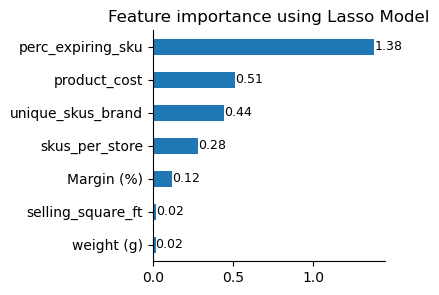


----------------- DT ----------------------


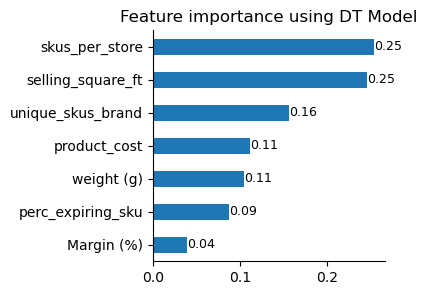

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
weight (g)           False
Margin (%)           False
perc_expiring_sku     True
selling_square_ft    False
skus_per_store        True
unique_skus_brand     True
product_cost          True
dtype: bool

----------------- LASSO ----------------------


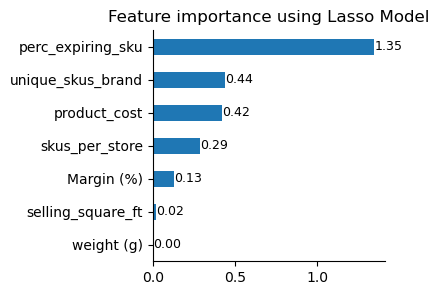


----------------- DT ----------------------


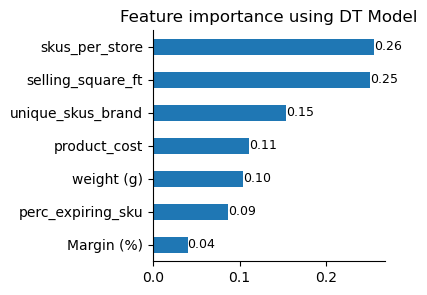

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
weight (g)           False
Margin (%)           False
perc_expiring_sku     True
selling_square_ft    False
skus_per_store        True
unique_skus_brand     True
product_cost          True
dtype: bool

----------------- LASSO ----------------------


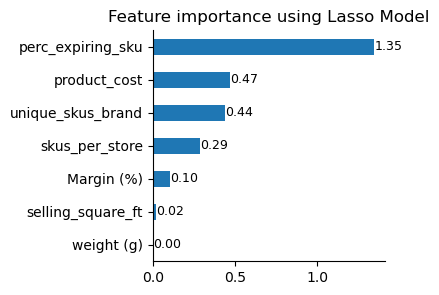


----------------- DT ----------------------


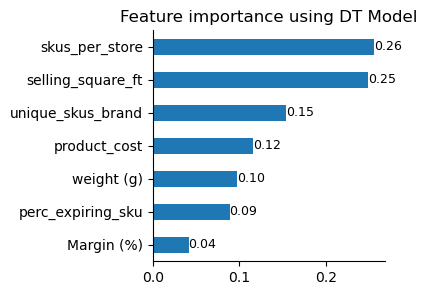

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
weight (g)           False
Margin (%)           False
perc_expiring_sku     True
selling_square_ft    False
skus_per_store        True
unique_skus_brand     True
product_cost          True
dtype: bool

----------------- LASSO ----------------------


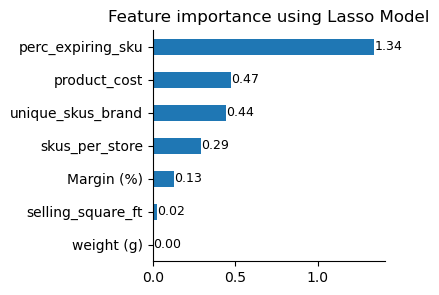


----------------- DT ----------------------


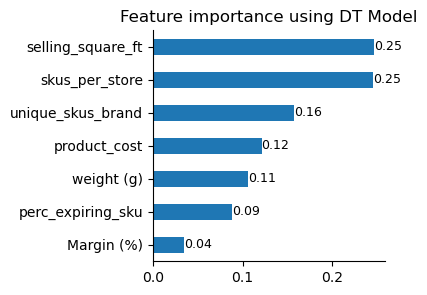

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
weight (g)           False
Margin (%)           False
perc_expiring_sku     True
selling_square_ft    False
skus_per_store        True
unique_skus_brand     True
product_cost          True
dtype: bool

----------------- LASSO ----------------------


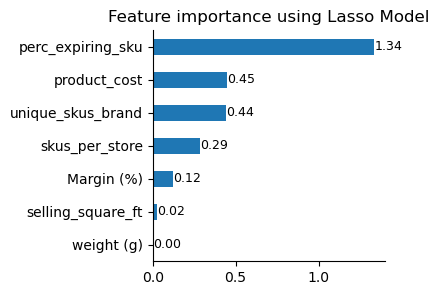


----------------- DT ----------------------


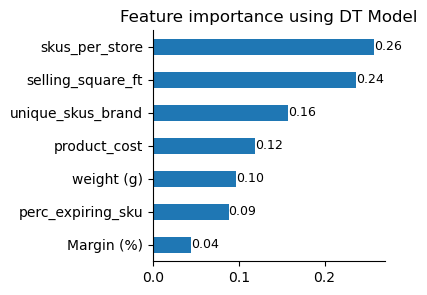

_________________________________________________________________________________________________

                                     SPLIT 6                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
weight (g)           False
Margin (%)           False
perc_expiring_sku     True
selling_square_ft    False
skus_per_store        True
unique_skus_brand     True
product_cost          True
dtype: bool

----------------- LASSO ----------------------


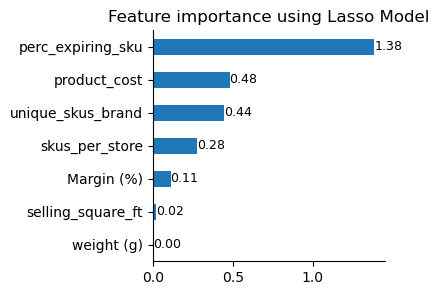


----------------- DT ----------------------


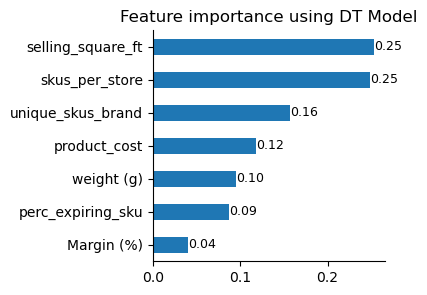

_________________________________________________________________________________________________

                                     SPLIT 7                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
weight (g)           False
Margin (%)           False
perc_expiring_sku     True
selling_square_ft    False
skus_per_store        True
unique_skus_brand     True
product_cost          True
dtype: bool

----------------- LASSO ----------------------


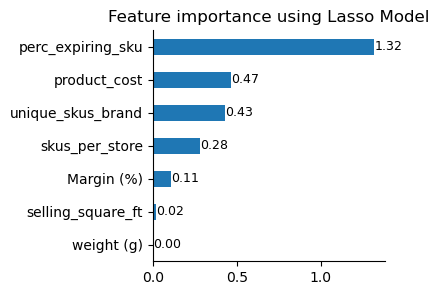


----------------- DT ----------------------


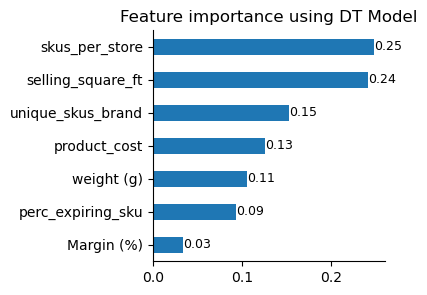

In [272]:
select_best_features(X, y)

Efetua-se a combinação dos resultados obtidos anteriormente para perceber quais as variáveis mais importantes: <br>

#### 4.2.5.4 Análise de Selecção de Features (Lasso, DT e RFE)
| Feature         | Aparições no Top 4 (Lasso) | Aparições no Top 4 (DT) | Média de Aparições como True (RFE) | Estratégia | 
|---------------------|----------------------------|--------------------------|-------------------------------------|-----|
| `weight (g)`        | -                          | -                        | -                                   |REMOVER|
| `Margin (%)`        | -                          | -                        | -                                   |REMOVER|
| `perc_expiring_sku` | 7                          | -                        | 7                              |INCERTEZA|
| `selling_square_ft` | -                          | 7                        | -                              |INCERTEZA|
| `skus_per_store`    | 7                          | 7                        | 7                                   |MANTER|
| `unique_skus_brand` | 7                          | 7                        | 7                                   |MANTER|
| `product_cost`      | 7                          | 7                        | 7                                   |MANTER|


Neste passo, podemos identificar certas variáveis que parecem ser mais importantes para manter, especificamente `skus_per_store`,`unique_skus_brand` e `product_cost`.

No entanto, há outras variáveis sobre as quais existe maior incerteza quanto à sua relevância: `perc_expiring_sku` e `selling_square_ft`.

<div class="alert alert-block alert-success">
<a id='preprocess'>
<font color = '#006400'> 
    
# 5. Modelação e Avaliação
</a>
    
</div>

<div class="alert alert-block alert-warning">

<a id='visual'></a>

## 5.1. Selecção de Modelo
    
</div> 

Neste passo, criam-se dois datasets (`keep_data` e `all_data`), tendo como base a avaliação das variáveis mais importantes:

- __`keep_data`__: composto pelas variáveis mais importantes definidas pelas técnicas de feature selection aplicadas anteriormente.<br>
Variáveis: `type`,`region`,`labelling_day_of_week`,`marca_2`,`skus_per_store`,`unique_skus_brand`,`product_cost`

- __`all_data`__: composto pelas variáveis mais importantes e pelas variáveis sobre as quais temos dúvida quanto à sua utilização.<br>
Variáveis: `type`,`region`,`labelling_day_of_week`,`marca_2`,`skus_per_store`,`unique_skus_brand`,`product_cost`,`perc_expiring_sku` e `selling_square_ft`

In [279]:
keep_data = df_most_recent[['type','region','labelling_day_of_week','marca_2','skus_per_store','unique_skus_brand','product_cost','sold']].copy()	
all_data = df_most_recent[['type','region','labelling_day_of_week','marca_2','skus_per_store','unique_skus_brand','product_cost','perc_expiring_sku','selling_square_ft','sold']].copy()	

<div class="alert alert-block alert-warning">

<a id='visual'></a>

## 5.2. Preparação de Dados - Separação Treino - Teste 
    
</div> 

Separação em __dados de treino__ (90%) e __teste__ (10%) de forma estratificada com base na variável target:

In [282]:
X_keep_data = keep_data.iloc[:,:-1]
y_keep_data = keep_data.iloc[:,-1]

X, X_test, y, y_test = train_test_split(X_keep_data, y_keep_data, 
                                        train_size = 0.9, 
                                        random_state = 99, 
                                        stratify = y_keep_data)
keep_data = pd.concat([X, y], axis=1)

In [283]:
X_all_data = all_data.iloc[:,:-1]
y_all_data = all_data.iloc[:,-1]
X, X_test, y, y_test = train_test_split(X_all_data, y_all_data,           
                                        train_size = 0.9, 
                                        random_state = 99, 
                                        stratify = y_all_data)
all_data = pd.concat([X, y], axis=1)

In [284]:
def transform_data(X_train, X_2nd_df = False, X_2nd_df_flag = False):
    
    ########################################## CREATE DUMMIES #################################################    
    X_train_dummies = pd.get_dummies(X_train)
    X_train_dummies.drop('region_Sul', axis = 1, inplace = True)
    X_train_dummies.drop('type_Medium', axis = 1, inplace = True)
    X_train_dummies.drop('marca_2_yes', axis = 1, inplace = True)
    X_train_dummies.drop('labelling_day_of_week_3', axis = 1, inplace = True)
    
    ############################################ SCALE DATA ###################################################    
    scaler = FunctionTransformer(np.log1p)
    X_train_scaled = scaler.fit_transform(X_train_dummies)
    X_train_scaled = np.log1p(X_train_dummies)
    X_train_scaled = pd.DataFrame(X_train_scaled , columns = X_train_dummies.columns)
    
    if X_2nd_df_flag == True: 
        
        ########################################## CREATE DUMMIES #############################################
        X_2nd_df_dummies = pd.get_dummies(X_2nd_df)
        X_2nd_df_dummies.drop('region_Sul', axis = 1, inplace = True)
        X_2nd_df_dummies.drop('type_Medium', axis = 1, inplace = True)
        X_2nd_df_dummies.drop('marca_2_yes', axis = 1, inplace = True)
        X_2nd_df_dummies.drop('labelling_day_of_week_3', axis = 1, inplace = True)
        missing_cols = set(X_train_dummies.columns ) - set(X_2nd_df_dummies.columns )
        
        for c in missing_cols:
            X_2nd_df_dummies[c] = 0
        
        X_2nd_df_dummies = X_2nd_df_dummies[X_train_dummies.columns]
        
        if 'sold' in X_2nd_df_dummies.columns:
            X_2nd_df_dummies.drop(['sold'], axis=1, inplace=True)
        else:
            pass
        
        ############################################ SCALE DATA ###################################################    
        X_2nd_df_scaled = scaler.transform(X_2nd_df_dummies)
        X_2nd_df_scaled = pd.DataFrame(X_2nd_df_scaled , columns = X_2nd_df_dummies.columns, index = X_2nd_df_dummies.index )
        
   
    if X_2nd_df_flag == False:
        return X_train_scaled
    else:
        return X_train_scaled, X_2nd_df_scaled

In [285]:
def select_best_models(data, model):
    skf = StratifiedKFold(n_splits=7, random_state=99, shuffle=True)
    X = data.drop('sold', axis=1)
    y = data['sold'].copy()

    metrics = {
        "f1_train": [], "f1_val": [],
        "recall_train": [], "recall_val": [],
        "precision_train": [], "precision_val": [],
        "accuracy_train": [], "accuracy_val": [],
        "time": []
    }
    
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        X_train, X_val = transform_data(X_train, X_val, X_2nd_df_flag=True)
        
        start_time = time.time()
        model.fit(X_train, y_train)
        predictions_train = model.predict(X_train)
        predictions_val = model.predict(X_val)
        elapsed_time = time.time() - start_time
        
        metrics["f1_train"].append(f1_score(y_train, predictions_train, average="weighted"))
        metrics["f1_val"].append(f1_score(y_val, predictions_val, average="weighted"))
        metrics["recall_train"].append(recall_score(y_train, predictions_train, average="weighted"))
        metrics["recall_val"].append(recall_score(y_val, predictions_val, average="weighted"))
        metrics["precision_train"].append(precision_score(y_train, predictions_train, average="weighted"))
        metrics["precision_val"].append(precision_score(y_val, predictions_val, average="weighted"))
        metrics["accuracy_train"].append(accuracy_score(y_train, predictions_train))
        metrics["accuracy_val"].append(accuracy_score(y_val, predictions_val))
        metrics["time"].append(elapsed_time)

    avg_metrics = {key: round(np.mean(values), 4) for key, values in metrics.items()}
    std_metrics = {key: round(np.std(values), 4) for key, values in metrics.items()}

    return avg_metrics, std_metrics

In [286]:
def show_results(df, data, *args):
    count = 0
    for arg in args:
        avg_metrics, std_metrics = select_best_models(data, arg)
        
        df.iloc[count] = [
            f"{avg_metrics['f1_train']}+/-{std_metrics['f1_train']}",
            f"{avg_metrics['f1_val']}+/-{std_metrics['f1_val']}",
            f"{avg_metrics['recall_train']}+/-{std_metrics['recall_train']}",
            f"{avg_metrics['recall_val']}+/-{std_metrics['recall_val']}",
            f"{avg_metrics['precision_train']}+/-{std_metrics['precision_train']}",
            f"{avg_metrics['precision_val']}+/-{std_metrics['precision_val']}",
            f"{avg_metrics['accuracy_train']}+/-{std_metrics['accuracy_train']}",
            f"{avg_metrics['accuracy_val']}+/-{std_metrics['accuracy_val']}",
            f"{avg_metrics['time']}"
        ]
        count += 1
    return df

<div class="alert alert-block alert-warning">

<a id='visual'></a>

## 5.3. Comparação e Selecção de Algoritmos 
    
</div>

Em seguida, inicializa-se os vários modelos de previsão, efetuando o treino e a validação depois.<br>
Os seguintes modelos serão inicializados:
- `Logistic Regression (LR)`
- `K-Nearest Neighbors (KNN)`
- `Decision Tree (DT)`
- `Random Forest Classifier (RFC)`
- `Naive Bayes (NB)`
- `Gradient Boosting Classifier (GBC)`
- `AdaBoost Classifier (ABC)`
- `Support Vector Classifier (SVC)`
- `Multi-layer Perceptron (MLP)`

In [289]:
model_LR = LogisticRegression(max_iter=1000)
model_KNN = KNeighborsClassifier(n_neighbors=5, weights="distance", p=1)
model_DT = DecisionTreeClassifier(max_depth = 15, min_samples_split = 10, min_samples_leaf=5,class_weight="balanced", random_state = 99)
model_RFC = RandomForestClassifier(max_depth=20, min_samples_split=4, n_estimators=200,max_features='sqrt', random_state=99)
model_NB = GaussianNB()
model_GBC = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, min_samples_split=5, min_samples_leaf=3, subsample=0.8, random_state=99) 
model_ABC = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, learning_rate=0.5, random_state=99)
model_SVC = SVC(C=0.1, kernel='linear')
model_MLP = MLPClassifier()

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 5.3.1. Treino e Validação - Dataset all_data

In [291]:
df_all = pd.DataFrame(columns=['F1 Train', 'F1 Validation', 'Recall Train', 'Recall Validation',
                               'Precision Train', 'Precision Validation', 'Accuracy Train', 
                               'Accuracy Validation', 'Running Time'],
                      index=['Logistic Regression', 'KNN', 'DT', 'RFC', 'NB','GBC', 'ABC','SVC','MLP'])

In [453]:
show_results(df_all, all_data, model_LR, model_KNN, model_DT, model_RFC, model_NB, model_GBC, model_ABC, model_SVC, model_MLP)

F1 Train    F1 Validation     Recall Train  \
Logistic Regression  0.6236+/-0.0008  0.6233+/-0.0044  0.6351+/-0.0008   
KNN                  0.8123+/-0.0005  0.7109+/-0.0036   0.812+/-0.0005   
DT                   0.7217+/-0.0017  0.6816+/-0.0039  0.7222+/-0.0017   
RFC                  0.8031+/-0.0006  0.7218+/-0.0036  0.8038+/-0.0006   
NB                   0.6153+/-0.0008  0.6152+/-0.0048  0.6297+/-0.0008   
GBC                  0.6487+/-0.0014  0.6476+/-0.0046  0.6538+/-0.0012   
ABC                   0.6646+/-0.001  0.6615+/-0.0043  0.6685+/-0.0009   
SVC                  0.6111+/-0.0008  0.6111+/-0.0047   0.628+/-0.0007   
MLP                  0.6459+/-0.0036  0.6417+/-0.0034   0.652+/-0.0016   

                    Recall Validation  Precision Train Precision Validation  \
Logistic Regression   0.6348+/-0.0042  0.6387+/-0.0009      0.6384+/-0.0047   
KNN                   0.7105+/-0.0036  0.8136+/-0.0004      0.7128+/-0.0035   
DT                    0.6821+/-0.0038  0.7218+/-0.0017      0.6816+/-0.0039   
RFC                   0.7228+/-0.0035  0.8043+/-0.0006      0.7224+/-0.0035   
NB                    0.6296+/-0.0046  0.6347+/-0.0009      0.6347+/-0.0054   
GBC                   0.6527+/-0.0046  0.6542+/-0.0012      0.6529+/-0.0049   
ABC                   0.6654+/-0.0042  0.6686+/-0.0009      0.6655+/-0.0044   
SVC                    0.628+/-0.0044   0.635+/-0.0009       0.635+/-0.0052   
MLP                   0.6478+/-0.0043  0.6533+/-0.0023       0.649+/-0.0057   

                      Accuracy Train Accuracy Validation Running Time  
Logistic Regression  0.6351+/-0.0008     0.6348+/-0.0042       0.6674  
KNN                   0.812+/-0.0005     0.7105+/-0.0036      56.1947  
DT                   0.7222+/-0.0017     0.6821+/-0.0038       0.4728  
RFC                  0.8038+/-0.0006     0.7228+/-0.0035      32.7012  
NB                   0.6297+/-0.0008     0.6296+/-0.0046       0.1547  
GBC                  0.6538+/-0.0012     0.6527+/-0.0046      11.8024  
ABC                  0.6685+/-0.0009     0.6654+/-0.0042      13.4332  
SVC                   0.628+/-0.0007      0.628+/-0.0044    3381.7169  
MLP                   0.652+/-0.0016     0.6478+/-0.0043      643.533

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 5.3.2. Treino e Validação - Dataset keep_data

In [294]:
df_keep = pd.DataFrame(columns=['F1 Train', 'F1 Validation', 'Recall Train', 'Recall Validation',
                               'Precision Train', 'Precision Validation', 'Accuracy Train', 
                               'Accuracy Validation', 'Running Time'],
                      index=['Logistic Regression', 'KNN', 'DT', 'RFC', 'NB','GBC', 'ABC','SVC','MLP'])

In [454]:
show_results(df_keep, keep_data, model_LR, model_KNN, model_DT, model_RFC, model_NB, model_GBC, model_ABC, model_SVC, model_MLP)

F1 Train    F1 Validation     Recall Train  \
Logistic Regression  0.6129+/-0.0008  0.6128+/-0.0046   0.628+/-0.0008   
KNN                  0.7933+/-0.0006  0.7033+/-0.0033  0.7931+/-0.0006   
DT                    0.7156+/-0.002  0.6779+/-0.0044   0.716+/-0.0021   
RFC                  0.7949+/-0.0004  0.7137+/-0.0033  0.7954+/-0.0004   
NB                   0.6143+/-0.0009   0.614+/-0.0045  0.6295+/-0.0008   
GBC                   0.6434+/-0.001  0.6419+/-0.0041  0.6512+/-0.0009   
ABC                  0.6554+/-0.0014  0.6524+/-0.0029   0.661+/-0.0013   
SVC                  0.6111+/-0.0008  0.6111+/-0.0047   0.628+/-0.0007   
MLP                  0.6331+/-0.0024  0.6299+/-0.0055  0.6425+/-0.0019   

                    Recall Validation  Precision Train Precision Validation  \
Logistic Regression   0.6279+/-0.0043  0.6334+/-0.0009      0.6333+/-0.0051   
KNN                    0.703+/-0.0033  0.7941+/-0.0005      0.7047+/-0.0035   
DT                    0.6783+/-0.0044  0.7156+/-0.0021      0.6778+/-0.0044   
RFC                   0.7143+/-0.0033  0.7954+/-0.0004      0.7138+/-0.0033   
NB                    0.6292+/-0.0043  0.6352+/-0.0009       0.635+/-0.0051   
GBC                   0.6497+/-0.0041  0.6533+/-0.0009      0.6518+/-0.0045   
ABC                   0.6581+/-0.0027  0.6622+/-0.0013      0.6592+/-0.0029   
SVC                    0.628+/-0.0044   0.635+/-0.0009       0.635+/-0.0052   
MLP                   0.6395+/-0.0049  0.6452+/-0.0027      0.6421+/-0.0056   

                      Accuracy Train Accuracy Validation Running Time  
Logistic Regression   0.628+/-0.0008     0.6279+/-0.0043       0.5946  
KNN                  0.7931+/-0.0006      0.703+/-0.0033      15.8553  
DT                    0.716+/-0.0021     0.6783+/-0.0044       0.3335  
RFC                  0.7954+/-0.0004     0.7143+/-0.0033      22.1765  
NB                   0.6295+/-0.0008     0.6292+/-0.0043       0.0959  
GBC                  0.6512+/-0.0009     0.6497+/-0.0041       8.1768  
ABC                   0.661+/-0.0013     0.6581+/-0.0027       10.246  
SVC                   0.628+/-0.0007      0.628+/-0.0044     908.9923  
MLP                  0.6425+/-0.0019     0.6395+/-0.0049     553.7521

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 5.3.3. Conclusões

A métrica escolhida para a selecção dos melhores modelos (e que servirão para optimização) é o __*F1 Score*__. Esta é uma métrica ideal para selecionar o melhor modelo em muitos cenários porque equilibra a *precision* e *recall*.

- Ao comparar os resultados obtidos pelos datasets `all_data` e `keep_data`, considerando a métrica acima referida, verifica-se que, de um modo geral, os modelos fornecem melhores resultados com o `all_data` tanto em treino, como em validação.<br>

- Para o dataset `all_data` seguem-se os resultados:

| Modelo                | F1 Train    | F1 Validation | Diferença (Train - Val) |
|----------------------|------------|--------------|----------------------|
| **RFC**             | **0.8031 ± 0.0007** | **0.7224 ± 0.0026** | **0.0807**  |
| **KNN**             | **0.8120 ± 0.0006** | **0.7128 ± 0.0031** | **0.0992**  |
| **DT**              | **0.7193 ± 0.0031** | **0.6806 ± 0.0047** | **0.0387**  |
| **ABC**                | **0.6644 ± 0.0014** | **0.6611 ± 0.0030** | **0.0033**  |
| GBC                 | 0.6482 ± 0.0019 | 0.6472 ± 0.0023 | 0.0010  |
| LR | 0.6236 ± 0.0006 | 0.6233 ± 0.0023 | 0.0003  |




- Os __melhores modelos__ em validação são, em ordem descendente:
    - Random Forest Classifier, com f1-score de 0.722
    - K-Nearest Neighbors, com f1-score de 0.713
    - Decision Tree, com f1-score de 0.681
    - AdaBoost Classifier, com f1-score de 0.664
    <br><br>
- Analisando o __overfitting__:
    - K-Nearest Neighbors é o modelo com mais overfitting, com uma diferença entre treino e validação de cerca de 0.1;
    - Random Forest Classifier e Decision Tree são modelos que apresentam igualmente pouco overfitting, com uma diferença entre treino e validação de cerca de 0.08 e 0.03, respectivamente;
    - AdaBoost Classifier não sofre overfitting mas o seu valor de f1-score é baixo;
    
A `Random Forest Classifier` e `Decision Tree` parecem ser os modelos mais promissores, seguidas pelo `K-Nearest Neighbors`.<br>
Assim, vamos rejeitar a AdaBoost Classifier e tentar melhorar os restantes modelos.



<div class="alert alert-block alert-success">

<a class="anchor" id="4th-bullet">

## 5.4. Optimização do Modelo
    
</div></a>

Nesta fase, será feita a optimização dos hiperparâmetros dos melhores modelos testados acima, selecionando as opções que resultam no melhor desempenho geral.

Serão utilizados dois métodos de optimização, incluindo:
1. `Optimização Manual`
2. `GridSearch`

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 5.4.1. K-Nearest Neighbor

No K-Nearest Neighbors (KNN), o hiperparâmetro `n_neighbors` define o número de vizinhos a serem considerados durante o algoritmo. Assumir um valor pequeno de vizinhos geralmente leva ao overfitting, enquanto usar um valor grande de 'k' tende a resultar em fronteiras de decisão mais suaves e pode causar underfitting.<br>
Dito isto, uma vez que se inicializou o modelo com `n_neighbors`igual a 5 e resultou em overfitting, serão testados valores maiores.

In [356]:
def point_plot(train, validation, values_try):
    plt.figure(figsize=(8, 5))

    sns.pointplot(x=values_try, y=train.values, color='teal', label='Train')
    sns.pointplot(x=values_try, y=validation.values, color='goldenrod', label='Validation')

    plt.title("F1 Score vs. Number of Neighbors")
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.show()

In [358]:
def get_models_knn(data, values):
    results_avg = {}
    results_std = {}
    for value in values:
        model = KNeighborsClassifier(n_neighbors=value)
        try:
            avg_metrics, std_metrics = select_best_models(data, model)
            results_avg[f'neighbors_{value}'] = avg_metrics
            results_std[f'neighbors_{value}'] = std_metrics
        except Exception as e:
            print(f"Erro ao processar neighbors_{value}: {e}")
    return results_avg, results_std

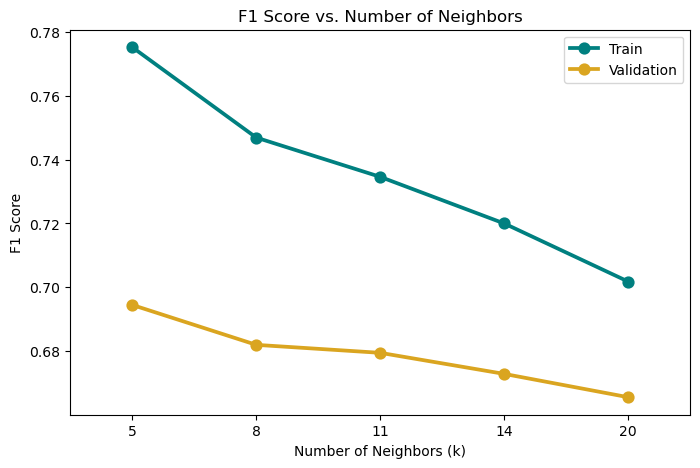

In [360]:
values_try = [5,8,11,14,20]
results_train, results_val = get_models_knn(all_data, values_try)
df_results = pd.DataFrame.from_dict(results_train, orient="index")
df_results_val = pd.DataFrame.from_dict(results_val, orient="index")
point_plot(df_results["f1_train"], df_results["f1_val"], values_try)

Através da análise do gráfico de `n_neighbors - f1-score`, conclui-se que o melhor valor de `n_neighbors` que garante o melhor tradeoff entre o f1-score de validação e overfitting é de __8__.

In [307]:
final_model_knn = KNeighborsClassifier(n_neighbors = 8)

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 5.4.1. Decision Trees

Entre os métodos de optimização `RandomizedSearchCV` e `GridSearchCV`, escolheu-se o segundo pois pretende-se explorar exaustivamente todas as combinações de hiperparâmetros para garantir a melhor configuração possível. Apesar de ser mais demorado, garante-se que nenhuma combinação promissora é ignorada.

In [311]:
data = all_data.copy()

X_data = data.drop(['sold'], axis = 1)
y_data = data['sold'].copy()

X_data = transform_data(X_train = X_data, X_2nd_df_flag = False)

In [312]:
dt = DecisionTreeClassifier(max_depth = 2, random_state = 99)

In [313]:
parameter_space_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5,10,12,15,17],
    'min_samples_split': [5, 8,10,15],
    'min_samples_leaf':[5,10,15]
}

In [314]:
grid_search = GridSearchCV(dt, parameter_space_grid, scoring = 'f1', return_train_score = True, cv = 7)

In [315]:
grid_search.fit(X_data, y_data)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Hyperparameters:  {'criterion': 'entropy', 'max_depth': 17, 'min_samples_leaf': 5, 'min_samples_split': 5}
Best Score:  0.7247003878952627


Os melhores hiperparâmetros encontrados para a `Decision Tree` foram `criterion='entropy'`, `max_depth=17`, `min_samples_leaf=5` e `min_samples_split=5`, resultando em uma pontuação de `0.7247`. Estes parâmetros serão utilizados para a escolha do melhor modelo.

In [361]:
final_model_dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 17, min_samples_leaf=5, min_samples_split = 5)

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 5.4.2. Random Forest

In [319]:
rf = RandomForestClassifier(max_depth=20, min_samples_split=4,n_estimators=200, max_features='sqrt',random_state=99)

In [320]:
parameter_space_grid_rf = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5,10,12,17,20],
    'min_samples_split': [4, 7, 11, 14],
    'n_estimators': [100, 200, 300, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
}

In [321]:
grid_search_rf = GridSearchCV(rf, parameter_space_grid_rf, scoring = 'f1', return_train_score = True, cv = 7)

In [322]:
grid_search_rf.fit(X_data, y_data)

print("Best Hyperparameters: ", grid_search_rf.best_params_)
print("Best Score: ", grid_search_rf.best_score_)

Best Hyperparameters:  {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 100}
Best Score:  0.751092837147111


Os melhores hiperparâmetros encontrados para a `Random Forest` foram `criterion='entropy'`, `max_depth=`20, `max_features`= 'sqrt',`min_samples_split=`4 e `n_estimators`=100, resultando em uma pontuação de `0.751`. Estes parâmetros serão utilizados para a escolha do melhor modelo.

In [370]:
final_model_rf = RandomForestClassifier(
    criterion='entropy', 
    max_depth=20, 
    min_samples_split=4, 
    max_features='sqrt', 
    n_estimators=100
)

<div class="alert alert-block alert-info">

<a class="anchor" id="10th-bullet">

### 5.4.3. Selecção do Melhor Modelo

<a class="anchor" id="8th-bullet">

#### 5.4.3.1. Comparação de Perfomance
    
</a>

In [374]:
df_final_models = pd.DataFrame(columns = ['F1 Train', 'F1 Validation', 'Recall Train', 'Recall Validation',
                               'Precision Train', 'Precision Validation', 'Accuracy Train', 
                               'Accuracy Validation', 'Running Time'], index = ['Best KNN','Best DT','Best RFC'])
show_results(df_final_models, all_data, final_model_knn, final_model_dt,final_model_rf)

F1 Train    F1 Validation     Recall Train Recall Validation  \
Best KNN  0.7469+/-0.0006   0.682+/-0.0041  0.7468+/-0.0006   0.6818+/-0.0041   
Best DT    0.735+/-0.0032  0.6861+/-0.0043  0.7361+/-0.0031   0.6873+/-0.0042   
Best RFC  0.8004+/-0.0007  0.7202+/-0.0032  0.8012+/-0.0008   0.7213+/-0.0031   

          Precision Train Precision Validation   Accuracy Train  \
Best KNN  0.7535+/-0.0007       0.6881+/-0.004  0.7468+/-0.0006   
Best DT    0.7359+/-0.003      0.6866+/-0.0042  0.7361+/-0.0031   
Best RFC  0.8018+/-0.0008      0.7209+/-0.0032  0.8012+/-0.0008   

         Accuracy Validation Running Time  
Best KNN     0.6818+/-0.0041      25.3655  
Best DT      0.6873+/-0.0042       0.4926  
Best RFC     0.7213+/-0.0031      14.5572

<a class="anchor" id="8th-bullet">

#### 5.4.3.2. Curva ROC
    
</a>

Neste passo, os modelos de previsão serão comparados utilizando uma curva ROC. A __Curva ROC (Receiver Operating Characteristic)__ é um gráfico que avalia a relação entre a taxa de verdadeiros positivos (sensibilidade/recall) e a taxa de falsos positivos. Uma curva mais próxima do canto superior esquerdo indicará um modelo melhor.

In [377]:
data = all_data.copy()

X_data = data.iloc[:,:-1]
y_data = data.iloc[:,-1]

In [378]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data,
                                                  train_size = 0.9, 
                                                  random_state = 99, 
                                                  stratify = y_data)

In [379]:
X_train, X_val = transform_data(X_train, X_val, X_2nd_df_flag = True)

model_knn = final_model_knn.fit(X_train, y_train)
model_dt = final_model_dt.fit(X_train, y_train)
model_rf = final_model_rf.fit(X_train, y_train)

In [380]:
prob_modelKNN = model_knn.predict_proba(X_val)
prob_modelDT =  model_dt.predict_proba(X_val)
prob_modelRF =  model_rf.predict_proba(X_val)

In [381]:
fpr_modelKNN, tpr_modelKNN, thresholds_modelKNN = roc_curve(y_true = y_val, y_score = prob_modelKNN[:,1])
fpr_modelDT, tpr_modelDT, thresholds_modelDT = roc_curve(y_val, prob_modelDT[:,1])
fpr_modelRF, tpr_modelRF, thresholds_modelRF = roc_curve(y_val, prob_modelRF[:,1])

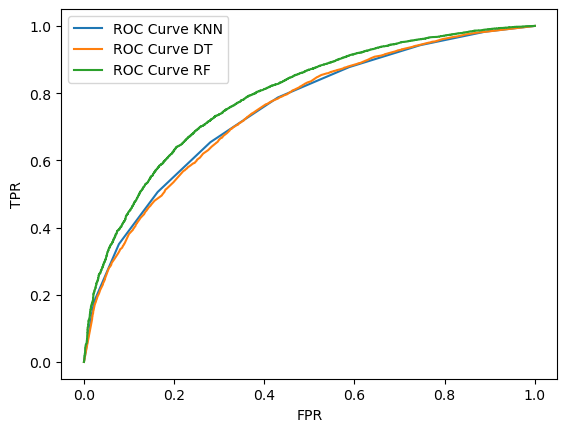

In [382]:
plt.plot(fpr_modelKNN, tpr_modelKNN,label="ROC Curve KNN")
plt.plot(fpr_modelDT, tpr_modelDT, label="ROC Curve DT")
plt.plot(fpr_modelRF, tpr_modelRF, label="ROC Curve RF")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 5.4.4. Conclusões


O modelo __Random Forest Classifier__ apresenta os melhores resultados gerais nas métricas de perfomance analisadas e possui a melhor curva ROC comparativamente aos modelos KNN e Decision Tree. Será este o modelo escolhido para o nosso caso de estudo.<br>
Neste momento, os melhores hiperparâmetros para o melhor modelo estão definidos. O último ajuste a ser realizado para melhorar o seu desempenho é a mudança do limite (*threshold*) entre uma previsão positiva e uma previsão negativa.

In [385]:
final_model = final_model_rf.fit(X_train, y_train)

In [386]:
predict_proba = final_model.predict_proba(X_val)
predict_proba

array([[0.25954191, 0.74045809],
       [0.81459037, 0.18540963],
       [0.61632967, 0.38367033],
       ...,
       [0.37535445, 0.62464555],
       [0.27381607, 0.72618393],
       [0.7154915 , 0.2845085 ]])

Best Threshold=0.373164, F-Score=0.758


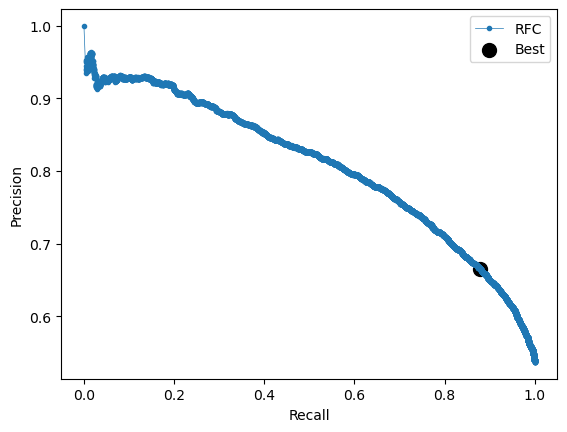

In [424]:
precision, recall, thresholds = precision_recall_curve(y_val, predict_proba[:,1])

fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

plt.plot(recall, precision, marker='.', label='RFC', linewidth=0.5)
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best', s=100)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


Através da análise do gráfico anterior, verifica-se que ao mudar o limite (threshold) para **0.373164**, conseguimos melhorar o F1-score do nosso modelo final.

In [403]:
threshold = 0.373164

<div class="alert alert-block alert-info">

<a class="anchor" id="13th-bullet">

### 5.4.5. Ensaio Geral do Modelo

Como última etapa, o modelo será treinado novamente com os parâmetros optimizados e será determinado a perfomance geral do modelo.

In [407]:
train = all_data.copy()

X_train = all_data.drop(['sold'], axis = 1)
y_train = all_data['sold']

In [430]:
X, X_test, y, y_test = train_test_split(X_all_data, y_all_data,           
                                        train_size = 0.9, 
                                        random_state = 99, 
                                        stratify = y_all_data)

In [434]:
X_train, X_test = transform_data(X_train, X_test, X_2nd_df_flag = True)

In [436]:
final_model = final_model_rf.fit(X_train, y_train)

In [437]:
final_model.predict(X_test)

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [439]:
test_pred = []

for value in predict_proba_test[:,1]:
    if (value>=threshold):
        test_pred.append(1)
    else:
        test_pred.append(0)

In [440]:
f1_score(y_test, test_pred)

0.7595634320293927

O modelo tem um bom equilíbrio entre precisão e recall, com um F1-score de __76%__.

<div class="alert alert-block alert-success">
<a id='preprocess'>
<font color = '#006400'> 
    
# 6. Considerações Finais
</a>
    
</div>

O desenvolvimento deste modelo de previsão para o programa de descontos com etiquetas cor-de-rosa permitiu uma análise aprofundada dos padrões de consumo e do impacto das reduções de preço em produtos próximos da data de validade. Ao longo das diferentes fases do estudo, desde o tratamento dos dados até à otimização dos hiperparâmetros do modelo, foi possível estruturar um sistema preditivo capaz de auxiliar a tomada de decisão nas estratégias de pricing e na redução do desperdício.

Um dos maiores desafios enfrentados foi a qualidade dos dados disponíveis, que apresentavam diversos valores em falta (missing values), outliers e algumas incoerências. Para garantir a fiabilidade do modelo, foi necessário um trabalho rigoroso de limpeza e preparação dos dados, assegurando que as informações utilizadas no treino refletiam com precisão os padrões de consumo e a influência dos descontos.

Após a análise comparativa entre os modelos testados, o Random Forest Classifier apresentou os melhores resultados gerais nas métricas de desempenho analisadas e possui a melhor curva ROC em comparação com os modelos KNN e Decision Tree. Assim, foi o modelo escolhido para este estudo.

A interpretação dos erros do modelo também foi fundamental, especialmente no que se refere às consequências de um falso positivo (prever que um produto será vendido, mas não ser) e de um falso negativo (prever que um produto não será vendido, mas ser). Estes erros impactam diretamente a eficiência do programa de descontos:

__Falsos Positivos:__ Se o modelo indicar que um produto será vendido sem necessidade de desconto, mas este acabar por não ser comprado, isso resultará na perda total do valor do produto, uma vez que atingirá o fim da sua validade sem ser comercializado. Este cenário agrava o desperdício e tem um impacto financeiro negativo. Se o foco do cliente for este, deverá ter atenção à métrica 'recall' do modelo. 

__Falsos Negativos:__ Se o modelo prever que um produto não será vendido e recomendar um desconto maior do que o necessário, a loja poderá reduzir o preço além do necessário, diminuindo a sua margem de lucro de forma evitável. Assim, um produto que poderia ter sido vendido com um desconto menor acaba por gerar uma perda financeira maior. Se o foco do cliente for este, deverá ter atenção à métrica 'precision' do modelo. 

Diante destas questões, é essencial encontrar um equilíbrio entre estas métricas, tendo em conta a estratégia do cliente e as prioridades comerciais do programa. A escolha do limiar de decisão do modelo deve ser ajustada conforme os objetivos da empresa: maximização das vendas, redução do desperdício ou optimização das margens de lucro.

Como próximos passos, recomenda-se a continuação do refinamento do modelo, incorporando novas variáveis que possam influenciar as decisões de compra dos consumidores, como sazonalidade, datas comemorativas, flutuações económicas, categoria de produto e preços concorrentes. Além disso, será essencial analisar a evolução das diferentes etiquetas aplicadas aos produtos ao longo do tempo, e não apenas a última etiqueta de desconto, de forma a compreender melhor os padrões de consumo e a eficácia de diferentes estratégias de precificação. Seria importante aumentar o intervalo temporal de análise, para poder aplicar Time-Series Crossfold e, consequentemente, analisar a popularidade do produto/marca no passado. 

Perante o domínio da marca 2 no dataset, seria importante testar modelos independentes: um para a marca 2 e outro para as restantes marcas.

<div class="alert alert-block alert-success">
<a id='preprocess'>
<font color = '#006400'> 
    
# 7. Clustering
</a>
    
</div>

Com o objeitvo de completar a análise e oferecer mais do que um modelo de previsão, pretende-se também recomendar ações que maximizem a venda de produtos próximos da validade.
E para completar a nossa análise prescritiva, executou-se uma análise de clusters para identificar os grupos de dados existentes e enriquecer as recomendações.

In [464]:
df_clustering = all_data.copy()

df_clustering.columns

Index(['type', 'region', 'labelling_day_of_week', 'marca_2', 'skus_per_store',
       'unique_skus_brand', 'product_cost', 'perc_expiring_sku',
       'selling_square_ft', 'sold'],
      dtype='object')

In [465]:
df_clustering.drop(['region', 'labelling_day_of_week', 'skus_per_store'], axis=1, inplace=True)

<div class="alert alert-block alert-warning">

<a id='visual'></a>

## 7.1. Criação de Variáveis Dummy
    
</div>

In [467]:
df_clust_dummies = pd.get_dummies(df_clustering, columns=['type','marca_2'], drop_first=True)

df_clust_dummies.columns

Index(['unique_skus_brand', 'product_cost', 'perc_expiring_sku',
       'selling_square_ft', 'sold', 'type_Medium', 'type_Small',
       'marca_2_yes'],
      dtype='object')

<div class="alert alert-block alert-warning">

<a id='visual'></a>

## 7.2. Power Transformation
    
</div>

O power transformation com logaritmos é aplicado para reduzir a assimetria e a tornar a distribuição dos dados mais próxima da normal, com o objetivo de melhorar a performance do K-Means e garantir clusters mais equilibrados.

In [468]:
assymetric_variables = df_clust_dummies[['unique_skus_brand', 'product_cost',
       'perc_expiring_sku', 'selling_square_ft']]

for col in assymetric_variables.columns:
    df_clust_dummies[f"{col}_sqrt"] = np.sqrt(df_clust_dummies[col].clip(lower=0)) 

In [469]:
df_clust_dummies.describe()

df_clust_dummies.columns

Index(['unique_skus_brand', 'product_cost', 'perc_expiring_sku',
       'selling_square_ft', 'sold', 'type_Medium', 'type_Small', 'marca_2_yes',
       'unique_skus_brand_sqrt', 'product_cost_sqrt', 'perc_expiring_sku_sqrt',
       'selling_square_ft_sqrt'],
      dtype='object')

In [470]:
df_clust_dummies.drop(['unique_skus_brand', 'product_cost',
       'perc_expiring_sku', 'selling_square_ft'], axis = 1, inplace = True)

<div class="alert alert-block alert-warning">

<a id='visual'></a>

## 7.3. Normalização
    
</div>

A normalização dos dados é aplicada para padronizar escalas e evitar que variáveis com magnitudes diferentes tenham impacto desproporcional na formação dos clusters.

In [508]:
numeric_cols = df_clust_dummies.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()

df_clust_dummies_scaled = df_clust_dummies.copy()
df_clust_dummies_scaled[numeric_cols] = scaler.fit_transform(df_clust_dummies_scaled[numeric_cols])

df_clust_dummies_scaled.columns

Index(['sold', 'type_Medium', 'type_Small', 'marca_2_yes',
       'unique_skus_brand_sqrt', 'product_cost_sqrt', 'perc_expiring_sku_sqrt',
       'selling_square_ft_sqrt'],
      dtype='object')

<div class="alert alert-block alert-warning">

<a id='visual'></a>

## 7.4. Exploração de K Ideal
    
</div>

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 7.4.1. Elbow Method

Recorreu-se ao método Elbow Method para determinar o número ideal de clusters no K-Means. <br>
Este método avalia a variação da inércia à medida que o número de clusters aumenta. <br>
O ponto onde a redução da inércia começa a desacelerar indica o número ótimo de clusters, garantindo um equilíbrio entre granularidade e interpretabilidade dos grupos.

In [478]:
ks = range(1, 11)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k).fit(df_clust_dummies_scaled)
    inertias.append(model.inertia_)

Como k = 2, 3 e 4 apresentam o melhor trade-off entre inércia e número de grupos, o K-Means será aplicado para cada um deles. Em seguida, os clusters serão visualizados com base em duas componentes principais da PCA.

A escolha do melhor k será feita a partir da análise das médias das variáveis em cada grupo e da interpretação dos gráficos resultantes.

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 7.4.2. K-means Clustering

In [480]:
def kmeans_clustering(df_scaled, k, scaler, numeric_cols):
    df_prod_k = df_scaled.copy()
    model_k = KMeans(n_clusters=k, n_init=10, random_state=100).fit(df_prod_k)
    df_prod_k['label'] = model_k.labels_
    dists = euclidean_distances(model_k.cluster_centers_)

    #Obter o dataset não escalonado
    df_unscaled = df_prod_k.copy()
    cols_to_inverse = [col for col in numeric_cols if col in df_unscaled.columns]
    df_unscaled[cols_to_inverse] = scaler.inverse_transform(df_unscaled[cols_to_inverse]) 
    
    return df_prod_k, dists, df_unscaled, model_k

In [482]:
def kmeans_clustering(df_scaled, k, scaler, numeric_cols):
    df_prod_k = df_scaled.copy()
    model_k = KMeans(n_clusters=k, n_init=10, random_state=100).fit(df_prod_k)
    df_prod_k['label'] = model_k.labels_
    dists = euclidean_distances(model_k.cluster_centers_)

    #Obter o dataset não escalonado
    df_unscaled = df_prod_k.copy()
    cols_to_inverse = [col for col in numeric_cols if col in df_unscaled.columns]
    df_unscaled[cols_to_inverse] = scaler.inverse_transform(df_unscaled[cols_to_inverse]) 
    
    return df_prod_k, dists, df_unscaled, model_k

In [510]:
k_visualization = [2, 3, 4]
for k in k_visualization:
    df_prod_k, dists, df_unscaled, model_k = kmeans_clustering(df_clust_dummies_scaled, k, scaler, numeric_cols)
    print(f"Distâncias Euclidianas entre os centróides dos clusters:\n{dists}")
    print(f"Média de cada variável por cluster (K = {k}, não escalonados):")
    print(df_unscaled.groupby(['label']).mean().transpose())

Distâncias Euclidianas entre os centróides dos clusters:
[[0.         2.58797236]
 [2.58797236 0.        ]]
Média de cada variável por cluster (K = 2, não escalonados):
label                           0          1
sold                     0.337529   0.618382
type_Medium              0.461763   0.397868
type_Small               0.301254   0.453009
marca_2_yes              0.004563   0.997374
unique_skus_brand_sqrt   3.599177  11.074450
product_cost_sqrt        1.037887   0.907283
perc_expiring_sku_sqrt   0.604951   0.561889
selling_square_ft_sqrt  73.968193  62.661564
Distâncias Euclidianas entre os centróides dos clusters:
[[0.         2.04607656 2.94494721]
 [2.04607656 0.         2.65822457]
 [2.94494721 2.65822457 0.        ]]
Média de cada variável por cluster (K = 3, não escalonados):
label                           0          1          2
sold                     0.606257   0.632925   0.322645
type_Medium              0.060445   0.708554   0.472006
type_Small               0.9390

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 7.4.3. PCA for Clustering Visualization

In [488]:
def pca_visualization(df_scaled, model_k): 
    df_pca = df_scaled.copy()
    df_pca['cluster'] = df_pca['label']
    df_pca_numeric = df_pca.drop(columns=['label', 'cluster'])
    
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(df_pca_numeric)
    
    df_pca['PCA1'] = pca_components[:, 0]
    df_pca['PCA2'] = pca_components[:, 1]

    return df_pca

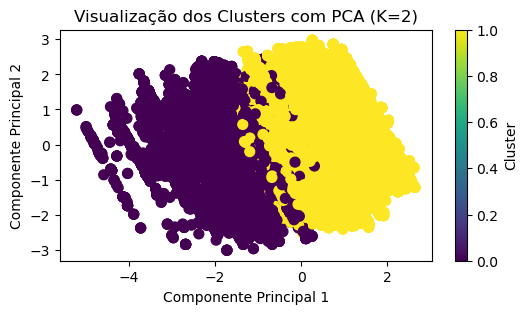

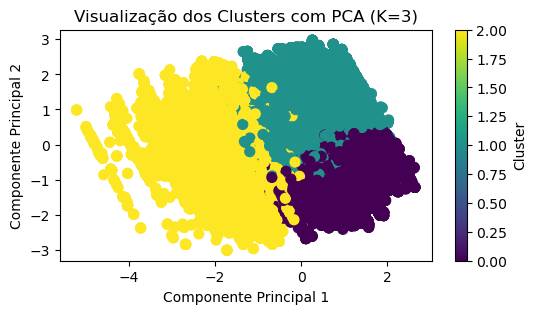

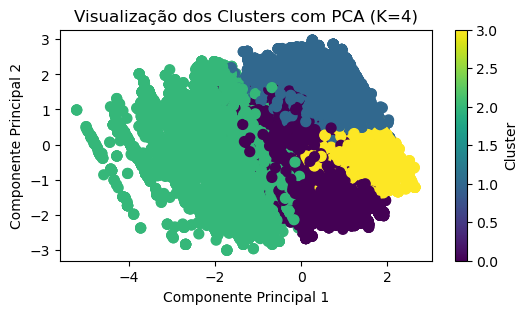

In [512]:
k_visualization = [2, 3, 4]
for k in k_visualization:
    df_prod_k, dists, df_unscaled, model_k = kmeans_clustering(df_clust_dummies_scaled, k, scaler, numeric_cols)
    df_pca = pca_visualization(df_prod_k, model_k)
    
    plt.figure(figsize=(6, 3))
    plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_pca['cluster'], cmap='viridis', s=50)
    plt.title(f'Visualização dos Clusters com PCA (K={model_k.n_clusters})')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.colorbar(label='Cluster')
    plt.show()

<div class="alert alert-block alert-warning">

<a id='visual'></a>

## 7.5. K Choice: K=3
    
</div>

Com base na análise das visualizações gráficas e nas médias das variáveis em cada grupo, conclui-se que o número ideal de clusters é 3, pois proporciona a melhor separação entre os grupos, garantindo maior coerência interna e distinção entre segmentos.

In [492]:
df_k_2, dists_3, df_unscaled_3, model_k_3 = kmeans_clustering(df_clust_dummies_scaled, 3, scaler, numeric_cols)

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 7.5.1 Revert SQRT

Como a transformação foi feita utilizando a raiz quadrada, agora será aplicada a reversão para recuperar os valores originais das variáveis transformadas.

In [494]:
def revert_sqrt_columns(df):
    sqrt_cols = [col for col in df.columns if col.endswith('_sqrt')]
    
    for col in sqrt_cols:
        new_col = col.replace('_sqrt', '')
        df[new_col] = df[col] ** 2
        df.drop(col, axis=1, inplace=True)
    
    return df

df_unscaled_3 = revert_sqrt_columns(df_unscaled_3)


print("Média de cada variável por cluster (K = 3, unscaled):")
display(df_unscaled_3.groupby(['label']).mean().transpose())

Média de cada variável por cluster (K = 3, unscaled):


label                        0            1            2
sold                  0.606257     0.632925     0.322645
type_Medium           0.060445     0.708554     0.472006
type_Small            0.939044     0.000000     0.291538
marca_2_yes           0.978063     0.989929     0.000905
unique_skus_brand   120.664423   122.023158    14.205349
product_cost          0.825345     0.857962     1.123977
perc_expiring_sku     0.361906     0.377179     0.424813
selling_square_ft  1076.125128  9096.905509  6858.341139

<div class="alert alert-block alert-warning">

<a id='visual'></a>

## 7.6. Análise de Clusters
    
</div>

| Cluster | Nome                   | sold (%) | Loja Medium (%) | Loja Small (%) | Marca 2 (%) | SKUs únicos | Custo (€) | Vida útil (%) | Área de vendas (sqft) | Descrição|
|---------|------------------------|----------|-----------------|----------------|-------------|-------------|-----------|----------------|-----------------------|----------------|
| **0**   | **Líderes de Venda** | 63,3%    | **70,9%**           | 0%             | **99,0%**       | **122**         | 0,86      | 37,7%          | **9094**                  | Lojas médias com grande área de vendas, forte presença da Marca 2 (que possui uma grande variedade de SKUs)|
| **1**   | **Eficiência Compacta** | 60,6%    | 6,0%            | **93,9%**         | **97,8%**       | **120**         | 0,82      | 36,2%          | 1076                  | Lojas pequenas, com menor área de venda e boa presença da Marca 2 (que possui uma grande variedade de SKUs).|
| **2**   | **Baixo Desempenho** | 32,3%    | 47,3%           | 29,0%          | 0,08%       | 14          | **1,12**      | **42,4%**          | 6862                  |Lojas com quase nenhuma presença da Marca 2 e com marcas de baixa diversidade de SKUs e produtos de custo mais elevado. |


**Cluster 0:** Apesar de serem os líderes de vendas de produtos próximos da data de validade, existe margem para melhorar. Uma vez que é composto essencialmente por lojas de média dimensão, a estratégia pode passar por:  

1. **Criação de Ilhas de Desconto Temáticas:** como as lojas de média dimensão possuem **espaço para organizar promoções**, crie **ilhas de produtos perto da validade** em áreas centrais da loja, para chamar a atenção de clientes que circulam pelos corredores. Esta estratégia não funcionaria tão bem em lojas pequenas, onde o espaço é limitado, nem em grandes lojas, onde o foco está na variedade e não nas promoções específicas.

2. **Descontos Progressivos Baseados em Volume:**  oferecer **descontos progressivos** como **“Leve 3, pague 2”** ou **“10% de desconto por cada unidade adicional”**. As lojas de média dimensão podem facilmente acomodar este tipo de promoção, incentivando assim compras maiores. Em lojas de pequena dimensão, o espaço é limitado e, por isso, não seria viável esta estratégia.

5. **Utilização de Espaço para Organizar Produtos por Categorias:** organizar os produtos por categorias de validade, dando destaque aos produtos perto da data de validade em secções específicas. A loja de média dimensão tem espaço suficiente para criar uma **"zona de promoções"**, algo que seria difícil em lojas pequenas, onde o espaço é limitado.


**Cluster 1:** A eficácia das etiquetas é ligeiramente inferior neste cluster e, tal como no anteriro, ainda há margem para melhorar a estratégia de labelling para produtos próximos da validade. Uma vez que é composto essencialmente por lojas de pequena dimensão, a estratégia pode ser:  

1. **Posicionamento Estratégico no Caixa:** Como o espaço é limitado, coloque produtos próximos da validade ao lado do caixa. A proximidade do pagamento aumenta a chance de compra por impulso, algo essencial em lojas pequenas;

2. **Descontos em Compras de 1 ou 2 Produtos:** em lojas pequenas, os clientes geralmente não compram em grandes quantidades. Estratégias como “Desconto na segunda unidade” ou “Leve 1, leve o segundo com 50% de desconto” poderiam ser mais eficazes para incentivar compras rápidas e de menor volume;


**Cluster 2:** O clsuter 2 é composto essencialmente por produtos com baixo desempenho de vendas aquando da utlização de etiquetas de desconto por proximidade à validade. É de salientar que é composto essencialmente por produtos que não são da marca 2, que são marcas com uma menor variedade de SKUs.

As estratégias para este cluster seria:
2. **Aumentar os descontos:** para gerar uma maior adesão dos clientes a este tipo de produtos que estão quase a expirar.
3. **Colocar etiquetas de desconto mais cedo:** Apesar dos produtos já possuírem uma vida útil superior quando comparado aos restantes clusters, aumentar esta janela temporal ainda mais poderia ajudar a aumentar o número de vendas.

Caso o aumento do desconto e a extensão do tempo de validade da etiqueta não resultem numa maior taxa de venda destes produtos, faria sentido analisar se a redução do tamanho dos lotes de encomenda aos fornecedores faria sentido, uma vez que poderia diminuir a quantidade de produtos sujeitos a descontos apenas para evitar a expiração. Dessa forma, seria possível reduzir os custos associados ao desperdício, garantindo uma gestão mais eficiente do stock.